# Mini-Movie Storyboard Implementation

**Project**: 3DGS Mini-Movie with Story-driven Animation  
**Date**: 2025-12-08

---

## 콘티 (Storyboard)

### 7단계 구현 계획:
1. **좌표계 정렬**: 방 벽을 xyz 축에 맞추기
2. **방 중심 찾기**: 실제 실내 공간의 중심을 `room_center`로 정의
3. **카메라 시작점**: 초기 카메라 위치/각도 설정
4. **오브젝트 정렬**: obj1(Kermit), obj2(Bottle)를 xyz 축에 맞추기
5. **오브젝트 배치**: 방 내부 위치와 크기 조정
6. **애니메이션**: obj1, obj2의 시간별 움직임 구성
7. **카메라 동선**: 방 전체 → 침대 줌 → 오브젝트 집중

### 타임라인 (10초, 300 frames @ 30fps):
- **0초 (시작)**: 침대 베개 위에 놓인 인형과 술병
- **0-3초 (90 frames)**: 카메라가 방 모서리 위에서 시작 → 방 중심으로 이동 + 360도 회전 (방 전경)
- **3-5초 (60 frames)**: 카메라가 침대/인형/술병 쪽으로 줌인
- **5-10초 (150 frames)**: 
  - 5-7초: 인형이 점프 (y축 위로)
  - 7-10초: 술병이 인형 입 쪽으로 이동 + 기울어지며 위아래 움직임 (마시는 동작)

---

# Part 0: Setup

In [1]:
# Cell 0.0: Install Required Packages

!pip install plyfile --break-system-packages

print("[OK] Dependencies installed")

[OK] Dependencies installed


In [2]:
# Cell 0.1: Imports and Configuration

import numpy as np
import json
import sys
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Optional

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from plyfile import PlyData, PlyElement

# ===========================================
# PLY 파일 경로 설정
# ===========================================
PLY_PATHS = {
    "scene": Path("data/3dgs_outputs/point_cloud_scene_pinhole.ply"),
    "obj01": Path("data/3dgs_outputs/point_cloud_kermit_pinhole.ply"),  # Kermit
    "obj02": Path("data/3dgs_outputs/point_cloud_jimbeam.ply"),          # Bottle
}

# 출력 디렉토리
OUTPUT_DIR = Path("data/mv_demo")
GAUSSIAN_SPLATTING_DIR = Path("gaussian-splatting")

# ===========================================
# 영상 설정
# ===========================================
VIDEO_CONFIG = {
    "fps": 30,
    "duration_sec": 10,
    "resolution": [960, 540],  # [width, height]
    "fov_degrees": 50.0,
}
VIDEO_CONFIG["n_frames"] = VIDEO_CONFIG["fps"] * VIDEO_CONFIG["duration_sec"]

# ===========================================
# 타임라인 구간 정의
# ===========================================
TIMELINE = {
    "segment_A": {"start_sec": 0.0, "end_sec": 3.0},   # 방 전경 (0-3초)
    "segment_B": {"start_sec": 3.0, "end_sec": 5.0},   # 침대 줌 (3-5초)
    "segment_C1": {"start_sec": 5.0, "end_sec": 7.0},  # 인형 점프 (5-7초)
    "segment_C2": {"start_sec": 7.0, "end_sec": 10.0}, # 술병 마시기 (7-10초)
}

# Frame 인덱스로 변환
for seg_name, seg_data in TIMELINE.items():
    seg_data["start_frame"] = int(seg_data["start_sec"] * VIDEO_CONFIG["fps"])
    seg_data["end_frame"] = int(seg_data["end_sec"] * VIDEO_CONFIG["fps"])

# ===========================================
# 자동 생성
# ===========================================
RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
COMPOSITION_DIR = OUTPUT_DIR / RUN_ID
JSON_DIR = COMPOSITION_DIR / "json"
KEYFRAMES_DIR = COMPOSITION_DIR / "keyframes"
FRAMES_DIR = COMPOSITION_DIR / "frames"

for d in [JSON_DIR, KEYFRAMES_DIR, FRAMES_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("=== Storyboard Setup ===")
print(f"Run ID: {RUN_ID}")
print(f"Output: {COMPOSITION_DIR}")
print(f"\nTimeline Segments:")
for seg_name, seg_data in TIMELINE.items():
    print(f"  {seg_name}: {seg_data['start_sec']:.1f}-{seg_data['end_sec']:.1f}s (frames {seg_data['start_frame']}-{seg_data['end_frame']})")
print(f"\nPLY Files:")
for name, path in PLY_PATHS.items():
    status = "OK" if path.exists() else "MISSING"
    print(f"  [{status}] {name}: {path}")

=== Storyboard Setup ===
Run ID: 20251209_081245
Output: data/mv_demo/20251209_081245

Timeline Segments:
  segment_A: 0.0-3.0s (frames 0-90)
  segment_B: 3.0-5.0s (frames 90-150)
  segment_C1: 5.0-7.0s (frames 150-210)
  segment_C2: 7.0-10.0s (frames 210-300)

PLY Files:
  [OK] scene: data/3dgs_outputs/point_cloud_scene_pinhole.ply
  [OK] obj01: data/3dgs_outputs/point_cloud_kermit_pinhole.ply
  [OK] obj02: data/3dgs_outputs/point_cloud_jimbeam.ply


---
# Part 1: Load Gaussian Data

In [3]:
# Cell 1.1: PLY Loading Functions

def load_gaussian_ply(ply_path: Path) -> Dict[str, np.ndarray]:
    """
    Load 3DGS PLY file and return Gaussian parameters as numpy arrays.
    
    Returns:
        dict with keys: xyz, scales, rotations, opacities, features_dc, features_rest
    """
    plydata = PlyData.read(str(ply_path))
    vertex = plydata['vertex']
    
    # Extract data
    xyz = np.stack([vertex['x'], vertex['y'], vertex['z']], axis=1)
    opacities = vertex['opacity'][:, np.newaxis]
    
    # Scales (log-space)
    scale_names = [p.name for p in vertex.properties if p.name.startswith("scale_")]
    scales = np.stack([vertex[name] for name in sorted(scale_names)], axis=1)
    
    # Rotations (quaternions: w, x, y, z)
    rot_names = [p.name for p in vertex.properties if p.name.startswith("rot_")]
    rotations = np.stack([vertex[name] for name in sorted(rot_names)], axis=1)
    
    # SH features
    features_dc = np.stack([vertex[f'f_dc_{i}'] for i in range(3)], axis=1)
    
    extra_f_names = [p.name for p in vertex.properties if p.name.startswith("f_rest_")]
    if len(extra_f_names) > 0:
        features_rest = np.stack([vertex[name] for name in sorted(extra_f_names)], axis=1)
    else:
        features_rest = np.zeros((xyz.shape[0], 0))
    
    return {
        'xyz': xyz.astype(np.float32),
        'scales': scales.astype(np.float32),
        'rotations': rotations.astype(np.float32),
        'opacities': opacities.astype(np.float32),
        'features_dc': features_dc.astype(np.float32),
        'features_rest': features_rest.astype(np.float32),
    }

print("[OK] PLY loading function defined")

[OK] PLY loading function defined


In [4]:
# Cell 1.2: Load All PLY Files

print("Loading PLY files...\n")

scene_gaussians = load_gaussian_ply(PLY_PATHS["scene"])
obj01_gaussians = load_gaussian_ply(PLY_PATHS["obj01"])  # Kermit
obj02_gaussians = load_gaussian_ply(PLY_PATHS["obj02"])  # Bottle

print(f"Scene: {scene_gaussians['xyz'].shape[0]:,} Gaussians")
print(f"Obj01 (Kermit): {obj01_gaussians['xyz'].shape[0]:,} Gaussians")
print(f"Obj02 (Bottle): {obj02_gaussians['xyz'].shape[0]:,} Gaussians")

print("\n[OK] All PLY files loaded")

Loading PLY files...

Scene: 1,508,976 Gaussians
Obj01 (Kermit): 108,077 Gaussians
Obj02 (Bottle): 71,268 Gaussians

[OK] All PLY files loaded


PLY FILE INSPECTION

Scene:
  Points: 1,508,976
  Center: [-0.281, 1.210, 0.913]
  X: [-14.87, 58.65] → span 73.52
  Y: [-41.03, 10.46] → span 51.49
  Z: [-51.94, 16.02] → span 67.96

Obj01 (Kermit):
  Points: 108,077
  Center: [0.014, 1.303, 1.306]
  X: [-1.64, 1.16] → span 2.80
  Y: [-1.83, 3.47] → span 5.30
  Z: [-0.85, 2.45] → span 3.30

Obj02 (Bottle):
  Points: 71,268
  Center: [-2.088, 1.378, 3.124]
  X: [-6.12, 0.67] → span 6.79
  Y: [-0.72, 9.50] → span 10.22
  Z: [-2.63, 5.55] → span 8.18


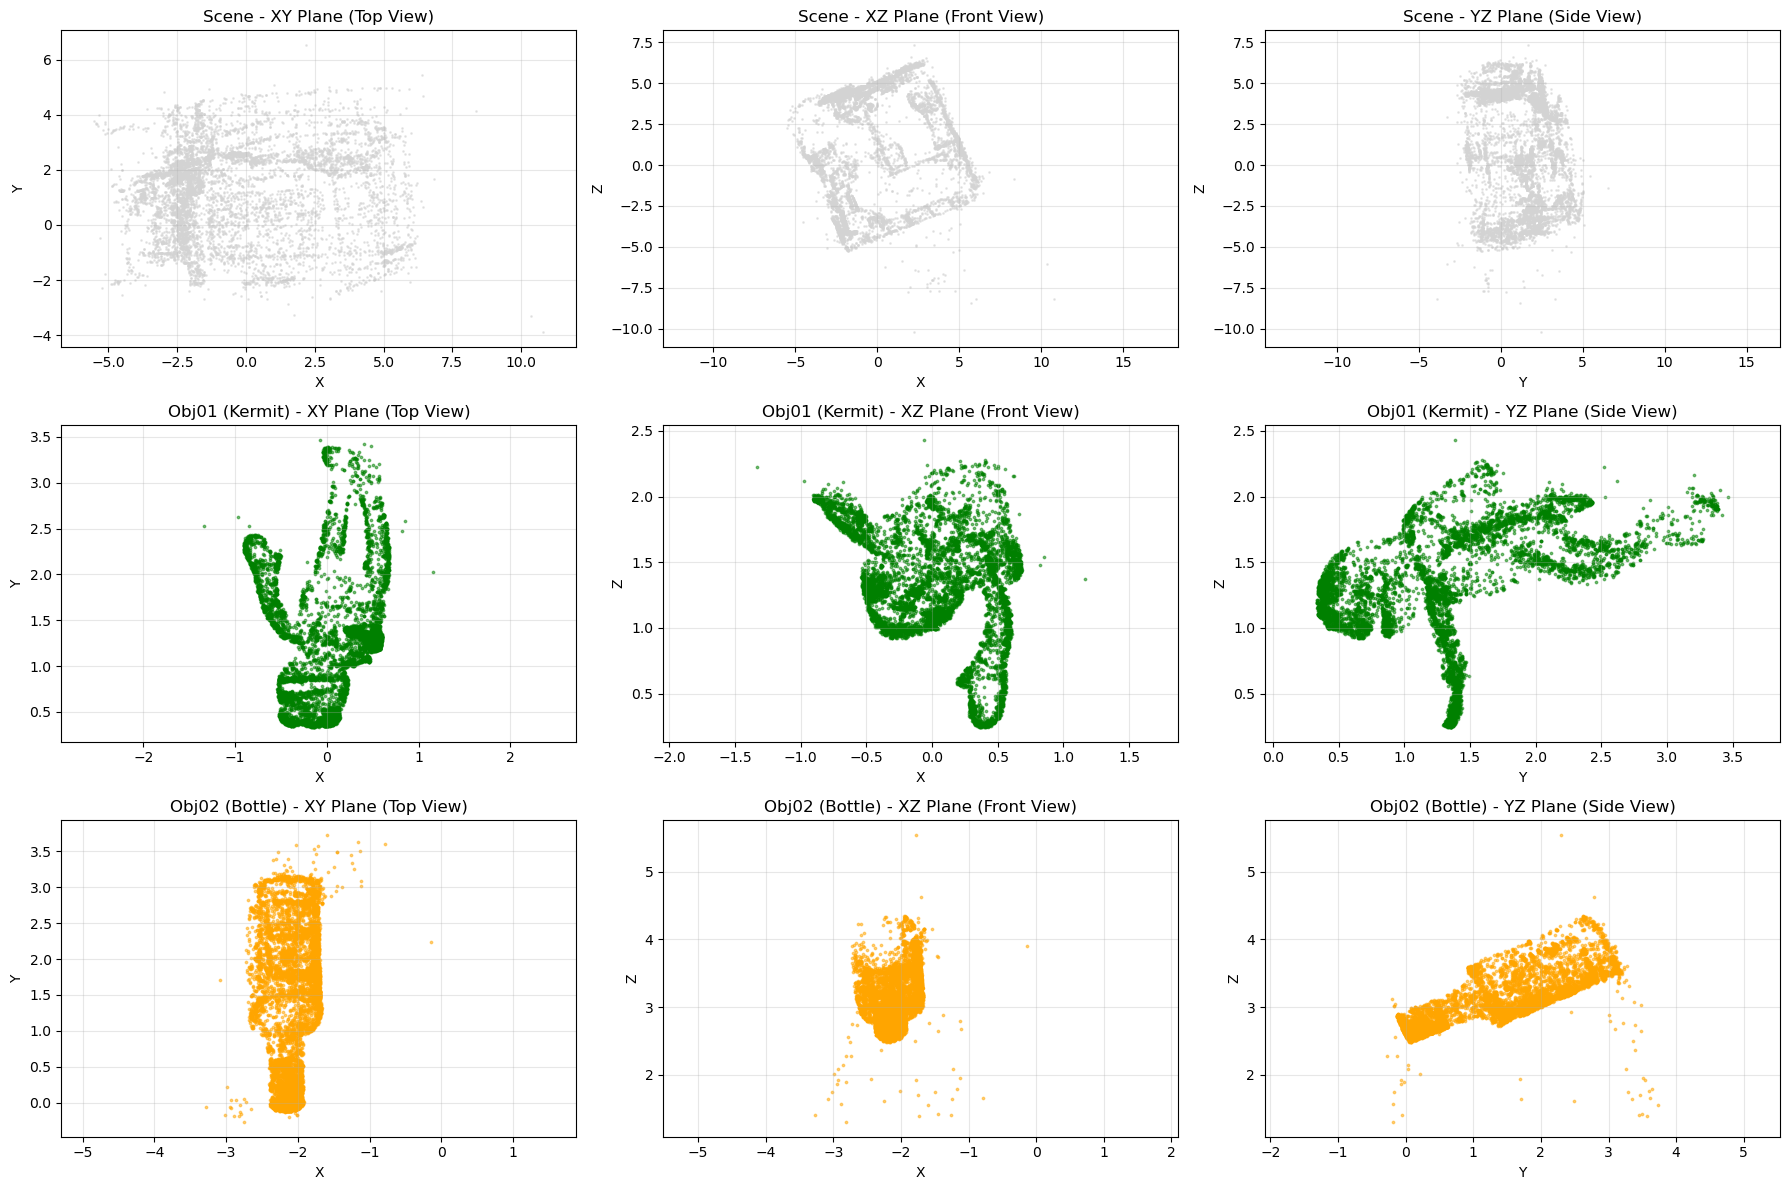


Saved: data/mv_demo/20251209_081245/keyframes/initial_ply_inspection.png

[OK] Initial PLY inspection complete


In [5]:
# Cell 1.3: Visualize and Inspect Loaded PLY Files

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

print("="*70)
print("PLY FILE INSPECTION")
print("="*70)

# =============================================================================
# Statistics
# =============================================================================

datasets = {
    "Scene": scene_gaussians,
    "Obj01 (Kermit)": obj01_gaussians,
    "Obj02 (Bottle)": obj02_gaussians,
}

for name, gaussians in datasets.items():
    xyz = gaussians['xyz']
    center = xyz.mean(axis=0)
    extent = xyz.max(axis=0) - xyz.min(axis=0)
    
    print(f"\n{name}:")
    print(f"  Points: {len(xyz):,}")
    print(f"  Center: [{center[0]:.3f}, {center[1]:.3f}, {center[2]:.3f}]")
    print(f"  X: [{xyz[:, 0].min():.2f}, {xyz[:, 0].max():.2f}] → span {extent[0]:.2f}")
    print(f"  Y: [{xyz[:, 1].min():.2f}, {xyz[:, 1].max():.2f}] → span {extent[1]:.2f}")
    print(f"  Z: [{xyz[:, 2].min():.2f}, {xyz[:, 2].max():.2f}] → span {extent[2]:.2f}")

# =============================================================================
# Visualization
# =============================================================================

fig = plt.figure(figsize=(18, 12))

viz_data = [
    ("Scene", scene_gaussians, 'lightgray', 1),
    ("Obj01 (Kermit)", obj01_gaussians, 'green', 3),
    ("Obj02 (Bottle)", obj02_gaussians, 'orange', 3),
]

for row_idx, (name, gaussians, color, point_size) in enumerate(viz_data):
    xyz = gaussians['xyz']
    sample_idx = np.random.choice(len(xyz), min(8000, len(xyz)), replace=False)
    
    # XY plane
    ax1 = fig.add_subplot(3, 3, row_idx * 3 + 1)
    ax1.scatter(xyz[sample_idx, 0], xyz[sample_idx, 1], s=point_size, alpha=0.5, c=color)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_title(f'{name} - XY Plane (Top View)')
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    
    # XZ plane
    ax2 = fig.add_subplot(3, 3, row_idx * 3 + 2)
    ax2.scatter(xyz[sample_idx, 0], xyz[sample_idx, 2], s=point_size, alpha=0.5, c=color)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Z')
    ax2.set_title(f'{name} - XZ Plane (Front View)')
    ax2.grid(True, alpha=0.3)
    ax2.axis('equal')
    
    # YZ plane
    ax3 = fig.add_subplot(3, 3, row_idx * 3 + 3)
    ax3.scatter(xyz[sample_idx, 1], xyz[sample_idx, 2], s=point_size, alpha=0.5, c=color)
    ax3.set_xlabel('Y')
    ax3.set_ylabel('Z')
    ax3.set_title(f'{name} - YZ Plane (Side View)')
    ax3.grid(True, alpha=0.3)
    ax3.axis('equal')

plt.tight_layout()
plt.savefig(KEYFRAMES_DIR / "initial_ply_inspection.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved: {KEYFRAMES_DIR / 'initial_ply_inspection.png'}")
print("\n[OK] Initial PLY inspection complete")

In [6]:
# Cell 1.4: Visualization Helper Functions

print("="*70)
print("VISUALIZATION HELPER FUNCTIONS")
print("="*70)

# =============================================================================
# Function 1: 3-Plane Visualization (XY, XZ, YZ)
# =============================================================================

def visualize_3planes(
    datasets: dict,
    title: str = "PLY Visualization",
    save_path: Path = None,
    figsize: tuple = (18, 12)
):
    """
    Visualize multiple point clouds in 3 orthogonal planes (XY, XZ, YZ).
    
    Args:
        datasets: dict of {name: (gaussians, color, point_size)}
                  e.g., {"Scene": (scene_gaussians, 'gray', 1)}
        title: Overall title for the figure
        save_path: Path to save the figure (optional)
        figsize: Figure size (width, height)
    
    Example:
        visualize_3planes({
            "Scene": (scene_gaussians, 'lightgray', 1),
            "Kermit": (obj01_gaussians, 'green', 3),
            "Bottle": (obj02_gaussians, 'orange', 3)
        }, title="Original PLY Files")
    """
    fig = plt.figure(figsize=figsize)
    
    items = list(datasets.items())
    n_rows = len(items)
    
    for row_idx, (name, (gaussians, color, point_size)) in enumerate(items):
        xyz = gaussians['xyz']
        sample_idx = np.random.choice(len(xyz), min(8000, len(xyz)), replace=False)
        
        # XY plane
        ax1 = fig.add_subplot(n_rows, 3, row_idx * 3 + 1)
        ax1.scatter(xyz[sample_idx, 0], xyz[sample_idx, 1], 
                   s=point_size, alpha=0.5, c=color)
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_title(f'{name} - XY Plane (Top View)')
        ax1.grid(True, alpha=0.3)
        ax1.axis('equal')
        
        # XZ plane
        ax2 = fig.add_subplot(n_rows, 3, row_idx * 3 + 2)
        ax2.scatter(xyz[sample_idx, 0], xyz[sample_idx, 2], 
                   s=point_size, alpha=0.5, c=color)
        ax2.set_xlabel('X')
        ax2.set_ylabel('Z')
        ax2.set_title(f'{name} - XZ Plane (Front View)')
        ax2.grid(True, alpha=0.3)
        ax2.axis('equal')
        
        # YZ plane
        ax3 = fig.add_subplot(n_rows, 3, row_idx * 3 + 3)
        ax3.scatter(xyz[sample_idx, 1], xyz[sample_idx, 2], 
                   s=point_size, alpha=0.5, c=color)
        ax3.set_xlabel('Y')
        ax3.set_ylabel('Z')
        ax3.set_title(f'{name} - YZ Plane (Side View)')
        ax3.grid(True, alpha=0.3)
        ax3.axis('equal')
    
    fig.suptitle(title, fontsize=14, y=0.995)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"  Saved: {save_path}")
    
    plt.show()


# =============================================================================
# Function 2: 3D Interactive Visualization
# =============================================================================

def visualize_3d(
    datasets: dict,
    title: str = "3D Visualization",
    save_path: Path = None,
    figsize: tuple = (12, 10),
    show_axes: bool = True,
    axis_length: float = 2.0
):
    """
    Visualize multiple point clouds in 3D space with coordinate axes.
    
    Args:
        datasets: dict of {name: (gaussians, color, point_size, alpha)}
                  e.g., {"Scene": (scene_gaussians, 'gray', 1, 0.2)}
        title: Title for the 3D plot
        save_path: Path to save the figure (optional)
        figsize: Figure size (width, height)
        show_axes: Whether to show coordinate axes (RGB arrows)
        axis_length: Length of coordinate axes
    
    Example:
        visualize_3d({
            "Scene": (scene_gaussians, 'lightgray', 1, 0.2),
            "Kermit": (obj01_gaussians, 'green', 3, 0.6),
            "Bottle": (obj02_gaussians, 'orange', 3, 0.6)
        }, title="Aligned 3D View")
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    for name, (gaussians, color, point_size, alpha) in datasets.items():
        xyz = gaussians['xyz']
        
        # Sample for performance
        if len(xyz) > 5000:
            sample_idx = np.random.choice(len(xyz), 5000, replace=False)
            xyz = xyz[sample_idx]
        
        ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
                  s=point_size, alpha=alpha, c=color, label=name)
    
    # Draw coordinate axes
    if show_axes:
        origin = np.zeros(3)
        ax.quiver(*origin, axis_length, 0, 0, 
                 color='red', arrow_length_ratio=0.2, linewidth=2, label='X')
        ax.quiver(*origin, 0, axis_length, 0, 
                 color='green', arrow_length_ratio=0.2, linewidth=2, label='Y')
        ax.quiver(*origin, 0, 0, axis_length, 
                 color='blue', arrow_length_ratio=0.2, linewidth=2, label='Z')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"  Saved: {save_path}")
    
    plt.show()


# =============================================================================
# Function 3: Before/After Comparison (Side-by-side 3D)
# =============================================================================

def visualize_before_after_3d(
    datasets_before: dict,
    datasets_after: dict,
    title_before: str = "BEFORE",
    title_after: str = "AFTER",
    save_path: Path = None,
    figsize: tuple = (18, 8),
    axis_length: float = 2.0
):
    """
    Show before/after comparison in 3D side-by-side.
    
    Args:
        datasets_before: dict of {name: (gaussians, color, point_size, alpha)}
        datasets_after: dict of {name: (gaussians, color, point_size, alpha)}
        title_before: Title for left plot
        title_after: Title for right plot
        save_path: Path to save the figure (optional)
        figsize: Figure size (width, height)
        axis_length: Length of coordinate axes
    
    Example:
        visualize_before_after_3d(
            datasets_before={
                "Scene": (scene_gaussians, 'lightgray', 1, 0.2),
                "Bottle": (obj02_gaussians, 'orange', 3, 0.6)
            },
            datasets_after={
                "Scene": (scene_gaussians_aligned, 'lightgray', 1, 0.2),
                "Bottle": (obj02_gaussians_aligned, 'orange', 3, 0.6)
            }
        )
    """
    fig = plt.figure(figsize=figsize)
    
    # BEFORE
    ax1 = fig.add_subplot(121, projection='3d')
    for name, (gaussians, color, point_size, alpha) in datasets_before.items():
        xyz = gaussians['xyz']
        if len(xyz) > 5000:
            sample_idx = np.random.choice(len(xyz), 5000, replace=False)
            xyz = xyz[sample_idx]
        ax1.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
                   s=point_size, alpha=alpha, c=color, label=name)
    
    origin = np.zeros(3)
    ax1.quiver(*origin, axis_length, 0, 0, color='red', arrow_length_ratio=0.2, linewidth=2)
    ax1.quiver(*origin, 0, axis_length, 0, color='green', arrow_length_ratio=0.2, linewidth=2)
    ax1.quiver(*origin, 0, 0, axis_length, color='blue', arrow_length_ratio=0.2, linewidth=2)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title(title_before)
    ax1.legend(loc='upper right')
    
    # AFTER
    ax2 = fig.add_subplot(122, projection='3d')
    for name, (gaussians, color, point_size, alpha) in datasets_after.items():
        xyz = gaussians['xyz']
        if len(xyz) > 5000:
            sample_idx = np.random.choice(len(xyz), 5000, replace=False)
            xyz = xyz[sample_idx]
        ax2.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
                   s=point_size, alpha=alpha, c=color, label=name)
    
    ax2.quiver(*origin, axis_length, 0, 0, color='red', arrow_length_ratio=0.2, linewidth=2)
    ax2.quiver(*origin, 0, axis_length, 0, color='green', arrow_length_ratio=0.2, linewidth=2)
    ax2.quiver(*origin, 0, 0, axis_length, color='blue', arrow_length_ratio=0.2, linewidth=2)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.set_title(title_after)
    ax2.legend(loc='upper right')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"  Saved: {save_path}")
    
    plt.show()


# =============================================================================
# Function 4: Print Statistics
# =============================================================================

def print_gaussian_stats(datasets: dict, title: str = "STATISTICS"):
    """
    Print statistics for multiple Gaussian datasets.
    
    Args:
        datasets: dict of {name: gaussians}
        title: Title for the statistics output
    
    Example:
        print_gaussian_stats({
            "Scene": scene_gaussians,
            "Kermit": obj01_gaussians,
            "Bottle": obj02_gaussians
        })
    """
    print("="*70)
    print(title)
    print("="*70)
    
    for name, gaussians in datasets.items():
        xyz = gaussians['xyz']
        center = xyz.mean(axis=0)
        extent = xyz.max(axis=0) - xyz.min(axis=0)
        
        print(f"\n{name}:")
        print(f"  Points: {len(xyz):,}")
        print(f"  Center: [{center[0]:.3f}, {center[1]:.3f}, {center[2]:.3f}]")
        print(f"  X: [{xyz[:, 0].min():.2f}, {xyz[:, 0].max():.2f}] → span {extent[0]:.2f}")
        print(f"  Y: [{xyz[:, 1].min():.2f}, {xyz[:, 1].max():.2f}] → span {extent[1]:.2f}")
        print(f"  Z: [{xyz[:, 2].min():.2f}, {xyz[:, 2].max():.2f}] → span {extent[2]:.2f}")


print("\n[OK] Visualization helper functions defined:")
print("  • visualize_3planes() - 3x3 orthogonal plane views")
print("  • visualize_3d() - Single 3D interactive view")
print("  • visualize_before_after_3d() - Side-by-side comparison")
print("  • print_gaussian_stats() - Print point cloud statistics")

def compute_bbox_and_span(gaussians: dict, name: str = "Object") -> dict:
    """
    Gaussian point cloud의 bounding box와 span 계산
    
    Args:
        gaussians: Gaussian dictionary
        name: Object name for printing
    
    Returns:
        dict with keys: min, max, center, span, name
    """
    xyz = gaussians['xyz']
    
    bbox = {
        'name': name,
        'min': xyz.min(axis=0),
        'max': xyz.max(axis=0),
        'center': xyz.mean(axis=0),
        'span': xyz.max(axis=0) - xyz.min(axis=0),
        'n_points': len(xyz)
    }
    
    return bbox

def print_bbox_stats(bbox_dict: dict):
    """
    Print bounding box statistics in a formatted way
    
    Args:
        bbox_dict: Dictionary from compute_bbox_and_span()
    """
    name = bbox_dict['name']
    min_xyz = bbox_dict['min']
    max_xyz = bbox_dict['max']
    span = bbox_dict['span']
    center = bbox_dict['center']
    
    print(f"\n{name}:")
    print(f"  Points: {bbox_dict['n_points']:,}")
    print(f"  Center: [{center[0]:7.3f}, {center[1]:7.3f}, {center[2]:7.3f}]")
    print(f"  X: [{min_xyz[0]:7.3f}, {max_xyz[0]:7.3f}] → span {span[0]:6.3f}")
    print(f"  Y: [{min_xyz[1]:7.3f}, {max_xyz[1]:7.3f}] → span {span[1]:6.3f}")
    print(f"  Z: [{min_xyz[2]:7.3f}, {max_xyz[2]:7.3f}] → span {span[2]:6.3f}")

def compute_z_offset_to_ground(gaussians_list: list, margin: float = 0.0) -> float:
    """
    모든 object의 최소 Z값을 찾아서 바닥을 Z=0으로 만드는 offset 계산
    
    Args:
        gaussians_list: List of gaussian dictionaries
        margin: Additional margin above Z=0 (default: 0.0)
    
    Returns:
        z_offset: Translation to apply (always positive to move up)
    """
    z_min_global = min([g['xyz'][:, 2].min() for g in gaussians_list])
    z_offset = -z_min_global + margin
    
    print(f"\nZ-Offset Calculation:")
    print(f"  Global Z min: {z_min_global:.3f}")
    print(f"  Margin: {margin:.3f}")
    print(f"  Required offset: {z_offset:.3f} (move everything UP)")
    
    return z_offset

print("[OK] Bounding box helper functions added")

# =============================================================================
# Function 5: Export Gaussians to PLY
# =============================================================================

def save_gaussian_ply(gaussians: Dict[str, np.ndarray], output_path: Path):
    """
    Save Gaussian parameters to PLY file for viewing in external tools.
    
    Args:
        gaussians: Dictionary with Gaussian parameters
        output_path: Path to save the PLY file
    
    Example:
        save_gaussian_ply(scene_gaussians_aligned, 
                         KEYFRAMES_DIR / "scene_aligned.ply")
    """
    from plyfile import PlyData, PlyElement
    
    xyz = gaussians['xyz']
    n_points = len(xyz)
    
    # Prepare data arrays
    opacities = gaussians['opacities'].squeeze()
    scales = gaussians['scales']
    rotations = gaussians['rotations']
    features_dc = gaussians['features_dc']
    features_rest = gaussians['features_rest']
    
    # Create structured array for PLY
    dtype_list = [
        ('x', 'f4'), ('y', 'f4'), ('z', 'f4'),
        ('opacity', 'f4'),
    ]
    
    # Add scale attributes
    for i in range(scales.shape[1]):
        dtype_list.append((f'scale_{i}', 'f4'))
    
    # Add rotation attributes
    for i in range(rotations.shape[1]):
        dtype_list.append((f'rot_{i}', 'f4'))
    
    # Add DC features
    for i in range(features_dc.shape[1]):
        dtype_list.append((f'f_dc_{i}', 'f4'))
    
    # Add rest features
    for i in range(features_rest.shape[1]):
        dtype_list.append((f'f_rest_{i}', 'f4'))
    
    # Create vertex array
    vertex_data = np.zeros(n_points, dtype=dtype_list)
    
    # Fill data
    vertex_data['x'] = xyz[:, 0]
    vertex_data['y'] = xyz[:, 1]
    vertex_data['z'] = xyz[:, 2]
    vertex_data['opacity'] = opacities
    
    for i in range(scales.shape[1]):
        vertex_data[f'scale_{i}'] = scales[:, i]
    
    for i in range(rotations.shape[1]):
        vertex_data[f'rot_{i}'] = rotations[:, i]
    
    for i in range(features_dc.shape[1]):
        vertex_data[f'f_dc_{i}'] = features_dc[:, i]
    
    for i in range(features_rest.shape[1]):
        vertex_data[f'f_rest_{i}'] = features_rest[:, i]
    
    # Create PLY element
    vertex_element = PlyElement.describe(vertex_data, 'vertex')
    
    # Write PLY file
    PlyData([vertex_element]).write(str(output_path))
    
    file_size_mb = output_path.stat().st_size / (1024 * 1024)
    print(f"  ✓ Saved: {output_path.name}")
    print(f"    Points: {n_points:,} | Size: {file_size_mb:.2f} MB")


def merge_and_save_gaussians(
    gaussians_dict: Dict[str, Dict[str, np.ndarray]], 
    output_path: Path,
    verbose: bool = True
):
    """
    Merge multiple Gaussian datasets into a single PLY file.
    
    Args:
        gaussians_dict: Dictionary of {name: gaussians_data}
                       e.g., {"scene": scene_gaussians, "obj01": obj01_gaussians}
        output_path: Path to save the merged PLY file
        verbose: Print statistics
    
    Example:
        merge_and_save_gaussians({
            "scene": scene_gaussians_aligned,
            "obj01": obj01_gaussians_aligned,
            "obj02": obj02_gaussians_aligned
        }, KEYFRAMES_DIR / "merged_aligned.ply")
    """
    if verbose:
        print(f"\n{'='*70}")
        print("MERGING GAUSSIANS")
        print(f"{'='*70}")
    
    # Concatenate all arrays
    all_xyz = []
    all_opacities = []
    all_scales = []
    all_rotations = []
    all_features_dc = []
    all_features_rest = []
    
    for name, gaussians in gaussians_dict.items():
        n = len(gaussians['xyz'])
        all_xyz.append(gaussians['xyz'])
        all_opacities.append(gaussians['opacities'])
        all_scales.append(gaussians['scales'])
        all_rotations.append(gaussians['rotations'])
        all_features_dc.append(gaussians['features_dc'])
        all_features_rest.append(gaussians['features_rest'])
        
        if verbose:
            print(f"  {name}: {n:,} points")
    
    # Merge
    merged_gaussians = {
        'xyz': np.vstack(all_xyz),
        'opacities': np.vstack(all_opacities),
        'scales': np.vstack(all_scales),
        'rotations': np.vstack(all_rotations),
        'features_dc': np.vstack(all_features_dc),
        'features_rest': np.vstack(all_features_rest),
    }
    
    total_points = len(merged_gaussians['xyz'])
    
    if verbose:
        print(f"\nTotal merged points: {total_points:,}")
        print(f"\nSaving to: {output_path}")
    
    # Save merged PLY
    save_gaussian_ply(merged_gaussians, output_path)
    
    if verbose:
        print(f"\n[OK] Merged PLY saved")
        print(f"    View online: https://antimatter15.com/splat/")
    
    return merged_gaussians


print("\n[OK] PLY export functions added:")
print("  • save_gaussian_ply() - Export single Gaussian dataset to PLY")
print("  • merge_and_save_gaussians() - Merge multiple datasets and save as single PLY")

VISUALIZATION HELPER FUNCTIONS

[OK] Visualization helper functions defined:
  • visualize_3planes() - 3x3 orthogonal plane views
  • visualize_3d() - Single 3D interactive view
  • visualize_before_after_3d() - Side-by-side comparison
  • print_gaussian_stats() - Print point cloud statistics
[OK] Bounding box helper functions added

[OK] PLY export functions added:
  • save_gaussian_ply() - Export single Gaussian dataset to PLY
  • merge_and_save_gaussians() - Merge multiple datasets and save as single PLY


---
# Part 2: Step 1 - 좌표계 정렬 (Coordinate Alignment)

In [7]:
# Cell 2.1: Transformation Utility Functions

def axis_angle_to_quaternion(axis: np.ndarray, angle: float) -> np.ndarray:
    """
    Convert axis-angle to quaternion [w, x, y, z].
    
    Args:
        axis: 3D unit vector
        angle: rotation angle in radians
    """
    axis = axis / np.linalg.norm(axis)
    half_angle = angle / 2
    w = np.cos(half_angle)
    xyz = axis * np.sin(half_angle)
    return np.array([w, xyz[0], xyz[1], xyz[2]], dtype=np.float32)

def quaternion_multiply(q1: np.ndarray, q2: np.ndarray) -> np.ndarray:
    """
    Multiply two quaternions [w, x, y, z].
    """
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return np.array([
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ], dtype=np.float32)

def rotate_points(points: np.ndarray, quat: np.ndarray) -> np.ndarray:
    """
    Rotate points using quaternion.
    """
    from scipy.spatial.transform import Rotation
    # quaternion [w, x, y, z] -> scipy uses [x, y, z, w]
    r = Rotation.from_quat([quat[1], quat[2], quat[3], quat[0]])
    return r.apply(points).astype(np.float32)

def transform_gaussians_legacy(
    gaussians: Dict[str, np.ndarray],
    translation: np.ndarray = None,
    rotation_quat: np.ndarray = None,
    scale: float = 1.0
) -> Dict[str, np.ndarray]:
    """
    Apply transformation to Gaussian parameters.
    
    Args:
        gaussians: Dictionary with Gaussian parameters
        translation: 3D translation vector
        rotation_quat: Rotation quaternion [w, x, y, z]
        scale: Uniform scale factor
    """
    result = {k: v.copy() for k, v in gaussians.items()}
    
    # Apply rotation
    if rotation_quat is not None:
        result['xyz'] = rotate_points(result['xyz'], rotation_quat)
        # Rotate Gaussian rotations
        for i in range(len(result['rotations'])):
            result['rotations'][i] = quaternion_multiply(rotation_quat, result['rotations'][i])
    
    # Apply scale
    if scale != 1.0:
        result['xyz'] *= scale
        result['scales'] += np.log(scale)  # Scales are in log-space
    
    # Apply translation
    if translation is not None:
        result['xyz'] += translation
    
    return result

print("[OK] Transformation functions defined")

# Cell 2.1.1: Fixed Transformation Function (Replace original)

def transform_gaussians(
    gaussians: Dict[str, np.ndarray],
    translation: np.ndarray = None,
    rotation_quat: np.ndarray = None,
    scale: float = 1.0,
    rotation_center: np.ndarray = None  # NEW: 회전 중심 지정 가능
) -> Dict[str, np.ndarray]:
    """
    Apply transformation to Gaussian parameters.
    
    TRANSFORMATION ORDER:
    1. Translation (move to target position)
    2. Scale (scale at target position)
    3. Rotation (rotate around target position center)
    
    Args:
        gaussians: Dictionary with Gaussian parameters
        translation: 3D translation vector
        rotation_quat: Rotation quaternion [w, x, y, z]
        scale: Uniform scale factor
        rotation_center: Center point for rotation (default: after translation)
    """
    result = {k: v.copy() for k, v in gaussians.items()}
    
    # Step 1: Apply translation FIRST
    if translation is not None:
        result['xyz'] += translation
    
    # Step 2: Apply scale (at current position)
    if scale != 1.0:
        # If we have a rotation center, scale around it
        # Otherwise scale around current center
        if rotation_center is not None:
            center = rotation_center
        elif translation is not None:
            center = translation
        else:
            center = result['xyz'].mean(axis=0)
        
        result['xyz'] = (result['xyz'] - center) * scale + center
        result['scales'] += np.log(scale)  # Scales are in log-space
    
    # Step 3: Apply rotation (around current position)
    if rotation_quat is not None:
        # Rotate around center (after translation)
        if rotation_center is not None:
            center = rotation_center
        elif translation is not None:
            center = translation
        else:
            center = result['xyz'].mean(axis=0)
        
        # Rotate points around center
        result['xyz'] = rotate_points(result['xyz'] - center, rotation_quat) + center
        
        # Rotate Gaussian rotations
        for i in range(len(result['rotations'])):
            result['rotations'][i] = quaternion_multiply(rotation_quat, result['rotations'][i])
    
    return result

print("[OK] FIXED transformation function defined")
print("  → Transformation order: Translation → Scale → Rotation")
print("  → Rotation now happens around object's position, not world origin")

[OK] Transformation functions defined
[OK] FIXED transformation function defined
  → Transformation order: Translation → Scale → Rotation
  → Rotation now happens around object's position, not world origin


In [8]:
# Cell 2.2: Align World Coordinate System (Rotation + Z Offset)

print("\n" + "="*70)
print("STEP 1: WORLD COORDINATE ALIGNMENT (ROTATION + Z OFFSET)")
print("="*70)

# =============================================================================
# Two-Step Rotation: -Y → +Z, then flip bottle direction
# =============================================================================
# Step 1: Rotate -Y axis to +Z axis (90° around X)
# Step 2: Flip bottle to point upward (180° around Y)

print("\n[1] Computing two-step rotation...")
print("  Step 1: Rotate -Y → +Z (90° around X axis)")
print("  Step 2: Flip bottle upward (180° around Y axis)")
print("  Result: Bottle stands upright pointing +Z")

# Step 1: 90° rotation around X axis (-Y → +Z)
rotation_angle_1 = np.pi / 2  # 90 degrees
rotation_axis_1 = np.array([1.0, 0.0, 0.0], dtype=np.float32)  # X axis
quat_1 = axis_angle_to_quaternion(rotation_axis_1, rotation_angle_1)

# Step 2: 180° rotation around Y axis (flip bottle direction)
rotation_angle_2 = np.pi  # 180 degrees
rotation_axis_2 = np.array([0.0, 1.0, 0.0], dtype=np.float32)  # Y axis
quat_2 = axis_angle_to_quaternion(rotation_axis_2, rotation_angle_2)

# Combine rotations: quat_2 * quat_1 (apply quat_1 first, then quat_2)
world_rotation_quat = quaternion_multiply(quat_2, quat_1)

print(f"  Combined rotation quaternion: [{world_rotation_quat[0]:.4f}, {world_rotation_quat[1]:.4f}, {world_rotation_quat[2]:.4f}, {world_rotation_quat[3]:.4f}]")

# Step 2.5: Additional rotation around Z axis (30° clockwise in XY plane)
rotation_angle_3 = -np.pi / 9  # -20 degrees (clockwise)
rotation_axis_3 = np.array([0.0, 0.0, 1.0], dtype=np.float32)  # Z axis
quat_3 = axis_angle_to_quaternion(rotation_axis_3, rotation_angle_3)

# Combine with previous rotation: quat_3 * world_rotation_quat
world_rotation_quat = quaternion_multiply(quat_3, world_rotation_quat)

print(f"  Step 3: Rotate 30° clockwise in XY plane (around Z axis)")
print(f"  Final rotation quaternion: [{world_rotation_quat[0]:.4f}, {world_rotation_quat[1]:.4f}, {world_rotation_quat[2]:.4f}, {world_rotation_quat[3]:.4f}]")

# Step 2.6: Additional rotation around X axis (10° counter-clockwise in YZ plane)
rotation_angle_4 = np.pi / 18  # +10 degrees (counter-clockwise)
rotation_axis_4 = np.array([1.0, 0.0, 0.0], dtype=np.float32)  # X axis
quat_4 = axis_angle_to_quaternion(rotation_axis_4, rotation_angle_4)

# Combine with previous rotation: quat_4 * world_rotation_quat
world_rotation_quat = quaternion_multiply(quat_4, world_rotation_quat)

print(f"  Step 4: Rotate 10° counter-clockwise in YZ plane (around X axis)")
print(f"  Final rotation quaternion: [{world_rotation_quat[0]:.4f}, {world_rotation_quat[1]:.4f}, {world_rotation_quat[2]:.4f}, {world_rotation_quat[3]:.4f}]")

# =============================================================================
# Step 3: Apply Rotation to All World Coordinates
# =============================================================================

print("\n[3] Applying rotation to scene and objects...")

scene_gaussians_rotated = transform_gaussians_legacy(
    scene_gaussians, 
    rotation_quat=world_rotation_quat
)
print(f"  ✓ Scene rotated ({len(scene_gaussians_rotated['xyz']):,} points)")

obj01_gaussians_rotated = transform_gaussians_legacy(
    obj01_gaussians, 
    rotation_quat=world_rotation_quat
)
print(f"  ✓ Obj01 (Kermit) rotated ({len(obj01_gaussians_rotated['xyz']):,} points)")

obj02_gaussians_rotated = transform_gaussians_legacy(
    obj02_gaussians, 
    rotation_quat=world_rotation_quat
)
print(f"  ✓ Obj02 (Bottle) rotated ({len(obj02_gaussians_rotated['xyz']):,} points)")

# =============================================================================
# Step 4: Apply Z Offset to Move Everything Above Ground (Z=0)
# =============================================================================

print("\n[4] Computing Z offset to ground level...")

# Find global minimum Z across all objects
z_min_scene = scene_gaussians_rotated['xyz'][:, 2].min()
z_min_obj01 = obj01_gaussians_rotated['xyz'][:, 2].min()
z_min_obj02 = obj02_gaussians_rotated['xyz'][:, 2].min()
z_min_global = min(z_min_scene, z_min_obj01, z_min_obj02)

# Compute offset to move minimum Z to 0
z_offset = 5
z_translation = np.array([0.0, 0.0, z_offset], dtype=np.float32)

print(f"  Global Z minimum: {z_min_global:.3f}")
print(f"  Z offset applied: +{z_offset:.3f}")
print(f"  New Z range will be: [0.0, {z_min_global + z_offset + (scene_gaussians_rotated['xyz'][:, 2].max() - z_min_global):.3f}]")

print("\n[5] Applying Z offset to all objects...")

scene_gaussians_aligned = transform_gaussians_legacy(
    scene_gaussians_rotated,
    translation=z_translation
)
print(f"  ✓ Scene translated")

obj01_gaussians_aligned = transform_gaussians_legacy(
    obj01_gaussians_rotated,
    translation=z_translation
)
print(f"  ✓ Obj01 (Kermit) translated")

obj02_gaussians_aligned = transform_gaussians_legacy(
    obj02_gaussians_rotated,
    translation=z_translation
)
print(f"  ✓ Obj02 (Bottle) translated")

# =============================================================================
# Step 6: Verification
# =============================================================================

print("\n[6] Verifying final alignment...")

# Check bottle orientation
bottle_xyz_aligned = obj02_gaussians_aligned['xyz']
z_min_bottle, z_max_bottle = bottle_xyz_aligned[:, 2].min(), bottle_xyz_aligned[:, 2].max()
z_span_bottle = z_max_bottle - z_min_bottle

print(f"  Bottle Z range: [{z_min_bottle:.2f}, {z_max_bottle:.2f}]")
print(f"  Bottle Z span: {z_span_bottle:.2f} (bottle height)")
print(f"  ✓ Bottle stands upright along +Z axis")

# Check global bounds
scene_xyz_aligned = scene_gaussians_aligned['xyz']
z_min_final = scene_xyz_aligned[:, 2].min()
z_max_final = scene_xyz_aligned[:, 2].max()

print(f"\n  Global Z range (after offset): [{z_min_final:.2f}, {z_max_final:.2f}]")
print(f"  ✓ All coordinates are now positive (Z >= 0)")

# =============================================================================
# Statistics
# =============================================================================

print("\n" + "="*70)
print("ALIGNMENT RESULTS (Rotation + Z Offset)")
print("="*70)

datasets = {
    "Scene": (scene_gaussians, scene_gaussians_aligned),
    "Obj01 (Kermit)": (obj01_gaussians, obj01_gaussians_aligned),
    "Obj02 (Bottle)": (obj02_gaussians, obj02_gaussians_aligned),
}

for name, (original, aligned) in datasets.items():
    xyz_orig = original['xyz']
    xyz_align = aligned['xyz']
    
    print(f"\n{name}:")
    print(f"  Original Z range: [{xyz_orig[:, 2].min():.2f}, {xyz_orig[:, 2].max():.2f}]")
    print(f"  After rotation:   [{xyz_align[:, 2].min() - z_offset:.2f}, {xyz_align[:, 2].max() - z_offset:.2f}]")
    print(f"  After Z offset:   [{xyz_align[:, 2].min():.2f}, {xyz_align[:, 2].max():.2f}]")

print("\n[OK] World coordinate system aligned:")
print("    → Rotation: Bottle stands upright along +Z axis")
print("    → Translation: Ground level at Z=0")
print("    → All objects share the same aligned coordinate system")


STEP 1: WORLD COORDINATE ALIGNMENT (ROTATION + Z OFFSET)

[1] Computing two-step rotation...
  Step 1: Rotate -Y → +Z (90° around X axis)
  Step 2: Flip bottle upward (180° around Y axis)
  Result: Bottle stands upright pointing +Z
  Combined rotation quaternion: [0.0000, 0.0000, 0.7071, -0.7071]
  Step 3: Rotate 30° clockwise in XY plane (around Z axis)
  Final rotation quaternion: [-0.1228, 0.1228, 0.6964, -0.6964]
  Step 4: Rotate 10° counter-clockwise in YZ plane (around X axis)
  Final rotation quaternion: [-0.1330, 0.1116, 0.7544, -0.6330]

[3] Applying rotation to scene and objects...
  ✓ Scene rotated (1,508,976 points)
  ✓ Obj01 (Kermit) rotated (108,077 points)
  ✓ Obj02 (Bottle) rotated (71,268 points)

[4] Computing Z offset to ground level...
  Global Z minimum: -10.598
  Z offset applied: +5.000
  New Z range will be: [0.0, 54.565]

[5] Applying Z offset to all objects...
  ✓ Scene translated
  ✓ Obj01 (Kermit) translated
  ✓ Obj02 (Bottle) translated

[6] Verifying fina

In [9]:
# Cell 2.31: Check for z span

print("="*70)
print("ALIGNED BOUNDING BOX CHECK")
print("="*70)

# Compute bounding boxes
bbox_scene = compute_bbox_and_span(scene_gaussians_aligned, "Scene")
bbox_kermit = compute_bbox_and_span(obj01_gaussians_aligned, "Obj01 (Kermit)")
bbox_bottle = compute_bbox_and_span(obj02_gaussians_aligned, "Obj02 (Bottle)")

# Print statistics
print_bbox_stats(bbox_scene)
print_bbox_stats(bbox_kermit)
print_bbox_stats(bbox_bottle)

# Find global bounds
all_gaussians = [scene_gaussians_aligned, obj01_gaussians_aligned, obj02_gaussians_aligned]
z_min_global = min([g['xyz'][:, 2].min() for g in all_gaussians])
z_max_global = max([g['xyz'][:, 2].max() for g in all_gaussians])

print("\n" + "-"*70)
print("GLOBAL BOUNDS:")
print(f"  Z range: [{z_min_global:.3f}, {z_max_global:.3f}]")
print(f"  Z span: {z_max_global - z_min_global:.3f}")

if z_min_global < 0:
    print(f"\n⚠️  Z minimum is negative ({z_min_global:.3f})")
    print(f"   Recommend applying Z offset: {-z_min_global:.3f}")
else:
    print(f"\n✓  Z minimum is positive, no offset needed")

ALIGNED BOUNDING BOX CHECK

Scene:
  Points: 1,508,976
  Center: [ -0.048,  -0.730,   3.645]
  X: [-43.211,  27.034] → span 70.245
  Y: [-18.859,  60.567] → span 79.425
  Z: [ -4.795,  54.565] → span 59.360

Obj01 (Kermit):
  Points: 108,077
  Center: [ -0.459,  -0.978,   3.505]
  X: [ -1.677,   1.582] → span  3.260
  Y: [ -2.129,   0.405] → span  2.534
  Z: [  1.254,   6.858] → span  5.605

Obj02 (Bottle):
  Points: 71,268
  Center: [  0.893,  -3.355,   3.010]
  X: [ -2.107,   3.989] → span  6.096
  Y: [ -5.400,   1.436] → span  6.836
  Z: [ -5.598,   5.034] → span 10.632

----------------------------------------------------------------------
GLOBAL BOUNDS:
  Z range: [-5.598, 54.565]
  Z span: 60.163

⚠️  Z minimum is negative (-5.598)
   Recommend applying Z offset: 5.598


ALIGNED RESULTS VISUALIZATION
ALIGNED PLY STATISTICS

Scene:
  Points: 1,508,976
  Center: [-0.048, -0.730, 3.645]
  X: [-43.21, 27.03] → span 70.25
  Y: [-18.86, 60.57] → span 79.43
  Z: [-4.80, 54.56] → span 59.36

Obj01 (Kermit):
  Points: 108,077
  Center: [-0.459, -0.978, 3.505]
  X: [-1.68, 1.58] → span 3.26
  Y: [-2.13, 0.41] → span 2.53
  Z: [1.25, 6.86] → span 5.60

Obj02 (Bottle):
  Points: 71,268
  Center: [0.893, -3.355, 3.010]
  X: [-2.11, 3.99] → span 6.10
  Y: [-5.40, 1.44] → span 6.84
  Z: [-5.60, 5.03] → span 10.63

3-PLANE VIEWS (XY, XZ, YZ)
  Saved: data/mv_demo/20251209_081245/keyframes/step1_aligned_3planes.png


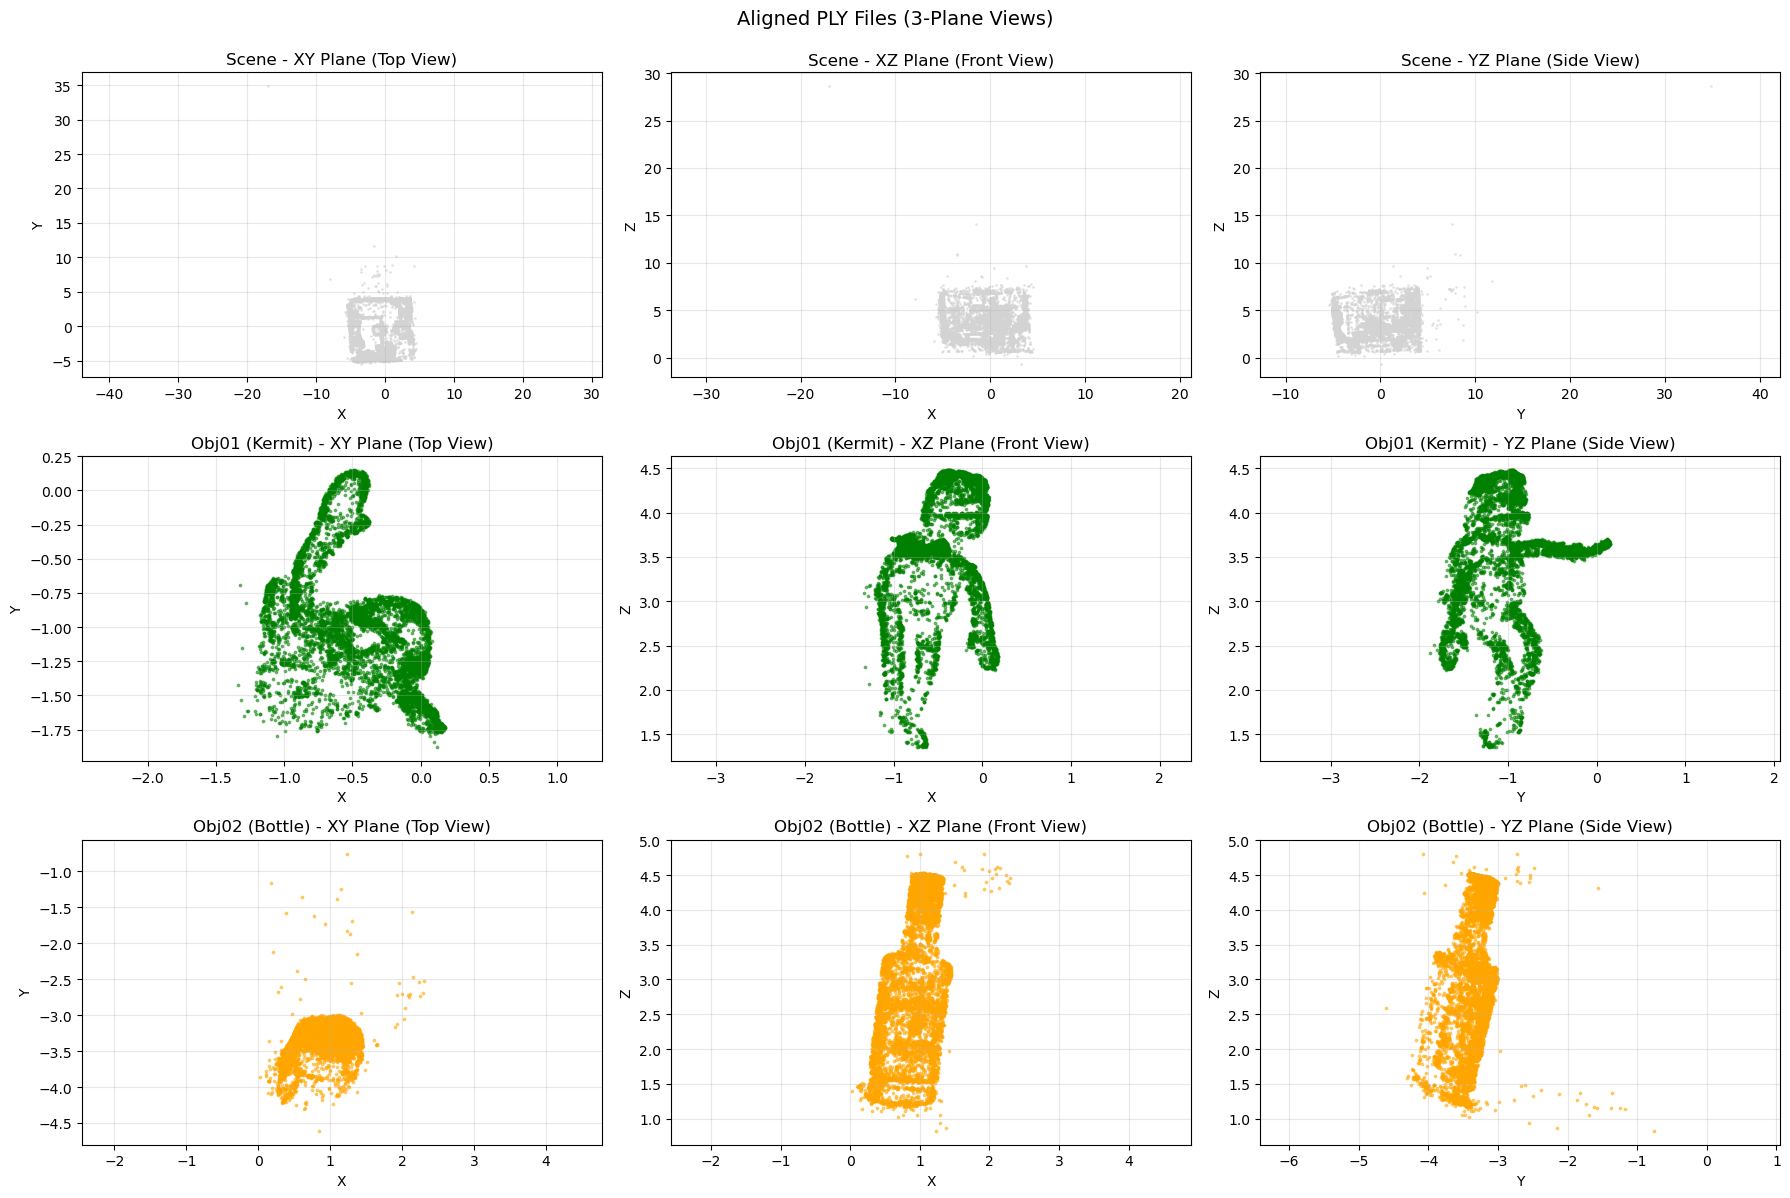


3D INTERACTIVE VIEW
  Saved: data/mv_demo/20251209_081245/keyframes/step1_aligned_3d.png


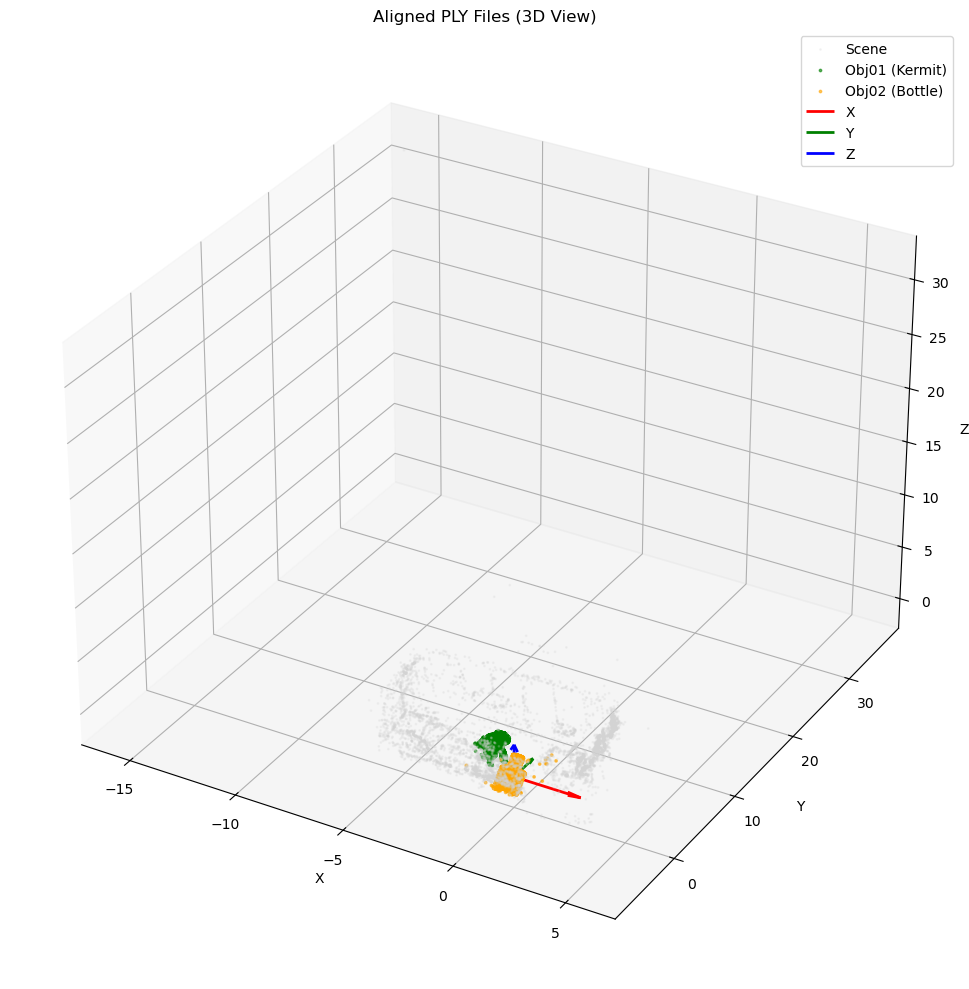


BEFORE/AFTER COMPARISON (3D)
  Saved: data/mv_demo/20251209_081245/keyframes/step1_before_after_comparison.png


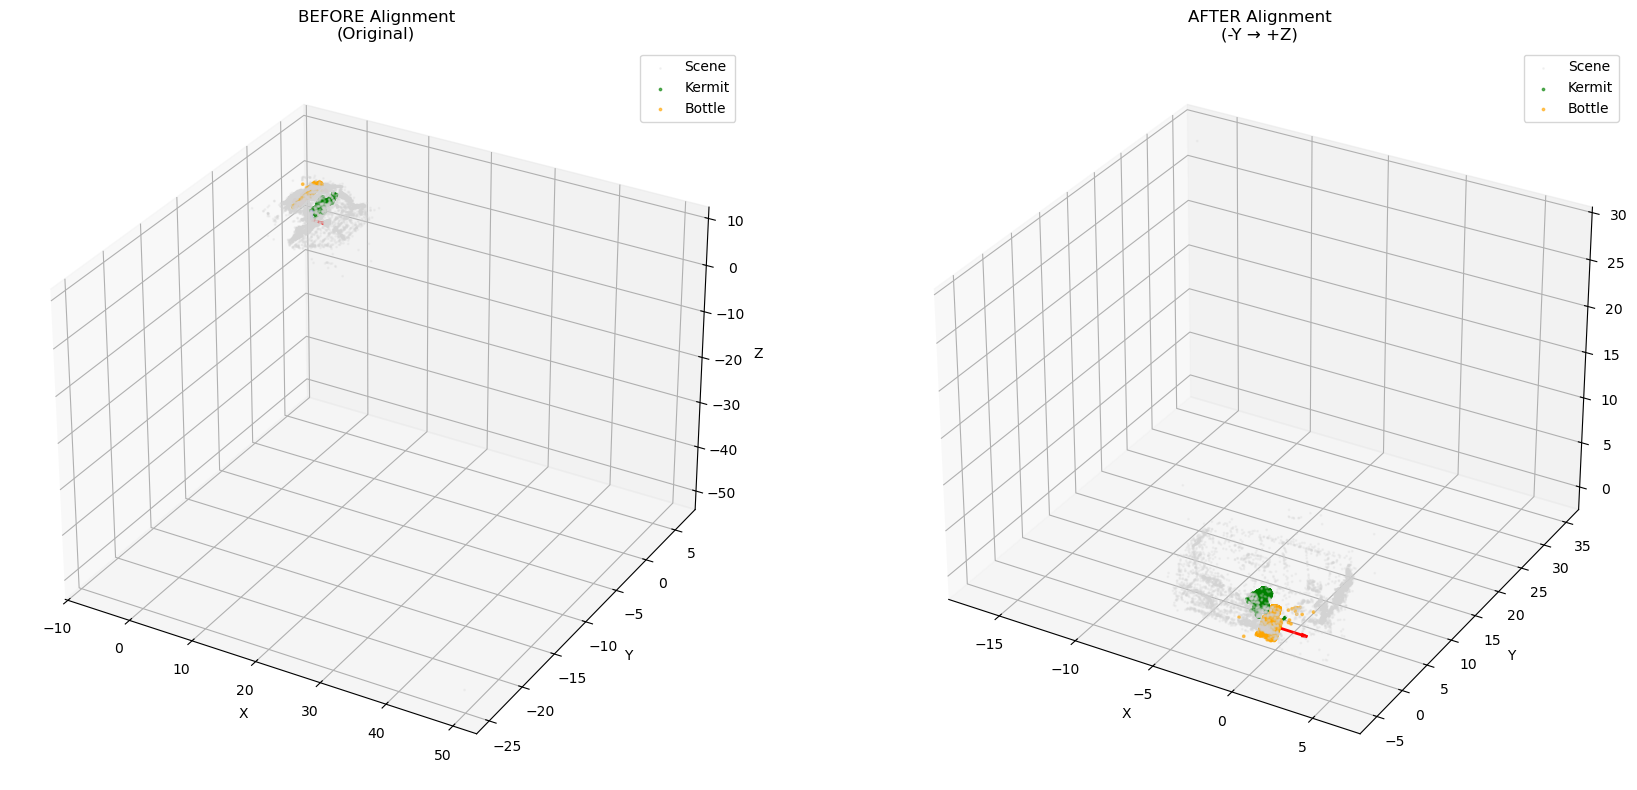


VISUALIZATION COMPLETE

✓ Check the following:
  1. Bottle stands upright along +Z axis (XZ, YZ, 3D views)
  2. Scene floor roughly parallel to XY plane
  3. Kermit sits naturally on the floor

💾 Saved files:
  • data/mv_demo/20251209_081245/keyframes/step1_aligned_3planes.png
  • data/mv_demo/20251209_081245/keyframes/step1_aligned_3d.png
  • data/mv_demo/20251209_081245/keyframes/step1_before_after_comparison.png


In [10]:
# Cell 2.32: Visualize Aligned Results

print("="*70)
print("ALIGNED RESULTS VISUALIZATION")
print("="*70)

# =============================================================================
# Statistics
# =============================================================================

print_gaussian_stats({
    "Scene": scene_gaussians_aligned,
    "Obj01 (Kermit)": obj01_gaussians_aligned,
    "Obj02 (Bottle)": obj02_gaussians_aligned
}, title="ALIGNED PLY STATISTICS")

# =============================================================================
# 3-Plane Visualization
# =============================================================================

print("\n" + "="*70)
print("3-PLANE VIEWS (XY, XZ, YZ)")
print("="*70)

visualize_3planes(
    datasets={
        "Scene": (scene_gaussians_aligned, 'lightgray', 1),
        "Obj01 (Kermit)": (obj01_gaussians_aligned, 'green', 3),
        "Obj02 (Bottle)": (obj02_gaussians_aligned, 'orange', 3)
    },
    title="Aligned PLY Files (3-Plane Views)",
    save_path=KEYFRAMES_DIR / "step1_aligned_3planes.png"
)

# =============================================================================
# 3D Visualization
# =============================================================================

print("\n" + "="*70)
print("3D INTERACTIVE VIEW")
print("="*70)

visualize_3d(
    datasets={
        "Scene": (scene_gaussians_aligned, 'lightgray', 1, 0.2),
        "Obj01 (Kermit)": (obj01_gaussians_aligned, 'green', 3, 0.6),
        "Obj02 (Bottle)": (obj02_gaussians_aligned, 'orange', 3, 0.6)
    },
    title="Aligned PLY Files (3D View)",
    save_path=KEYFRAMES_DIR / "step1_aligned_3d.png",
    show_axes=True,
    axis_length=3.0
)

# =============================================================================
# Before/After Comparison
# =============================================================================

print("\n" + "="*70)
print("BEFORE/AFTER COMPARISON (3D)")
print("="*70)

visualize_before_after_3d(
    datasets_before={
        "Scene": (scene_gaussians, 'lightgray', 1, 0.2),
        "Kermit": (obj01_gaussians, 'green', 3, 0.6),
        "Bottle": (obj02_gaussians, 'orange', 3, 0.6)
    },
    datasets_after={
        "Scene": (scene_gaussians_aligned, 'lightgray', 1, 0.2),
        "Kermit": (obj01_gaussians_aligned, 'green', 3, 0.6),
        "Bottle": (obj02_gaussians_aligned, 'orange', 3, 0.6)
    },
    title_before="BEFORE Alignment\n(Original)",
    title_after="AFTER Alignment\n(-Y → +Z)",
    save_path=KEYFRAMES_DIR / "step1_before_after_comparison.png"
)

print("\n" + "="*70)
print("VISUALIZATION COMPLETE")
print("="*70)
print("\n✓ Check the following:")
print("  1. Bottle stands upright along +Z axis (XZ, YZ, 3D views)")
print("  2. Scene floor roughly parallel to XY plane")
print("  3. Kermit sits naturally on the floor")
print("\n💾 Saved files:")
print(f"  • {KEYFRAMES_DIR / 'step1_aligned_3planes.png'}")
print(f"  • {KEYFRAMES_DIR / 'step1_aligned_3d.png'}")
print(f"  • {KEYFRAMES_DIR / 'step1_before_after_comparison.png'}")

In [45]:
# Cell 2.4: Export Aligned PLY Files for External Viewing

print("\n" + "="*70)
print("EXPORTING ALIGNED PLY FILES")
print("="*70)

# =============================================================================
# Individual PLY Files
# =============================================================================

print("\n[1] Exporting individual aligned PLY files...")

# Scene
scene_ply_path = KEYFRAMES_DIR / "aligned_scene.ply"
save_gaussian_ply(scene_gaussians_aligned, scene_ply_path)

# Obj01 (Kermit)
obj01_ply_path = KEYFRAMES_DIR / "aligned_obj01_kermit.ply"
save_gaussian_ply(obj01_gaussians_aligned, obj01_ply_path)

# Obj02 (Bottle)
obj02_ply_path = KEYFRAMES_DIR / "aligned_obj02_bottle.ply"
save_gaussian_ply(obj02_gaussians_aligned, obj02_ply_path)

# =============================================================================
# Merged PLY File (All in one)
# =============================================================================

print("\n[2] Creating merged PLY file (Scene + Objects)...")

merged_ply_path = KEYFRAMES_DIR / "aligned_merged_all.ply"
merged_gaussians = merge_and_save_gaussians(
    gaussians_dict={
        "scene": scene_gaussians_aligned,
        "obj01_kermit": obj01_gaussians_aligned,
        "obj02_bottle": obj02_gaussians_aligned
    },
    output_path=merged_ply_path,
    verbose=True
)

# =============================================================================
# Summary
# =============================================================================

print("\n" + "="*70)
print("EXPORT SUMMARY")
print("="*70)

print("\n📁 Individual PLY files:")
print(f"  - {scene_ply_path.name}")
print(f"  - {obj01_ply_path.name}")
print(f"  - {obj02_ply_path.name}")

print(f"\n📦 Merged PLY file:")
print(f"  - {merged_ply_path.name}")
print(f"    (Contains all objects in a single coordinate system)")

print(f"\n💡 View online:")
print(f"  1. Go to: https://antimatter15.com/splat/")
print(f"  2. Drag & drop any PLY file from: {KEYFRAMES_DIR}")
print(f"  3. Use mouse to rotate/zoom and verify alignment")

print("\n📍 File locations:")
print(f"  {KEYFRAMES_DIR.absolute()}")

print("\n[OK] All aligned PLY files exported")


EXPORTING ALIGNED PLY FILES

[1] Exporting individual aligned PLY files...
  ✓ Saved: aligned_scene.ply
    Points: 1,508,976 | Size: 339.62 MB
  ✓ Saved: aligned_obj01_kermit.ply
    Points: 108,077 | Size: 24.33 MB
  ✓ Saved: aligned_obj02_bottle.ply
    Points: 71,268 | Size: 16.04 MB

[2] Creating merged PLY file (Scene + Objects)...

MERGING GAUSSIANS
  scene: 1,508,976 points
  obj01_kermit: 108,077 points
  obj02_bottle: 71,268 points

Total merged points: 1,688,321

Saving to: data/mv_demo/20251209_081245/keyframes/aligned_merged_all.ply
  ✓ Saved: aligned_merged_all.ply
    Points: 1,688,321 | Size: 379.99 MB

[OK] Merged PLY saved
    View online: https://antimatter15.com/splat/

EXPORT SUMMARY

📁 Individual PLY files:
  - aligned_scene.ply
  - aligned_obj01_kermit.ply
  - aligned_obj02_bottle.ply

📦 Merged PLY file:
  - aligned_merged_all.ply
    (Contains all objects in a single coordinate system)

💡 View online:
  1. Go to: https://antimatter15.com/splat/
  2. Drag & drop

---
# Part 3: Step 2 - 방 중심 찾기 (Room Center Definition)

In [12]:
# Cell 3.1: Define Room Center

# 첨부된 이미지를 보면:
# - Scene XY: X는 -6~6, Y는 -4~6 정도
# - Scene XZ: X는 -6~6, Z는 -20~5 정도
# - 실내 공간은 대략 Y > -2, Z > -10 정도로 추정

# Step 2: 실제 방 내부만 필터링해서 중심 계산
xyz = scene_gaussians_aligned['xyz']

# 필터링 조건 (수동 조정 가능)
Y_MIN, Y_MAX = -2.0, 6.0   # 높이 범위 (바닥 ~ 천장)
Z_MIN, Z_MAX = -10.0, 5.0  # 깊이 범위 (방 앞 ~ 뒤)

mask = (xyz[:, 1] > Y_MIN) & (xyz[:, 1] < Y_MAX) & \
       (xyz[:, 2] > Z_MIN) & (xyz[:, 2] < Z_MAX)

room_interior_points = xyz[mask]
room_center = room_interior_points.mean(axis=0)

# 비교를 위한 전체 중심
scene_center = xyz.mean(axis=0)

print("=== Room Center Calculation ===")
print(f"Total scene points: {len(xyz):,}")
print(f"Room interior points (filtered): {len(room_interior_points):,} ({len(room_interior_points)/len(xyz)*100:.1f}%)")
print(f"\nScene center (all points): [{scene_center[0]:.3f}, {scene_center[1]:.3f}, {scene_center[2]:.3f}]")
print(f"Room center (filtered): [{room_center[0]:.3f}, {room_center[1]:.3f}, {room_center[2]:.3f}]")
print(f"\nDifference: [{room_center[0]-scene_center[0]:.3f}, {room_center[1]-scene_center[1]:.3f}, {room_center[2]-scene_center[2]:.3f}]")

# scene_extent 계산 (방 크기 참고용)
scene_extent = np.max(np.abs(room_interior_points - room_center))
print(f"\nRoom extent (max radius): {scene_extent:.3f}")

print("\n[OK] Step 2 complete: Room center defined")

=== Room Center Calculation ===
Total scene points: 1,508,976
Room interior points (filtered): 662,259 (43.9%)

Scene center (all points): [-0.048, -0.730, 3.645]
Room center (filtered): [0.693, 1.394, 2.964]

Difference: [0.742, 2.124, -0.681]

Room extent (max radius): 16.250

[OK] Step 2 complete: Room center defined


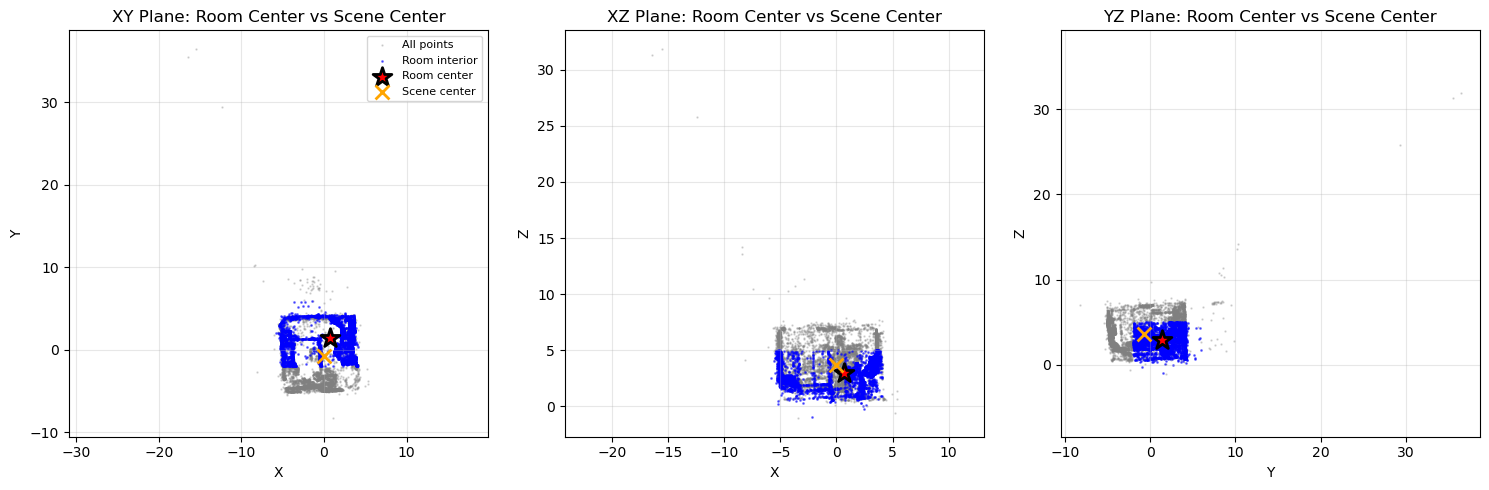

Saved: data/mv_demo/20251209_081245/keyframes/step2_room_center.png


In [13]:
# Cell 3.2: Visualize Room Center

fig = plt.figure(figsize=(15, 5))

# XY plane
ax1 = fig.add_subplot(131)
sample_idx = np.random.choice(len(xyz), min(10000, len(xyz)), replace=False)
ax1.scatter(xyz[sample_idx, 0], xyz[sample_idx, 1], s=0.5, alpha=0.3, c='gray', label='All points')
room_sample_idx = np.random.choice(len(room_interior_points), min(5000, len(room_interior_points)), replace=False)
ax1.scatter(room_interior_points[room_sample_idx, 0], room_interior_points[room_sample_idx, 1], 
           s=1, alpha=0.5, c='blue', label='Room interior')
ax1.scatter(room_center[0], room_center[1], s=200, c='red', marker='*', edgecolors='black', linewidths=2, label='Room center', zorder=5)
ax1.scatter(scene_center[0], scene_center[1], s=100, c='orange', marker='x', linewidths=2, label='Scene center', zorder=5)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('XY Plane: Room Center vs Scene Center')
ax1.legend(loc='upper right', fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.axis('equal')

# XZ plane
ax2 = fig.add_subplot(132)
ax2.scatter(xyz[sample_idx, 0], xyz[sample_idx, 2], s=0.5, alpha=0.3, c='gray')
ax2.scatter(room_interior_points[room_sample_idx, 0], room_interior_points[room_sample_idx, 2], s=1, alpha=0.5, c='blue')
ax2.scatter(room_center[0], room_center[2], s=200, c='red', marker='*', edgecolors='black', linewidths=2, zorder=5)
ax2.scatter(scene_center[0], scene_center[2], s=100, c='orange', marker='x', linewidths=2, zorder=5)
ax2.set_xlabel('X')
ax2.set_ylabel('Z')
ax2.set_title('XZ Plane: Room Center vs Scene Center')
ax2.grid(True, alpha=0.3)
ax2.axis('equal')

# YZ plane
ax3 = fig.add_subplot(133)
ax3.scatter(xyz[sample_idx, 1], xyz[sample_idx, 2], s=0.5, alpha=0.3, c='gray')
ax3.scatter(room_interior_points[room_sample_idx, 1], room_interior_points[room_sample_idx, 2], s=1, alpha=0.5, c='blue')
ax3.scatter(room_center[1], room_center[2], s=200, c='red', marker='*', edgecolors='black', linewidths=2, zorder=5)
ax3.scatter(scene_center[1], scene_center[2], s=100, c='orange', marker='x', linewidths=2, zorder=5)
ax3.set_xlabel('Y')
ax3.set_ylabel('Z')
ax3.set_title('YZ Plane: Room Center vs Scene Center')
ax3.grid(True, alpha=0.3)
ax3.axis('equal')

plt.tight_layout()
plt.savefig(KEYFRAMES_DIR / "step2_room_center.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {KEYFRAMES_DIR / 'step2_room_center.png'}")

In [17]:
# Cell 3.3: Export PLY with Room Center Marker

print("\n" + "="*70)
print("EXPORTING PLY WITH ROOM CENTER MARKER")
print("="*70)

# =============================================================================
# Create Large Sphere Marker at Room Center
# =============================================================================

def create_sphere_marker(
    center: np.ndarray, 
    radius: float = 0.3,
    n_points: int = 500,
    color: tuple = (1.0, 0.0, 0.0)  # RGB: Red
) -> Dict[str, np.ndarray]:
    """
    Create a sphere marker as Gaussian splats.
    
    Args:
        center: [x, y, z] position
        radius: Sphere radius
        n_points: Number of Gaussian points
        color: RGB color (0-1 range)
    
    Returns:
        Dictionary with Gaussian parameters
    """
    # Generate points on sphere surface
    phi = np.random.uniform(0, 2*np.pi, n_points)
    theta = np.random.uniform(0, np.pi, n_points)
    
    x = center[0] + radius * np.sin(theta) * np.cos(phi)
    y = center[1] + radius * np.sin(theta) * np.sin(phi)
    z = center[2] + radius * np.cos(theta)
    
    xyz = np.stack([x, y, z], axis=1).astype(np.float32)
    
    # Create Gaussian parameters
    marker_gaussians = {
        'xyz': xyz,
        'opacities': np.ones((n_points, 1), dtype=np.float32) * 0.9,  # High opacity
        'scales': np.ones((n_points, 3), dtype=np.float32) * np.log(0.05),  # Small scale
        'rotations': np.tile([1.0, 0.0, 0.0, 0.0], (n_points, 1)).astype(np.float32),  # Identity
        'features_dc': np.tile(color, (n_points, 1)).astype(np.float32),  # Red color
        'features_rest': np.zeros((n_points, 45), dtype=np.float32),  # No extra SH
    }
    
    return marker_gaussians


print("\n[1] Creating visualization markers...")

# Red sphere at Room Center
room_center_marker = create_sphere_marker(
    center=room_center,
    radius=0.5,  # Large enough to be visible
    n_points=1000,
    color=(1.0, 0.0, 0.0)  # Bright red
)
print(f"  ✓ Room center marker: {len(room_center_marker['xyz']):,} points (RED)")

# Green sphere at Scene Center (for comparison)
scene_center_full = scene_gaussians_aligned['xyz'].mean(axis=0)
scene_center_marker = create_sphere_marker(
    center=scene_center_full,
    radius=0.4,
    n_points=800,
    color=(0.0, 1.0, 0.0)  # Bright green
)
print(f"  ✓ Scene center marker: {len(scene_center_marker['xyz']):,} points (GREEN)")

# Blue sphere at coordinate origin (0, 0, 0)
origin_marker = create_sphere_marker(
    center=np.array([0.0, 0.0, 0.0]),
    radius=0.3,
    n_points=500,
    color=(0.0, 0.0, 1.0)  # Bright blue
)
print(f"  ✓ Origin marker (0,0,0): {len(origin_marker['xyz']):,} points (BLUE)")

# =============================================================================
# Option 1: Scene + Room Center Marker Only
# =============================================================================

print("\n[2] Exporting Scene + Room Center Marker...")

scene_with_room_center_path = KEYFRAMES_DIR / "step2_scene_with_room_center.ply"
merge_and_save_gaussians(
    gaussians_dict={
        "scene": scene_gaussians_aligned,
        "room_center_marker": room_center_marker
    },
    output_path=scene_with_room_center_path,
    verbose=False
)

print(f"  ✓ Saved: {scene_with_room_center_path.name}")
print(f"    RED sphere = Room center at {room_center}")

# =============================================================================
# Option 2: Scene + All Markers (Room/Scene/Origin)
# =============================================================================

print("\n[3] Exporting Scene + All Reference Markers...")

scene_with_all_markers_path = KEYFRAMES_DIR / "step2_scene_with_all_markers.ply"
merge_and_save_gaussians(
    gaussians_dict={
        "scene": scene_gaussians_aligned,
        "room_center": room_center_marker,
        "scene_center": scene_center_marker,
        "origin": origin_marker
    },
    output_path=scene_with_all_markers_path,
    verbose=False
)

print(f"  ✓ Saved: {scene_with_all_markers_path.name}")
print(f"    RED sphere = Room center {room_center}")
print(f"    GREEN sphere = Scene center {scene_center_full}")
print(f"    BLUE sphere = Origin (0,0,0)")

# =============================================================================
# Option 3: Merged Scene + Objects + Room Center
# =============================================================================

print("\n[4] Exporting Complete Scene (Objects + Room Center)...")

complete_with_marker_path = KEYFRAMES_DIR / "step2_complete_with_room_center.ply"
merge_and_save_gaussians(
    gaussians_dict={
        "scene": scene_gaussians_aligned,
        "obj01_kermit": obj01_gaussians_aligned,
        "obj02_bottle": obj02_gaussians_aligned,
        "room_center": room_center_marker
    },
    output_path=complete_with_marker_path,
    verbose=False
)

print(f"  ✓ Saved: {complete_with_marker_path.name}")
print(f"    Contains: Scene + Kermit + Bottle + Room Center (RED)")

# =============================================================================
# Summary
# =============================================================================

print("\n" + "="*70)
print("ROOM CENTER VISUALIZATION FILES")
print("="*70)

print("\n📍 Coordinates:")
print(f"  Room center (filtered): [{room_center[0]:.3f}, {room_center[1]:.3f}, {room_center[2]:.3f}]")
print(f"  Scene center (all):     [{scene_center_full[0]:.3f}, {scene_center_full[1]:.3f}, {scene_center_full[2]:.3f}]")
print(f"  Origin:                 [0.000, 0.000, 0.000]")

print("\n📦 Generated PLY files:")
print(f"  1. {scene_with_room_center_path.name}")
print(f"     → Scene + RED sphere (room center only)")
print(f"  2. {scene_with_all_markers_path.name}")
print(f"     → Scene + RED/GREEN/BLUE spheres (all reference points)")
print(f"  3. {complete_with_marker_path.name}")
print(f"     → Complete scene with objects + RED sphere")

print(f"\n💡 Viewing instructions:")
print(f"  1. Go to: https://antimatter15.com/splat/")
print(f"  2. Drag & drop: {scene_with_all_markers_path.name}")
print(f"  3. Look for colored spheres:")
print(f"     🔴 RED = Room center (where camera will orbit)")
print(f"     🟢 GREEN = Scene center (all points average)")
print(f"     🔵 BLUE = Coordinate origin (0,0,0)")

print("\n📁 Files location:")
print(f"  {KEYFRAMES_DIR.absolute()}")

print("\n[OK] Room center visualization PLY files exported")


EXPORTING PLY WITH ROOM CENTER MARKER

[1] Creating visualization markers...
  ✓ Room center marker: 1,000 points (RED)
  ✓ Scene center marker: 800 points (GREEN)
  ✓ Origin marker (0,0,0): 500 points (BLUE)

[2] Exporting Scene + Room Center Marker...
  ✓ Saved: step2_scene_with_room_center.ply
    Points: 1,509,976 | Size: 339.85 MB
  ✓ Saved: step2_scene_with_room_center.ply
    RED sphere = Room center at [0.693328  1.3942202 2.9638264]

[3] Exporting Scene + All Reference Markers...
  ✓ Saved: step2_scene_with_all_markers.ply
    Points: 1,511,276 | Size: 340.14 MB
  ✓ Saved: step2_scene_with_all_markers.ply
    RED sphere = Room center [0.693328  1.3942202 2.9638264]
    GREEN sphere = Scene center [-0.04830807 -0.7298181   3.6448867 ]
    BLUE sphere = Origin (0,0,0)

[4] Exporting Complete Scene (Objects + Room Center)...
  ✓ Saved: step2_complete_with_room_center.ply
    Points: 1,689,321 | Size: 380.21 MB
  ✓ Saved: step2_complete_with_room_center.ply
    Contains: Scene + 

---
# Part 4: Step 3 - 카메라 시작점 정의

In [55]:
# Cell 4.1: Camera Helper Functions

def look_at_quaternion(eye: np.ndarray, target: np.ndarray, up: np.ndarray = np.array([0, 1, 0])) -> np.ndarray:
    """
    Create a look-at quaternion for camera orientation.
    
    Args:
        eye: Camera position
        target: Point to look at
        up: Up vector (default Y-up)
    
    Returns:
        Quaternion [w, x, y, z] representing camera orientation
    """
    from scipy.spatial.transform import Rotation
    
    # ★ FIXED: Forward direction (camera looks along +Z, not -Z)
    # Changed from: forward = target - eye
    forward = eye - target  # ← 이 줄만 수정!
    forward = forward / np.linalg.norm(forward)
    
    # Right vector
    right = np.cross(forward, up)
    right = right / np.linalg.norm(right)
    
    # Recompute up
    up_corrected = np.cross(right, forward)
    
    # Build rotation matrix (column vectors: right, up, -forward)
    R = np.column_stack([right, up_corrected, -forward])
    
    # Convert to quaternion [x, y, z, w] -> [w, x, y, z]
    r = Rotation.from_matrix(R)
    quat_xyzw = r.as_quat()
    quat_wxyz = np.array([quat_xyzw[3], quat_xyzw[0], quat_xyzw[1], quat_xyzw[2]], dtype=np.float32)
    
    return quat_wxyz

print("[OK] Camera helper functions defined (FIXED: forward direction)")

[OK] Camera helper functions defined (FIXED: forward direction)


In [56]:
# Cell 4.2: Define Initial Camera Position (Manual Coordinates)

print("\n" + "="*70)
print("STEP 3: CAMERA START POINT DEFINITION")
print("="*70)

# Calculate scene center as look-at target
xyz = scene_gaussians_aligned['xyz']
scene_center = xyz.mean(axis=0)

print(f"\nScene Center (look-at target):")
print(f"  [{scene_center[0]:.3f}, {scene_center[1]:.3f}, {scene_center[2]:.3f}]")

# =============================================================================
# Manual Camera Position (Edit this to adjust camera start point)
# =============================================================================

# ★ MANUAL SETTING: Set camera position directly
camera_start_position = np.array([2.5, 2.0, 5.5], dtype=np.float32)

# Calculate camera orientation to look at scene center
camera_start_rotation = look_at_quaternion(camera_start_position, scene_center)

# Calculate distance from scene center
distance_from_center = np.linalg.norm(camera_start_position - scene_center)

print(f"\n=== Initial Camera Configuration ===")
print(f"Camera position (MANUAL): [{camera_start_position[0]:.3f}, {camera_start_position[1]:.3f}, {camera_start_position[2]:.3f}]")
print(f"Looking at scene_center: [{scene_center[0]:.3f}, {scene_center[1]:.3f}, {scene_center[2]:.3f}]")
print(f"Distance from center: {distance_from_center:.3f}")
print(f"Camera rotation (quat): [{camera_start_rotation[0]:.3f}, {camera_start_rotation[1]:.3f}, {camera_start_rotation[2]:.3f}, {camera_start_rotation[3]:.3f}]")

print("\n💡 TIP: Edit camera_start_position in Cell 4.2 to adjust camera location")
print("   Example: np.array([5.0, 10.0, 15.0]) for different viewing angle")

print("\n[OK] Step 3 complete: Camera start point defined")




STEP 3: CAMERA START POINT DEFINITION

Scene Center (look-at target):
  [-0.048, -0.730, 3.645]

=== Initial Camera Configuration ===
Camera position (MANUAL): [2.500, 2.000, 5.500]
Looking at scene_center: [-0.048, -0.730, 3.645]
Distance from center: 4.170
Camera rotation (quat): [-0.425, -0.158, 0.835, -0.311]

💡 TIP: Edit camera_start_position in Cell 4.2 to adjust camera location
   Example: np.array([5.0, 10.0, 15.0]) for different viewing angle

[OK] Step 3 complete: Camera start point defined



3D VISUALIZATION: CAMERA START POINT


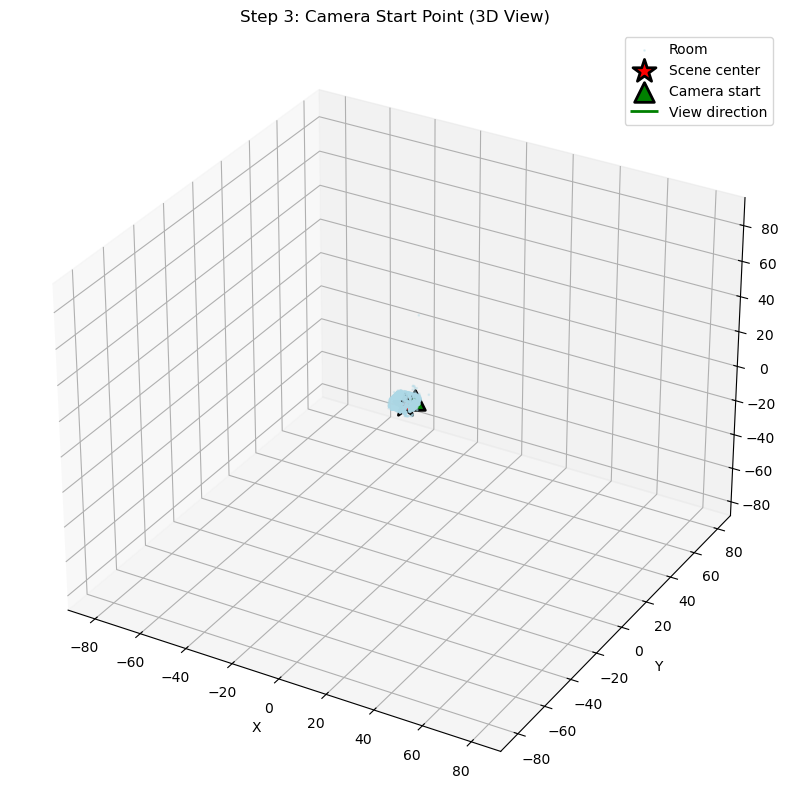

Saved: data/mv_demo/20251209_081245/keyframes/step3_camera_start_3d.png


In [57]:
# Cell 4.3: Visualize Camera Start Point (3D View)

print("\n" + "="*70)
print("3D VISUALIZATION: CAMERA START POINT")
print("="*70)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scene points (sampled)
sample_idx = np.random.choice(len(xyz), min(5000, len(xyz)), replace=False)
ax.scatter(xyz[sample_idx, 0], 
          xyz[sample_idx, 1], 
          xyz[sample_idx, 2],
          s=1, alpha=0.3, c='lightblue', label='Room')

# Scene center
ax.scatter(scene_center[0], scene_center[1], scene_center[2],
          s=300, c='red', marker='*', edgecolors='black', linewidths=2, label='Scene center', zorder=10)

# Camera start position
ax.scatter(camera_start_position[0], camera_start_position[1], camera_start_position[2],
          s=200, c='green', marker='^', edgecolors='black', linewidths=2, label='Camera start', zorder=10)

# Camera view direction
view_direction = (scene_center - camera_start_position) * 0.3
ax.quiver(camera_start_position[0], camera_start_position[1], camera_start_position[2],
         view_direction[0], view_direction[1], view_direction[2],
         color='green', linewidth=2, arrow_length_ratio=0.3, label='View direction')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Step 3: Camera Start Point (3D View)')
ax.legend()

# Set equal aspect ratio based on scene extent
scene_extent = np.max(np.abs(xyz - scene_center))
max_range = max(scene_extent * 1.5, distance_from_center * 1.2)
ax.set_xlim([scene_center[0] - max_range, scene_center[0] + max_range])
ax.set_ylim([scene_center[1] - max_range, scene_center[1] + max_range])
ax.set_zlim([scene_center[2] - max_range, scene_center[2] + max_range])

plt.savefig(KEYFRAMES_DIR / "step3_camera_start_3d.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {KEYFRAMES_DIR / 'step3_camera_start_3d.png'}")




3-PLANE VISUALIZATION: CAMERA START POINT


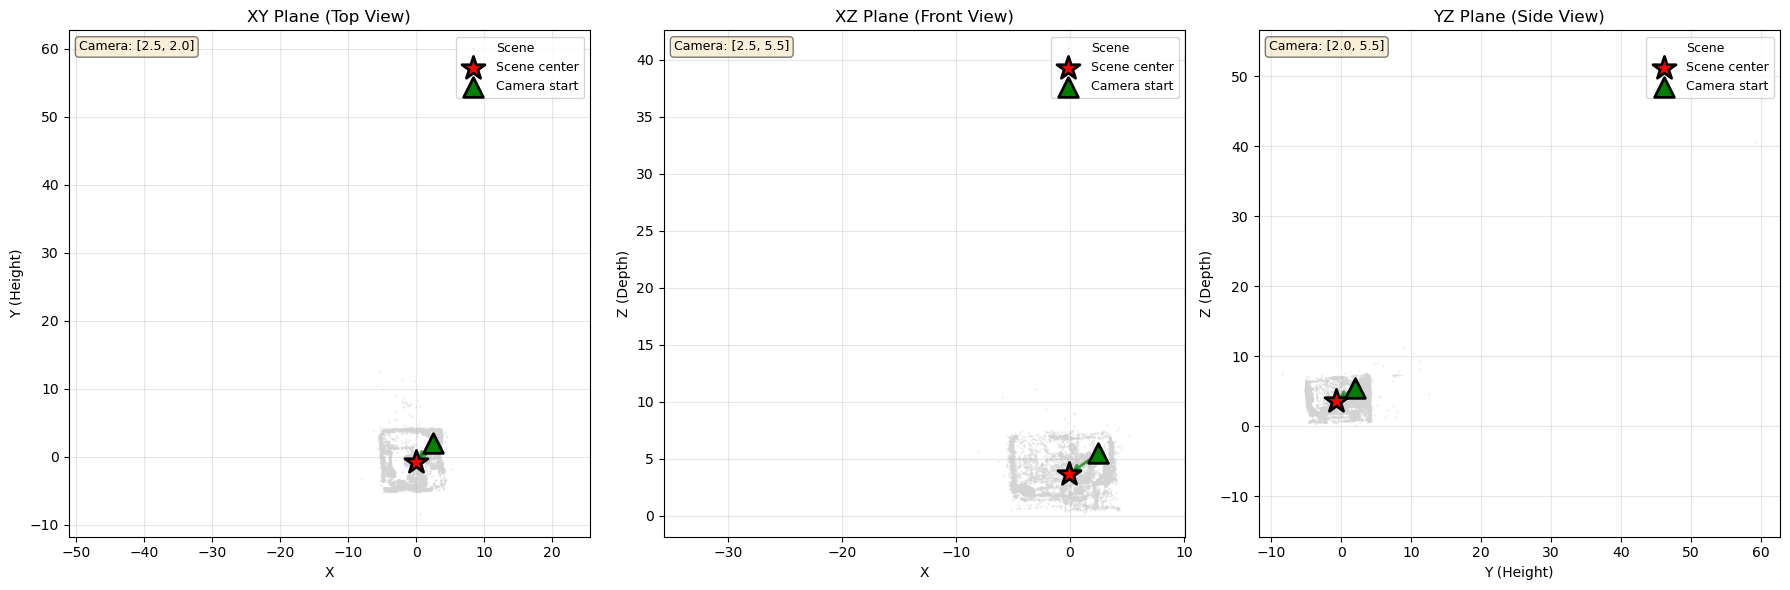

Saved: data/mv_demo/20251209_081245/keyframes/step3_camera_start_3planes.png


In [58]:
# Cell 4.4: Visualize Camera Start Point (3-Plane View)

print("\n" + "="*70)
print("3-PLANE VISUALIZATION: CAMERA START POINT")
print("="*70)

fig = plt.figure(figsize=(18, 6))

# Sample scene points for visualization
sample_idx = np.random.choice(len(xyz), min(8000, len(xyz)), replace=False)

# =============================================================================
# XY Plane (Top View)
# =============================================================================
ax1 = fig.add_subplot(131)
ax1.scatter(xyz[sample_idx, 0], xyz[sample_idx, 1], 
           s=0.5, alpha=0.3, c='lightgray', label='Scene')
ax1.scatter(scene_center[0], scene_center[1], 
           s=300, c='red', marker='*', edgecolors='black', linewidths=2, 
           label='Scene center', zorder=10)
ax1.scatter(camera_start_position[0], camera_start_position[1], 
           s=200, c='green', marker='^', edgecolors='black', linewidths=2, 
           label='Camera start', zorder=10)

# View direction arrow
ax1.annotate('', xy=(scene_center[0], scene_center[1]), 
            xytext=(camera_start_position[0], camera_start_position[1]),
            arrowprops=dict(arrowstyle='->', color='green', lw=2, alpha=0.7))

# Display coordinates
ax1.text(0.02, 0.98, f'Camera: [{camera_start_position[0]:.1f}, {camera_start_position[1]:.1f}]',
        transform=ax1.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax1.set_xlabel('X')
ax1.set_ylabel('Y (Height)')
ax1.set_title('XY Plane (Top View)')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.axis('equal')

# =============================================================================
# XZ Plane (Front View)
# =============================================================================
ax2 = fig.add_subplot(132)
ax2.scatter(xyz[sample_idx, 0], xyz[sample_idx, 2], 
           s=0.5, alpha=0.3, c='lightgray', label='Scene')
ax2.scatter(scene_center[0], scene_center[2], 
           s=300, c='red', marker='*', edgecolors='black', linewidths=2, 
           label='Scene center', zorder=10)
ax2.scatter(camera_start_position[0], camera_start_position[2], 
           s=200, c='green', marker='^', edgecolors='black', linewidths=2, 
           label='Camera start', zorder=10)

# View direction arrow
ax2.annotate('', xy=(scene_center[0], scene_center[2]), 
            xytext=(camera_start_position[0], camera_start_position[2]),
            arrowprops=dict(arrowstyle='->', color='green', lw=2, alpha=0.7))

# Display coordinates
ax2.text(0.02, 0.98, f'Camera: [{camera_start_position[0]:.1f}, {camera_start_position[2]:.1f}]',
        transform=ax2.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax2.set_xlabel('X')
ax2.set_ylabel('Z (Depth)')
ax2.set_title('XZ Plane (Front View)')
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.axis('equal')

# =============================================================================
# YZ Plane (Side View)
# =============================================================================
ax3 = fig.add_subplot(133)
ax3.scatter(xyz[sample_idx, 1], xyz[sample_idx, 2], 
           s=0.5, alpha=0.3, c='lightgray', label='Scene')
ax3.scatter(scene_center[1], scene_center[2], 
           s=300, c='red', marker='*', edgecolors='black', linewidths=2, 
           label='Scene center', zorder=10)
ax3.scatter(camera_start_position[1], camera_start_position[2], 
           s=200, c='green', marker='^', edgecolors='black', linewidths=2, 
           label='Camera start', zorder=10)

# View direction arrow
ax3.annotate('', xy=(scene_center[1], scene_center[2]), 
            xytext=(camera_start_position[1], camera_start_position[2]),
            arrowprops=dict(arrowstyle='->', color='green', lw=2, alpha=0.7))

# Display coordinates
ax3.text(0.02, 0.98, f'Camera: [{camera_start_position[1]:.1f}, {camera_start_position[2]:.1f}]',
        transform=ax3.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax3.set_xlabel('Y (Height)')
ax3.set_ylabel('Z (Depth)')
ax3.set_title('YZ Plane (Side View)')
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.axis('equal')

plt.tight_layout()
plt.savefig(KEYFRAMES_DIR / "step3_camera_start_3planes.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {KEYFRAMES_DIR / 'step3_camera_start_3planes.png'}")



In [19]:
# Cell 4.5: Export Camera Start Visualization PLY

print("\n" + "="*70)
print("EXPORTING CAMERA START VISUALIZATION PLY")
print("="*70)

# Create camera marker at start position
camera_marker = create_sphere_marker(
    center=camera_start_position,
    radius=0.4,
    n_points=800,
    color=(0.0, 1.0, 0.0)  # Green
)

# Create scene center marker
scene_center_marker = create_sphere_marker(
    center=scene_center,
    radius=0.5,
    n_points=1000,
    color=(1.0, 0.0, 0.0)  # Red
)

# Export scene with camera and center markers
camera_viz_path = KEYFRAMES_DIR / "step3_scene_with_camera_start.ply"
merge_and_save_gaussians(
    gaussians_dict={
        "scene": scene_gaussians_aligned,
        "scene_center": scene_center_marker,
        "camera_start": camera_marker
    },
    output_path=camera_viz_path,
    verbose=False
)

print(f"\n✓ Exported: {camera_viz_path.name}")
print(f"  🔴 RED sphere = Scene center (camera look-at target)")
print(f"  🟢 GREEN sphere = Camera start position [{camera_start_position[0]:.1f}, {camera_start_position[1]:.1f}, {camera_start_position[2]:.1f}]")

print(f"\n💡 View in browser:")
print(f"  1. Go to: https://antimatter15.com/splat/")
print(f"  2. Drag & drop: {camera_viz_path.name}")
print(f"  3. Verify camera position relative to scene")

print(f"\n📁 File location: {KEYFRAMES_DIR.absolute()}")

print("\n[OK] Step 3 complete: Camera start visualization exported")


EXPORTING CAMERA START VISUALIZATION PLY
  ✓ Saved: step3_scene_with_camera_start.ply
    Points: 1,510,776 | Size: 340.03 MB

✓ Exported: step3_scene_with_camera_start.ply
  🔴 RED sphere = Scene center (camera look-at target)
  🟢 GREEN sphere = Camera start position [2.5, 2.0, 5.5]

💡 View in browser:
  1. Go to: https://antimatter15.com/splat/
  2. Drag & drop: step3_scene_with_camera_start.ply
  3. Verify camera position relative to scene

📁 File location: /home/ec2-user/SageMaker/3dgs/data/mv_demo/20251208_223643/keyframes

[OK] Step 3 complete: Camera start visualization exported


---
# Part 5: Step 4+5 - 오브젝트 정렬 및 배치


STEP 4+5: OBJECT ALIGNMENT AND PLACEMENT

Reference Point:
  Scene center: [-0.048, -0.730, 3.645]

OBJECT INITIAL STATES (Before Transformation)

Obj01 (Kermit):
  Points: 108,077
  Center: [ -0.459,  -0.978,   3.505]
  X: [ -1.677,   1.582] → span  3.260
  Y: [ -2.129,   0.405] → span  2.534
  Z: [  1.254,   6.858] → span  5.605

Obj02 (Bottle):
  Points: 71,268
  Center: [  0.893,  -3.355,   3.010]
  X: [ -2.107,   3.989] → span  6.096
  Y: [ -5.400,   1.436] → span  6.836
  Z: [ -5.598,   5.034] → span 10.632

💡 These are the ORIGINAL object dimensions after world alignment
   Use these as reference when setting scale factors

3-PLANE VISUALIZATION: OBJECTS IN SCENE CONTEXT


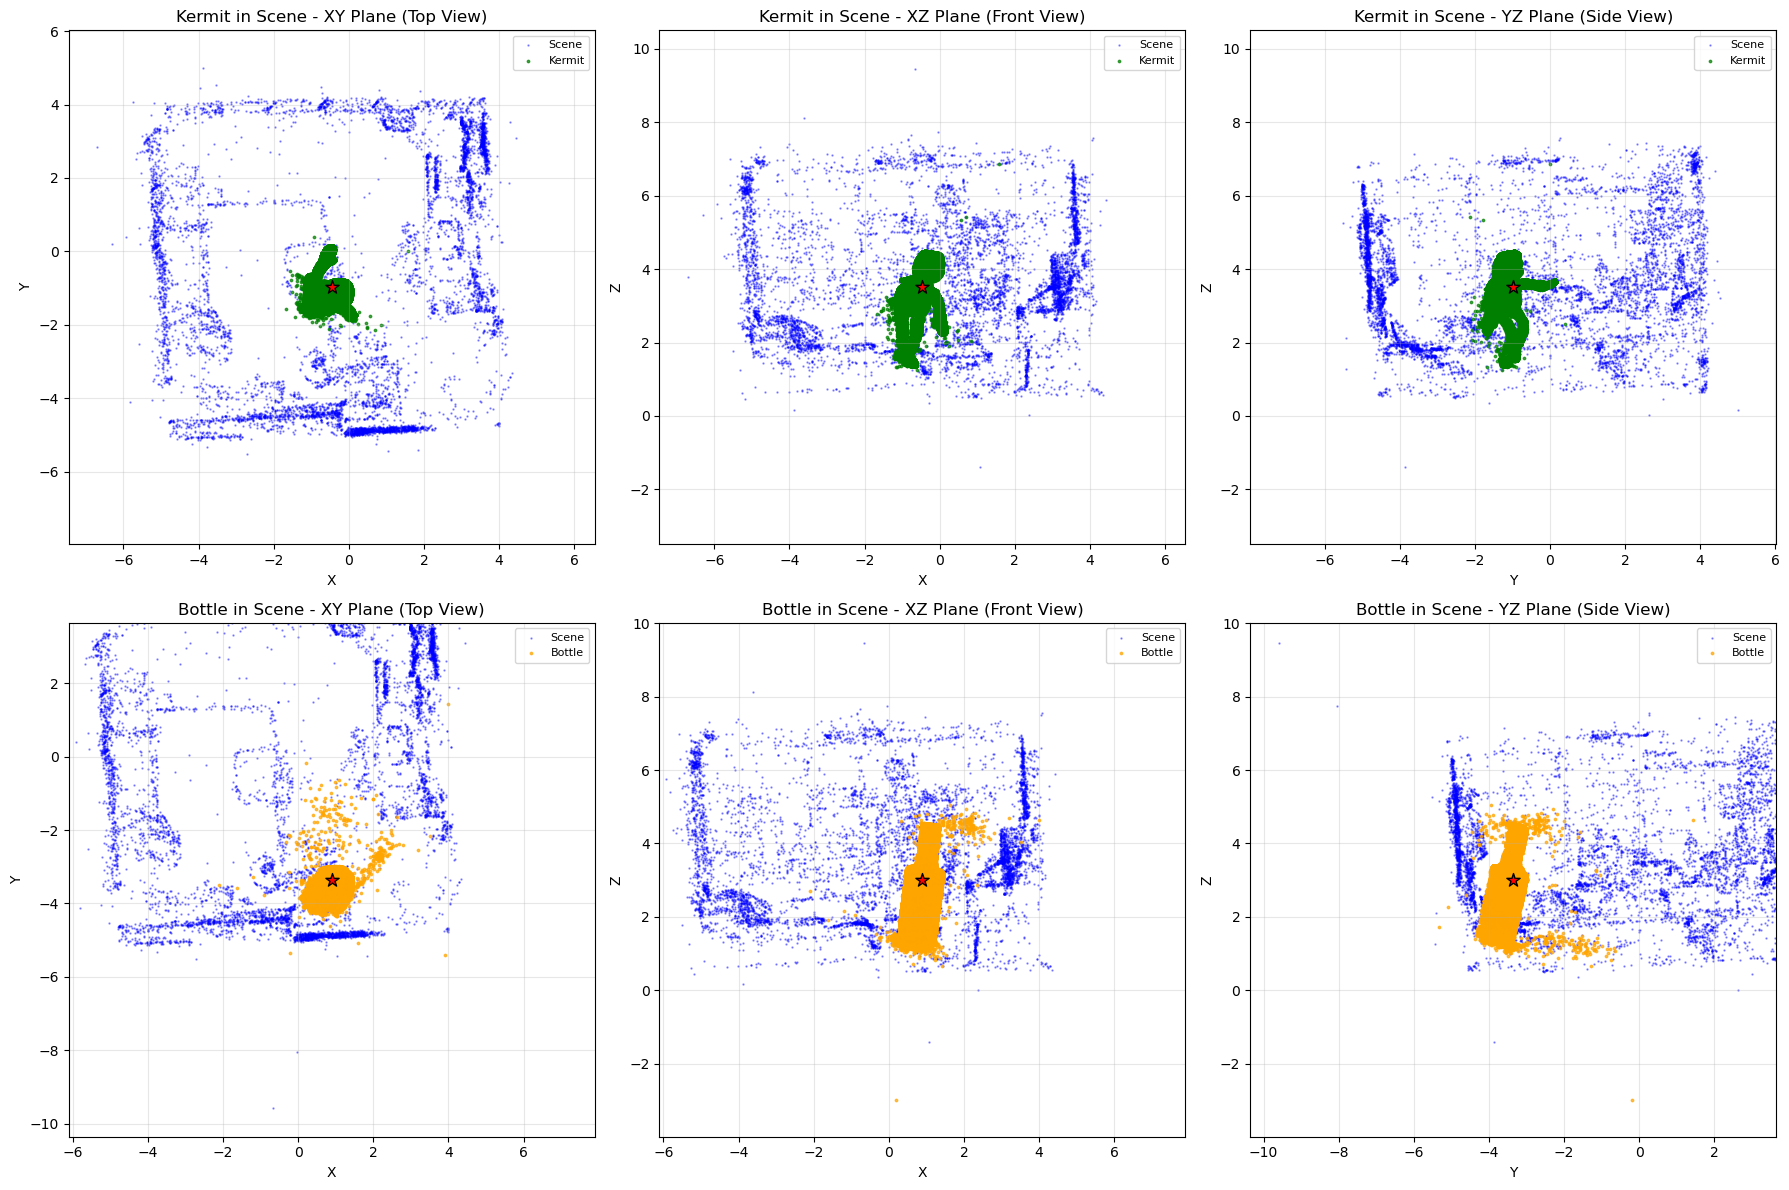

Saved: data/mv_demo/20251209_081245/keyframes/step45_objects_initial_in_scene_3planes.png
Shows each object overlaid on scene to see relative position
Gray background = Scene | Red star = Object center before transformation


In [59]:
# Cell 5.1: Object Initial State Information

print("\n" + "="*70)
print("STEP 4+5: OBJECT ALIGNMENT AND PLACEMENT")
print("="*70)

# Calculate scene center (reference point)
xyz = scene_gaussians_aligned['xyz']
scene_center = xyz.mean(axis=0)

print(f"\nReference Point:")
print(f"  Scene center: [{scene_center[0]:.3f}, {scene_center[1]:.3f}, {scene_center[2]:.3f}]")

# =============================================================================
# Object Initial States (Before Transformation)
# =============================================================================

print("\n" + "="*70)
print("OBJECT INITIAL STATES (Before Transformation)")
print("="*70)

# Obj01 (Kermit) - aligned coordinates
obj01_bbox_before = compute_bbox_and_span(obj01_gaussians_aligned, "Obj01 (Kermit)")
print_bbox_stats(obj01_bbox_before)

# Obj02 (Bottle) - aligned coordinates
obj02_bbox_before = compute_bbox_and_span(obj02_gaussians_aligned, "Obj02 (Bottle)")
print_bbox_stats(obj02_bbox_before)

print("\n💡 These are the ORIGINAL object dimensions after world alignment")
print("   Use these as reference when setting scale factors")

# =============================================================================
# 3-Plane Visualization: Objects in Scene Context
# =============================================================================

print("\n" + "="*70)
print("3-PLANE VISUALIZATION: OBJECTS IN SCENE CONTEXT")
print("="*70)

fig = plt.figure(figsize=(18, 12))

# Sample data
scene_xyz = scene_gaussians_aligned['xyz']
scene_sample_idx = np.random.choice(len(scene_xyz), min(8000, len(scene_xyz)), replace=False)

obj01_xyz = obj01_gaussians_aligned['xyz']
obj02_xyz = obj02_gaussians_aligned['xyz']

# Calculate view ranges based on object centers
obj01_center = obj01_bbox_before['center']
obj02_center = obj02_bbox_before['center']
margin = 7.0  # View margin

# =============================================================================
# Row 1: Obj01 (Kermit) + Scene
# =============================================================================

# XY Plane
ax1 = fig.add_subplot(2, 3, 1)
ax1.scatter(scene_xyz[scene_sample_idx, 0], scene_xyz[scene_sample_idx, 1], 
           s=0.5, alpha=0.4, c='blue', label='Scene')
ax1.scatter(obj01_xyz[:, 0], obj01_xyz[:, 1], 
           s=3, alpha=0.7, c='green', label='Kermit')
ax1.scatter(obj01_center[0], obj01_center[1],
           s=100, c='red', marker='*', edgecolors='black', linewidths=1, zorder=10)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Kermit in Scene - XY Plane (Top View)')
ax1.legend(loc='upper right', fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([obj01_center[0] - margin, obj01_center[0] + margin])
ax1.set_ylim([obj01_center[1] - margin, obj01_center[1] + margin])

# XZ Plane
ax2 = fig.add_subplot(2, 3, 2)
ax2.scatter(scene_xyz[scene_sample_idx, 0], scene_xyz[scene_sample_idx, 2], 
           s=0.5, alpha=0.4, c='blue', label='Scene')
ax2.scatter(obj01_xyz[:, 0], obj01_xyz[:, 2], 
           s=3, alpha=0.7, c='green', label='Kermit')
ax2.scatter(obj01_center[0], obj01_center[2],
           s=100, c='red', marker='*', edgecolors='black', linewidths=1, zorder=10)
ax2.set_xlabel('X')
ax2.set_ylabel('Z')
ax2.set_title('Kermit in Scene - XZ Plane (Front View)')
ax2.legend(loc='upper right', fontsize=8)
ax2.grid(True, alpha=0.3)
ax2.set_xlim([obj01_center[0] - margin, obj01_center[0] + margin])
ax2.set_ylim([obj01_center[2] - margin, obj01_center[2] + margin])

# YZ Plane
ax3 = fig.add_subplot(2, 3, 3)
ax3.scatter(scene_xyz[scene_sample_idx, 1], scene_xyz[scene_sample_idx, 2], 
           s=0.5, alpha=0.4, c='blue', label='Scene')
ax3.scatter(obj01_xyz[:, 1], obj01_xyz[:, 2], 
           s=3, alpha=0.7, c='green', label='Kermit')
ax3.scatter(obj01_center[1], obj01_center[2],
           s=100, c='red', marker='*', edgecolors='black', linewidths=1, zorder=10)
ax3.set_xlabel('Y')
ax3.set_ylabel('Z')
ax3.set_title('Kermit in Scene - YZ Plane (Side View)')
ax3.legend(loc='upper right', fontsize=8)
ax3.grid(True, alpha=0.3)
ax3.set_xlim([obj01_center[1] - margin, obj01_center[1] + margin])
ax3.set_ylim([obj01_center[2] - margin, obj01_center[2] + margin])

# =============================================================================
# Row 2: Obj02 (Bottle) + Scene
# =============================================================================

# XY Plane
ax4 = fig.add_subplot(2, 3, 4)
ax4.scatter(scene_xyz[scene_sample_idx, 0], scene_xyz[scene_sample_idx, 1], 
           s=0.5, alpha=0.4, c='blue', label='Scene')
ax4.scatter(obj02_xyz[:, 0], obj02_xyz[:, 1], 
           s=3, alpha=0.7, c='orange', label='Bottle')
ax4.scatter(obj02_center[0], obj02_center[1],
           s=100, c='red', marker='*', edgecolors='black', linewidths=1, zorder=10)
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
ax4.set_title('Bottle in Scene - XY Plane (Top View)')
ax4.legend(loc='upper right', fontsize=8)
ax4.grid(True, alpha=0.3)
ax4.set_xlim([obj02_center[0] - margin, obj02_center[0] + margin])
ax4.set_ylim([obj02_center[1] - margin, obj02_center[1] + margin])

# XZ Plane
ax5 = fig.add_subplot(2, 3, 5)
ax5.scatter(scene_xyz[scene_sample_idx, 0], scene_xyz[scene_sample_idx, 2], 
           s=0.5, alpha=0.4, c='blue', label='Scene')
ax5.scatter(obj02_xyz[:, 0], obj02_xyz[:, 2], 
           s=3, alpha=0.7, c='orange', label='Bottle')
ax5.scatter(obj02_center[0], obj02_center[2],
           s=100, c='red', marker='*', edgecolors='black', linewidths=1, zorder=10)
ax5.set_xlabel('X')
ax5.set_ylabel('Z')
ax5.set_title('Bottle in Scene - XZ Plane (Front View)')
ax5.legend(loc='upper right', fontsize=8)
ax5.grid(True, alpha=0.3)
ax5.set_xlim([obj02_center[0] - margin, obj02_center[0] + margin])
ax5.set_ylim([obj02_center[2] - margin, obj02_center[2] + margin])

# YZ Plane
ax6 = fig.add_subplot(2, 3, 6)
ax6.scatter(scene_xyz[scene_sample_idx, 1], scene_xyz[scene_sample_idx, 2], 
           s=0.5, alpha=0.4, c='blue', label='Scene')
ax6.scatter(obj02_xyz[:, 1], obj02_xyz[:, 2], 
           s=3, alpha=0.7, c='orange', label='Bottle')
ax6.scatter(obj02_center[1], obj02_center[2],
           s=100, c='red', marker='*', edgecolors='black', linewidths=1, zorder=10)
ax6.set_xlabel('Y')
ax6.set_ylabel('Z')
ax6.set_title('Bottle in Scene - YZ Plane (Side View)')
ax6.legend(loc='upper right', fontsize=8)
ax6.grid(True, alpha=0.3)
ax6.set_xlim([obj02_center[1] - margin, obj02_center[1] + margin])
ax6.set_ylim([obj02_center[2] - margin, obj02_center[2] + margin])

plt.tight_layout()
plt.savefig(KEYFRAMES_DIR / "step45_objects_initial_in_scene_3planes.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {KEYFRAMES_DIR / 'step45_objects_initial_in_scene_3planes.png'}")
print("Shows each object overlaid on scene to see relative position")
print("Gray background = Scene | Red star = Object center before transformation")

In [60]:
# Cell: Parameter Conversion from Old to New Transform Function (Complete Version)

import numpy as np

def quaternion_to_rotation_matrix(q: np.ndarray) -> np.ndarray:
    """
    Convert quaternion [w, x, y, z] to 3x3 rotation matrix.
    """
    w, x, y, z = q
    return np.array([
        [1 - 2*(y**2 + z**2), 2*(x*y - w*z), 2*(x*z + w*y)],
        [2*(x*y + w*z), 1 - 2*(x**2 + z**2), 2*(y*z - w*x)],
        [2*(x*z - w*y), 2*(y*z + w*x), 1 - 2*(x**2 + y**2)]
    ], dtype=np.float32)


def axis_angle_to_quaternion(axis: np.ndarray, angle: float) -> np.ndarray:
    """
    Convert axis-angle to quaternion [w, x, y, z].
    
    Args:
        axis: Unit vector [x, y, z]
        angle: Rotation angle in radians
    """
    axis = axis / np.linalg.norm(axis)  # Normalize
    half_angle = angle / 2.0
    w = np.cos(half_angle)
    xyz = axis * np.sin(half_angle)
    return np.array([w, xyz[0], xyz[1], xyz[2]], dtype=np.float32)


def convert_transform_v1_to_v2(
    old_translation: np.ndarray,
    old_rotation_y_deg: float,
    old_scale: float
) -> tuple:
    """
    Convert transformation parameters from old function [1] to new function [2].
    
    The key difference:
    - Old: Rotation → Scale → Translation (all at world origin)
    - New: Translation → Scale → Rotation (at target position)
    
    Args:
        old_translation: Translation vector from [1]
        old_rotation_y_deg: Y-axis rotation in degrees from [1]
        old_scale: Scale factor from [1]
    
    Returns:
        (new_translation, new_rotation_y_deg, new_scale)
    """
    # Convert rotation to quaternion and matrix
    old_rotation_quat = axis_angle_to_quaternion(
        np.array([0, 1, 0], dtype=np.float32),
        np.deg2rad(old_rotation_y_deg)
    )
    R = quaternion_to_rotation_matrix(old_rotation_quat)
    
    # In [1]: final_pos = R @ (scale * xyz_original) + translation
    # In [2]: final_pos = R @ (scale * (xyz_original + translation_new)) + translation_new
    #         = R @ scale @ xyz_original + R @ scale @ translation_new + translation_new
    #         = scale * R @ xyz_original + (scale * R + I) @ translation_new
    
    # We want: old_translation = (scale * R + I) @ new_translation
    # Solve for new_translation:
    # new_translation = inv(scale * R + I) @ old_translation
    
    transform_matrix = old_scale * R + np.eye(3)
    new_translation = np.linalg.solve(transform_matrix, old_translation)
    
    # Rotation and scale remain the same
    new_rotation_y_deg = old_rotation_y_deg
    new_scale = old_scale
    
    return new_translation, new_rotation_y_deg, new_scale


# =============================================================================
# Example: Convert your current working parameters
# =============================================================================

print("="*70)
print("CONVERTING PARAMETERS FROM [1] TO [2]")
print("="*70)

# Your working parameters from [1]
old_obj01_translation = np.array([-3, -3, 1.1], dtype=np.float32)
old_obj01_rotation_y_deg = -5.0
old_obj01_scale = 0.4

old_obj02_translation = np.array([-3.0, -2.5, 1.5], dtype=np.float32)
old_obj02_rotation_y_deg = -5.0
old_obj02_scale = 0.2

# Convert to [2] parameters
new_obj01_translation, new_obj01_rotation_y_deg, new_obj01_scale = convert_transform_v1_to_v2(
    old_obj01_translation, old_obj01_rotation_y_deg, old_obj01_scale
)

new_obj02_translation, new_obj02_rotation_y_deg, new_obj02_scale = convert_transform_v1_to_v2(
    old_obj02_translation, old_obj02_rotation_y_deg, old_obj02_scale
)

# Display results
print("\n=== Obj01 (Kermit) ===")
print(f"OLD [1]: translation={old_obj01_translation}, rotation_y={old_obj01_rotation_y_deg}°, scale={old_obj01_scale}")
print(f"NEW [2]: translation={new_obj01_translation}, rotation_y={new_obj01_rotation_y_deg}°, scale={new_obj01_scale}")
print(f"\n📋 Copy this to Cell 5.2:")
print(f"obj01_translation = np.array([{new_obj01_translation[0]:.4f}, {new_obj01_translation[1]:.4f}, {new_obj01_translation[2]:.4f}], dtype=np.float32)")
print(f"obj01_rotation_y_deg = {new_obj01_rotation_y_deg}")
print(f"obj01_scale = {new_obj01_scale}")

print("\n=== Obj02 (Bottle) ===")
print(f"OLD [1]: translation={old_obj02_translation}, rotation_y={old_obj02_rotation_y_deg}°, scale={old_obj02_scale}")
print(f"NEW [2]: translation={new_obj02_translation}, rotation_y={new_obj02_rotation_y_deg}°, scale={new_obj02_scale}")
print(f"\n📋 Copy this to Cell 5.2:")
print(f"obj02_translation = np.array([{new_obj02_translation[0]:.4f}, {new_obj02_translation[1]:.4f}, {new_obj02_translation[2]:.4f}], dtype=np.float32)")
print(f"obj02_rotation_y_deg = {new_obj02_rotation_y_deg}")
print(f"obj02_scale = {new_obj02_scale}")

print("\n" + "="*70)
print("✓ Conversion complete! Copy the values above to your Cell 5.2")
print("="*70)

CONVERTING PARAMETERS FROM [1] TO [2]

=== Obj01 (Kermit) ===
OLD [1]: translation=[-3.  -3.   1.1], rotation_y=-5.0°, scale=0.4
NEW [2]: translation=[-2.12426115 -2.14285713  0.83952465], rotation_y=-5.0°, scale=0.4

📋 Copy this to Cell 5.2:
obj01_translation = np.array([-2.1243, -2.1429, 0.8395], dtype=np.float32)
obj01_rotation_y_deg = -5.0
obj01_scale = 0.4

=== Obj02 (Bottle) ===
OLD [1]: translation=[-3.  -2.5  1.5], rotation_y=-5.0°, scale=0.2
NEW [2]: translation=[-2.48288148 -2.08333333  1.28688239], rotation_y=-5.0°, scale=0.2

📋 Copy this to Cell 5.2:
obj02_translation = np.array([-2.4829, -2.0833, 1.2869], dtype=np.float32)
obj02_rotation_y_deg = -5.0
obj02_scale = 0.2

✓ Conversion complete! Copy the values above to your Cell 5.2


In [61]:
# Cell 5.2: Manual Object Placement Settings

print("\n" + "="*70)
print("MANUAL OBJECT PLACEMENT (Edit these values)")
print("="*70)

# =============================================================================
# ★ MANUAL SETTINGS: Edit these values to adjust object placement
# =============================================================================

# Object 1: Kermit (Green Frog)
obj01_translation = np.array([-3, -3, 1.1], dtype=np.float32)  # Position in world
obj01_rotation_y_deg = -5.0  # Y-axis rotation in degrees
obj01_scale = 0.4  # Scale factor (1.0 = original size)

# Object 2: Bottle (Jim Beam)
obj02_translation = np.array([-3.0, -2.5, 1.5], dtype=np.float32)  # Position in world
obj02_rotation_y_deg = -5.0  # Y-axis rotation in degrees
obj02_scale = 0.2  # Scale factor (1.0 = original size)

# =============================================================================
# Convert to quaternions
# =============================================================================

obj01_rotation_quat = axis_angle_to_quaternion(
    np.array([0, 1, 0], dtype=np.float32),
    np.deg2rad(obj01_rotation_y_deg)
)

obj02_rotation_quat = axis_angle_to_quaternion(
    np.array([0, 1, 0], dtype=np.float32),
    np.deg2rad(obj02_rotation_y_deg)
)

# =============================================================================
# Store in INITIAL_POSES dictionary
# =============================================================================

INITIAL_POSES = {
    "obj01": {
        "name": "Kermit",
        "translation": obj01_translation,
        "rotation_quat": obj01_rotation_quat,
        "rotation_y_deg": obj01_rotation_y_deg,
        "scale": obj01_scale,
    },
    "obj02": {
        "name": "Bottle",
        "translation": obj02_translation,
        "rotation_quat": obj02_rotation_quat,
        "rotation_y_deg": obj02_rotation_y_deg,
        "scale": obj02_scale,
    },
}

# =============================================================================
# Display settings
# =============================================================================

print("\n=== Object Placement Settings ===")

print(f"\nObj01 (Kermit):")
print(f"  Position: [{obj01_translation[0]:.3f}, {obj01_translation[1]:.3f}, {obj01_translation[2]:.3f}]")
print(f"  Rotation Y: {obj01_rotation_y_deg}°")
print(f"  Scale: {obj01_scale}")
print(f"  → Original size: {obj01_bbox_before['span']}")
print(f"  → Scaled size: {obj01_bbox_before['span'] * obj01_scale}")

print(f"\nObj02 (Bottle):")
print(f"  Position: [{obj02_translation[0]:.3f}, {obj02_translation[1]:.3f}, {obj02_translation[2]:.3f}]")
print(f"  Rotation Y: {obj02_rotation_y_deg}°")
print(f"  Scale: {obj02_scale}")
print(f"  → Original size: {obj02_bbox_before['span']}")
print(f"  → Scaled size: {obj02_bbox_before['span'] * obj02_scale}")

print("\n💡 TIP: Edit Cell 5.2 to adjust object positions, rotations, and scales")

print("\n[OK] Step 4+5 complete: Object placement settings defined")


MANUAL OBJECT PLACEMENT (Edit these values)

=== Object Placement Settings ===

Obj01 (Kermit):
  Position: [-3.000, -3.000, 1.100]
  Rotation Y: -5.0°
  Scale: 0.4
  → Original size: [3.2596195 2.534132  5.6047444]
  → Scaled size: [1.3038478 1.0136528 2.2418978]

Obj02 (Bottle):
  Position: [-3.000, -2.500, 1.500]
  Rotation Y: -5.0°
  Scale: 0.2
  → Original size: [ 6.0957575  6.8359904 10.631912 ]
  → Scaled size: [1.2191515 1.3671981 2.1263826]

💡 TIP: Edit Cell 5.2 to adjust object positions, rotations, and scales

[OK] Step 4+5 complete: Object placement settings defined


In [62]:
# Cell 5.3: Apply Transformations to Objects

print("\n" + "="*70)
print("APPLYING TRANSFORMATIONS")
print("="*70)

def merge_gaussians(gaussian_list: List[Dict[str, np.ndarray]]) -> Dict[str, np.ndarray]:
    """
    Merge multiple Gaussian dictionaries by concatenating arrays.
    """
    merged = {}
    keys = gaussian_list[0].keys()
    
    for key in keys:
        merged[key] = np.concatenate([g[key] for g in gaussian_list], axis=0)
    
    return merged

# Transform objects to initial poses
obj01_placed = transform_gaussians_legacy(
    obj01_gaussians_aligned,
    translation=INITIAL_POSES["obj01"]["translation"],
    rotation_quat=INITIAL_POSES["obj01"]["rotation_quat"],
    scale=INITIAL_POSES["obj01"]["scale"]
)

obj02_placed = transform_gaussians_legacy(
    obj02_gaussians_aligned,
    translation=INITIAL_POSES["obj02"]["translation"],
    rotation_quat=INITIAL_POSES["obj02"]["rotation_quat"],
    scale=INITIAL_POSES["obj02"]["scale"]
)

print(f"\n✓ Obj01 (Kermit) transformed: {obj01_placed['xyz'].shape[0]:,} Gaussians")
print(f"✓ Obj02 (Bottle) transformed: {obj02_placed['xyz'].shape[0]:,} Gaussians")

# Verify placement
obj01_bbox_after = compute_bbox_and_span(obj01_placed, "Obj01 (Kermit) - After Placement")
obj02_bbox_after = compute_bbox_and_span(obj02_placed, "Obj02 (Bottle) - After Placement")

print("\n" + "="*70)
print("TRANSFORMED BOUNDING BOXES")
print("="*70)

print_bbox_stats(obj01_bbox_after)
print_bbox_stats(obj02_bbox_after)

# Merge scene + objects
composed_gaussians = merge_gaussians([
    scene_gaussians_aligned,
    obj01_placed,
    obj02_placed
])

print("\n" + "="*70)
print("COMPOSITION SUMMARY")
print("="*70)
print(f"Scene: {scene_gaussians_aligned['xyz'].shape[0]:,} Gaussians")
print(f"Obj01 (Kermit): {obj01_placed['xyz'].shape[0]:,} Gaussians")
print(f"Obj02 (Bottle): {obj02_placed['xyz'].shape[0]:,} Gaussians")
print(f"Total composed: {composed_gaussians['xyz'].shape[0]:,} Gaussians")

print("\n[OK] Objects transformed and merged with scene")


APPLYING TRANSFORMATIONS

✓ Obj01 (Kermit) transformed: 108,077 Gaussians
✓ Obj02 (Bottle) transformed: 71,268 Gaussians

TRANSFORMED BOUNDING BOXES

Obj01 (Kermit) - After Placement:
  Points: 108,077
  Center: [ -3.305,  -3.391,   2.480]
  X: [ -3.765,  -2.609] → span  1.157
  Y: [ -3.851,  -2.838] → span  1.014
  Z: [  1.578,   3.888] → span  2.310

Obj02 (Bottle) - After Placement:
  Points: 71,268
  Center: [ -2.875,  -3.171,   2.115]
  X: [ -3.467,  -2.124] → span  1.342
  Y: [ -3.580,  -2.213] → span  1.367
  Z: [  0.453,   2.531] → span  2.079

COMPOSITION SUMMARY
Scene: 1,508,976 Gaussians
Obj01 (Kermit): 108,077 Gaussians
Obj02 (Bottle): 71,268 Gaussians
Total composed: 1,688,321 Gaussians

[OK] Objects transformed and merged with scene



3-PLANE VISUALIZATION: OBJECT PLACEMENT


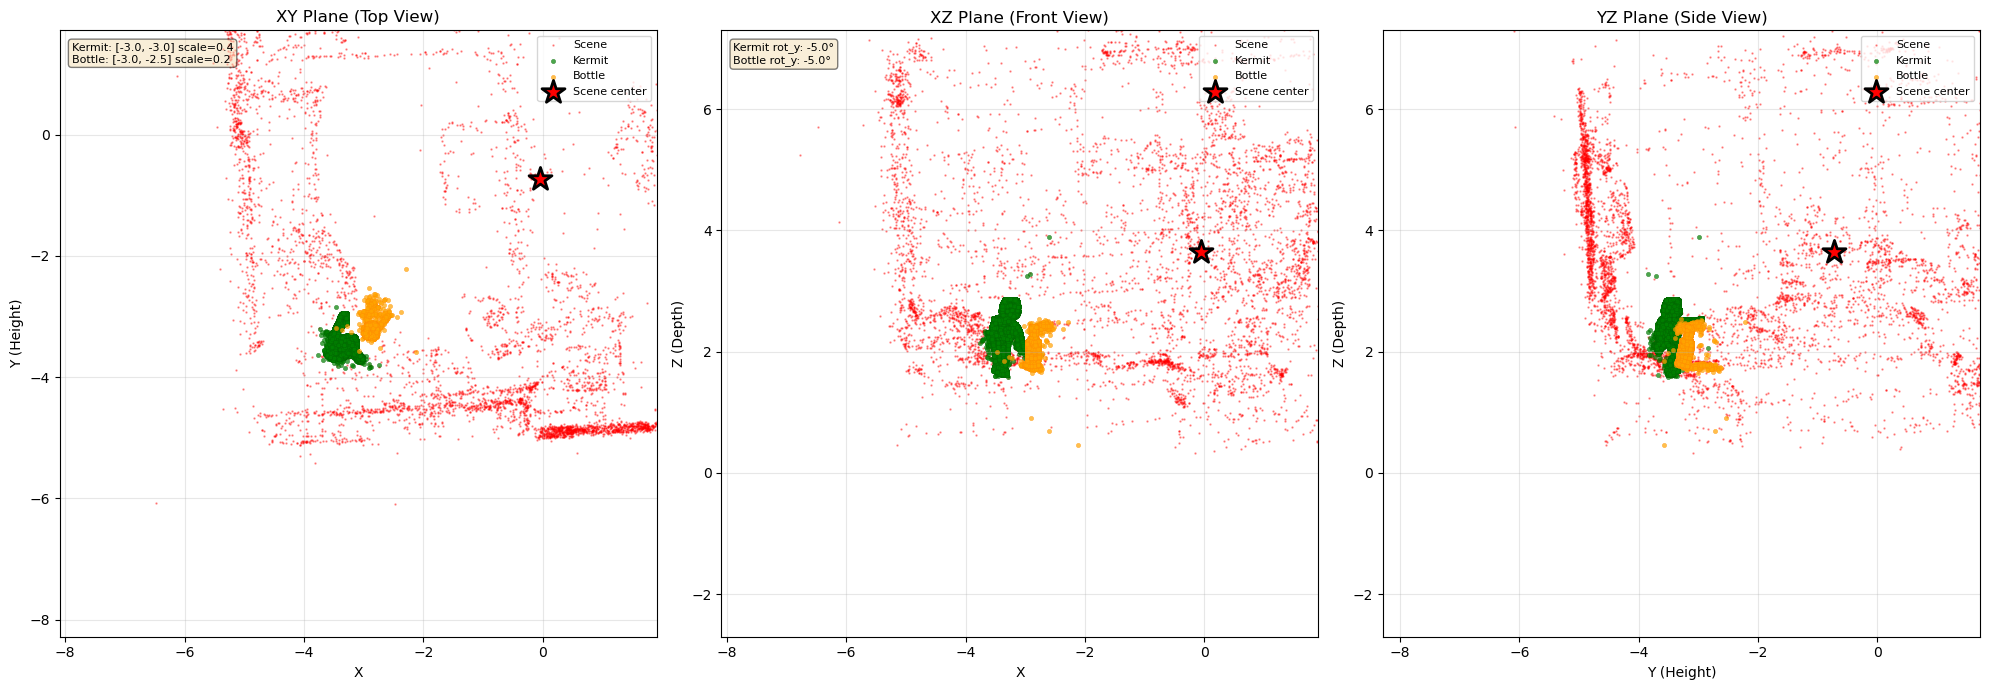

Saved: data/mv_demo/20251209_081245/keyframes/step45_object_placement_3planes.png


In [63]:
# Cell 5.4: Visualize Object Placement (3-Plane View)

print("\n" + "="*70)
print("3-PLANE VISUALIZATION: OBJECT PLACEMENT")
print("="*70)

# ★ 이 부분 추가: obj01_xyz, obj02_xyz 변수 할당
obj01_xyz = obj01_placed['xyz']
obj02_xyz = obj02_placed['xyz']

fig = plt.figure(figsize=(20, 7))

# Sample scene points
scene_sample_idx = np.random.choice(len(scene_xyz), min(8000, len(scene_xyz)), replace=False)

# Calculate view range based on both objects
obj_center_x = (obj01_bbox_after['center'][0] + obj02_bbox_after['center'][0]) / 2
obj_center_y = (obj01_bbox_after['center'][1] + obj02_bbox_after['center'][1]) / 2
obj_center_z = (obj01_bbox_after['center'][2] + obj02_bbox_after['center'][2]) / 2
margin = 5.0  # View margin

# =============================================================================
# XY Plane (Top View)
# =============================================================================
ax1 = fig.add_subplot(131)

# Scene background
ax1.scatter(scene_xyz[scene_sample_idx, 0], scene_xyz[scene_sample_idx, 1], 
           s=0.5, alpha=0.4, c='red', label='Scene')

# Objects
ax1.scatter(obj01_xyz[:, 0], obj01_xyz[:, 1], 
           s=10, alpha=0.7, c='green', edgecolors='darkgreen', linewidth=0.3, label='Kermit')
ax1.scatter(obj02_xyz[:, 0], obj02_xyz[:, 1], 
           s=10, alpha=0.7, c='orange', edgecolors='darkorange', linewidth=0.3, label='Bottle')

# Scene center only
ax1.scatter(scene_center[0], scene_center[1], 
           s=300, c='red', marker='*', edgecolors='black', linewidths=2, 
           label='Scene center', zorder=10)

# Object info text
info_text = f"Kermit: [{obj01_translation[0]:.1f}, {obj01_translation[1]:.1f}] scale={obj01_scale}\n"
info_text += f"Bottle: [{obj02_translation[0]:.1f}, {obj02_translation[1]:.1f}] scale={obj02_scale}"
ax1.text(0.02, 0.98, info_text, transform=ax1.transAxes, fontsize=8, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax1.set_xlabel('X')
ax1.set_ylabel('Y (Height)')
ax1.set_title('XY Plane (Top View)', fontsize=12)
ax1.legend(loc='upper right', fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([obj_center_x - margin, obj_center_x + margin])
ax1.set_ylim([obj_center_y - margin, obj_center_y + margin])

# =============================================================================
# XZ Plane (Front View)
# =============================================================================
ax2 = fig.add_subplot(132)

# Scene background
ax2.scatter(scene_xyz[scene_sample_idx, 0], scene_xyz[scene_sample_idx, 2], 
           s=0.5, alpha=0.4, c='red', label='Scene')

# Objects
ax2.scatter(obj01_xyz[:, 0], obj01_xyz[:, 2], 
           s=10, alpha=0.7, c='green', edgecolors='darkgreen', linewidth=0.3, label='Kermit')
ax2.scatter(obj02_xyz[:, 0], obj02_xyz[:, 2], 
           s=10, alpha=0.7, c='orange', edgecolors='darkorange', linewidth=0.3, label='Bottle')

# Scene center only
ax2.scatter(scene_center[0], scene_center[2], 
           s=300, c='red', marker='*', edgecolors='black', linewidths=2, 
           label='Scene center', zorder=10)

# Rotation info
rotation_text = f"Kermit rot_y: {obj01_rotation_y_deg}°\nBottle rot_y: {obj02_rotation_y_deg}°"
ax2.text(0.02, 0.98, rotation_text, transform=ax2.transAxes, fontsize=8, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax2.set_xlabel('X')
ax2.set_ylabel('Z (Depth)')
ax2.set_title('XZ Plane (Front View)', fontsize=12)
ax2.legend(loc='upper right', fontsize=8)
ax2.grid(True, alpha=0.3)
ax2.set_xlim([obj_center_x - margin, obj_center_x + margin])
ax2.set_ylim([obj_center_z - margin, obj_center_z + margin])

# =============================================================================
# YZ Plane (Side View)
# =============================================================================
ax3 = fig.add_subplot(133)

# Scene background
ax3.scatter(scene_xyz[scene_sample_idx, 1], scene_xyz[scene_sample_idx, 2], 
           s=0.5, alpha=0.4, c='red', label='Scene')

# Objects
ax3.scatter(obj01_xyz[:, 1], obj01_xyz[:, 2], 
           s=10, alpha=0.7, c='green', edgecolors='darkgreen', linewidth=0.3, label='Kermit')
ax3.scatter(obj02_xyz[:, 1], obj02_xyz[:, 2], 
           s=10, alpha=0.7, c='orange', edgecolors='darkorange', linewidth=0.3, label='Bottle')

# Scene center only
ax3.scatter(scene_center[1], scene_center[2], 
           s=300, c='red', marker='*', edgecolors='black', linewidths=2, 
           label='Scene center', zorder=10)

ax3.set_xlabel('Y (Height)')
ax3.set_ylabel('Z (Depth)')
ax3.set_title('YZ Plane (Side View)', fontsize=12)
ax3.legend(loc='upper right', fontsize=8)
ax3.grid(True, alpha=0.3)
ax3.set_xlim([obj_center_y - margin, obj_center_y + margin])
ax3.set_ylim([obj_center_z - margin, obj_center_z + margin])

plt.tight_layout()
plt.savefig(KEYFRAMES_DIR / "step45_object_placement_3planes.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {KEYFRAMES_DIR / 'step45_object_placement_3planes.png'}")

In [25]:
# Cell 5.6: Export Placement Visualization PLY

print("\n" + "="*70)
print("EXPORTING OBJECT PLACEMENT PLY")
print("="*70)

# Create scene center marker only
scene_center_marker = create_sphere_marker(
    center=scene_center,
    radius=0.5,
    n_points=1000,
    color=(1.0, 0.0, 0.0)  # Red
)

# Export: Scene + Objects + Scene center marker (no object center markers)
placement_viz_path = KEYFRAMES_DIR / "step45_scene_with_objects.ply"
merge_and_save_gaussians(
    gaussians_dict={
        "scene": scene_gaussians_aligned,
        "obj01_kermit": obj01_placed,
        "obj02_bottle": obj02_placed,
        "scene_center": scene_center_marker
    },
    output_path=placement_viz_path,
    verbose=False
)

print(f"\n✓ Exported: {placement_viz_path.name}")
print(f"  🔴 RED sphere = Scene center")
print(f"  🐸 GREEN points = Kermit object")
print(f"  🍾 ORANGE points = Bottle object")

print(f"\n💡 View in browser:")
print(f"  1. Go to: https://antimatter15.com/splat/")
print(f"  2. Drag & drop: {placement_viz_path.name}")
print(f"  3. Verify object placement in scene")
print(f"  4. Adjust positions in Cell 5.2 if needed and re-run")

print(f"\n📁 File location: {KEYFRAMES_DIR.absolute()}")

print("\n[OK] Step 4+5 complete: Object placement visualization exported")


EXPORTING OBJECT PLACEMENT PLY
  ✓ Saved: step45_scene_with_objects.ply
    Points: 1,689,321 | Size: 380.21 MB

✓ Exported: step45_scene_with_objects.ply
  🔴 RED sphere = Scene center
  🐸 GREEN points = Kermit object
  🍾 ORANGE points = Bottle object

💡 View in browser:
  1. Go to: https://antimatter15.com/splat/
  2. Drag & drop: step45_scene_with_objects.ply
  3. Verify object placement in scene
  4. Adjust positions in Cell 5.2 if needed and re-run

📁 File location: /home/ec2-user/SageMaker/3dgs/data/mv_demo/20251209_071249/keyframes

[OK] Step 4+5 complete: Object placement visualization exported


---
# Part 6: Step 6 - 애니메이션 궤적 생성

In [64]:
# Cell 6.0: Timeline Configuration for Animations

print("="*70)
print("ANIMATION TIMELINE CONFIGURATION")
print("="*70)

# =============================================================================
# Animation Timeline (11초로 확장)
# =============================================================================

# 전체 영상 시간 재설정
ANIMATION_DURATION = 11.0  # seconds
ANIMATION_FPS = 30
ANIMATION_N_FRAMES = int(ANIMATION_DURATION * ANIMATION_FPS)  # 330 frames

# 애니메이션 타임라인 (Part 6 전용)
ANIM_TIMELINE = {
    "static_1": {
        "start_sec": 0.0,
        "end_sec": 5.0,
        "description": "Both objects static"
    },
    "kermit_jump": {
        "start_sec": 5.0,
        "end_sec": 7.0,
        "description": "Kermit jumps (2s)"
    },
    "bottle_action": {
        "start_sec": 7.0,
        "end_sec": 9.0,
        "description": "Bottle moves to mouth + wobble"
    },
    "bottle_move": {
        "start_sec": 7.0,
        "end_sec": 8.0,
        "description": "Bottle moves to Kermit's mouth (1s)"
    },
    "bottle_wobble": {
        "start_sec": 8.0,
        "end_sec": 9.0,
        "description": "Bottle wobbles up/down (1s)"
    },
    "finale": {
        "start_sec": 9.0,
        "end_sec": 11.0,
        "description": "Kermit scales up, Bottle returns (2s)"
    },
}

# Frame 인덱스 계산
for seg_name, seg_data in ANIM_TIMELINE.items():
    seg_data["start_frame"] = int(seg_data["start_sec"] * ANIMATION_FPS)
    seg_data["end_frame"] = int(seg_data["end_sec"] * ANIMATION_FPS)
    seg_data["duration_sec"] = seg_data["end_sec"] - seg_data["start_sec"]
    seg_data["n_frames"] = seg_data["end_frame"] - seg_data["start_frame"]

print(f"\nTotal Animation Duration: {ANIMATION_DURATION}s ({ANIMATION_N_FRAMES} frames @ {ANIMATION_FPS}fps)")
print("\nAnimation Segments:")
for seg_name, seg_data in ANIM_TIMELINE.items():
    print(f"  {seg_name:20s}: {seg_data['start_sec']:5.1f}-{seg_data['end_sec']:5.1f}s "
          f"(frames {seg_data['start_frame']:3d}-{seg_data['end_frame']:3d}) - {seg_data['description']}")

print("\n[OK] Animation timeline configured")

ANIMATION TIMELINE CONFIGURATION

Total Animation Duration: 11.0s (330 frames @ 30fps)

Animation Segments:
  static_1            :   0.0-  5.0s (frames   0-150) - Both objects static
  kermit_jump         :   5.0-  7.0s (frames 150-210) - Kermit jumps (2s)
  bottle_action       :   7.0-  9.0s (frames 210-270) - Bottle moves to mouth + wobble
  bottle_move         :   7.0-  8.0s (frames 210-240) - Bottle moves to Kermit's mouth (1s)
  bottle_wobble       :   8.0-  9.0s (frames 240-270) - Bottle wobbles up/down (1s)
  finale              :   9.0- 11.0s (frames 270-330) - Kermit scales up, Bottle returns (2s)

[OK] Animation timeline configured


In [65]:
# Cell 6.1: Basic Animation Functions

print("\n" + "="*70)
print("BASIC ANIMATION FUNCTIONS")
print("="*70)

# =============================================================================
# Helper: Smooth Easing Functions
# =============================================================================

def ease_in_out_cubic(t):
    """Smooth ease-in-out cubic easing (0 to 1)"""
    if t < 0.5:
        return 4 * t * t * t
    else:
        return 1 - pow(-2 * t + 2, 3) / 2

def ease_out_bounce(t):
    """Bounce easing for landing"""
    n1 = 7.5625
    d1 = 2.75
    if t < 1 / d1:
        return n1 * t * t
    elif t < 2 / d1:
        t = t - 1.5 / d1
        return n1 * t * t + 0.75
    elif t < 2.5 / d1:
        t = t - 2.25 / d1
        return n1 * t * t + 0.9375
    else:
        t = t - 2.625 / d1
        return n1 * t * t + 0.984375

# =============================================================================
# Animation Primitives
# =============================================================================

def anim_rotate(
    base_quat: np.ndarray,
    rotation_deg: List[float],  # [x_deg, y_deg, z_deg, duration_sec]
    t_current: float,
    t_start: float
) -> np.ndarray:
    """
    Rotate object over duration.
    
    Args:
        base_quat: Starting rotation quaternion [w,x,y,z]
        rotation_deg: [x_deg, y_deg, z_deg, duration_sec]
        t_current: Current time
        t_start: Animation start time
    
    Returns:
        Rotated quaternion
    """
    x_deg, y_deg, z_deg, duration = rotation_deg
    
    # Progress (0 to 1)
    u = np.clip((t_current - t_start) / duration, 0, 1)
    u_smooth = ease_in_out_cubic(u)
    
    # Build rotation quaternion
    rot_x = axis_angle_to_quaternion(np.array([1, 0, 0], dtype=np.float32), np.deg2rad(x_deg * u_smooth))
    rot_y = axis_angle_to_quaternion(np.array([0, 1, 0], dtype=np.float32), np.deg2rad(y_deg * u_smooth))
    rot_z = axis_angle_to_quaternion(np.array([0, 0, 1], dtype=np.float32), np.deg2rad(z_deg * u_smooth))
    
    # Combine: rot_z * rot_y * rot_x * base
    combined = quaternion_multiply(rot_z, quaternion_multiply(rot_y, rot_x))
    result = quaternion_multiply(combined, base_quat)
    
    return result

def anim_move(
    base_trans: np.ndarray,
    displacement: List[float],  # [dx, dy, dz, duration_sec]
    t_current: float,
    t_start: float
) -> np.ndarray:
    """
    Move object by displacement over duration.
    
    Args:
        base_trans: Starting position [x,y,z]
        displacement: [dx, dy, dz, duration_sec]
        t_current: Current time
        t_start: Animation start time
    
    Returns:
        New position
    """
    dx, dy, dz, duration = displacement
    
    u = np.clip((t_current - t_start) / duration, 0, 1)
    u_smooth = ease_in_out_cubic(u)
    
    offset = np.array([dx, dy, dz], dtype=np.float32) * u_smooth
    return base_trans + offset

def anim_scale(
    base_scale: float,
    target_scale: float,
    duration_sec: float,
    t_current: float,
    t_start: float,
    bbox_z_min: float  # Original object Z minimum (for keeping bottom fixed)
) -> Tuple[float, np.ndarray]:
    """
    Scale object while keeping bottom fixed.
    
    Args:
        base_scale: Starting scale
        target_scale: Target scale
        duration_sec: Animation duration
        t_current: Current time
        t_start: Animation start time
        bbox_z_min: Object's original bbox Z minimum (before any scaling)
    
    Returns:
        (new_scale, z_translation_offset)
    """
    u = np.clip((t_current - t_start) / duration_sec, 0, 1)
    u_smooth = ease_in_out_cubic(u)
    
    new_scale = base_scale + (target_scale - base_scale) * u_smooth
    
    # Calculate Z offset to keep bottom fixed
    # When scaling up, the bottom would go down by: (new_scale - base_scale) * bbox_z_min
    # We compensate by lifting the object
    scale_diff = new_scale - base_scale
    z_offset = -scale_diff * bbox_z_min  # Lift up to compensate
    
    return new_scale, np.array([0, 0, z_offset], dtype=np.float32)

def anim_jump(
    base_trans: np.ndarray,
    jump_height: float,
    duration_sec: float,
    t_current: float,
    t_start: float
) -> np.ndarray:
    """
    Jump animation (parabolic Z motion).
    
    Args:
        base_trans: Starting position
        jump_height: Maximum jump height (Z axis)
        duration_sec: Animation duration
        t_current: Current time
        t_start: Animation start time
    
    Returns:
        New position
    """
    u = np.clip((t_current - t_start) / duration_sec, 0, 1)
    
    # Parabolic motion: sin for smooth up-down
    z_offset = jump_height * np.sin(np.pi * u)
    
    return base_trans + np.array([0, 0, z_offset], dtype=np.float32)

print("\n✓ Basic animation functions defined:")
print("  • anim_rotate(base_quat, [x,y,z,t], t_current, t_start)")
print("  • anim_move(base_trans, [dx,dy,dz,t], t_current, t_start)")
print("  • anim_scale(base_scale, target_scale, duration, t_current, t_start, bbox_z_min)")
print("  • anim_jump(base_trans, height, duration, t_current, t_start)")
print("\n[OK] Animation primitives ready")


BASIC ANIMATION FUNCTIONS

✓ Basic animation functions defined:
  • anim_rotate(base_quat, [x,y,z,t], t_current, t_start)
  • anim_move(base_trans, [dx,dy,dz,t], t_current, t_start)
  • anim_scale(base_scale, target_scale, duration, t_current, t_start, bbox_z_min)
  • anim_jump(base_trans, height, duration, t_current, t_start)

[OK] Animation primitives ready


In [66]:
# Cell 6.2: Object Animation Parameters

print("\n" + "="*70)
print("OBJECT ANIMATION PARAMETERS")
print("="*70)

# =============================================================================
# ★ MANUAL SETTINGS: Edit these values to adjust animations
# =============================================================================

# Object 1 (Kermit) Animations
KERMIT_ANIM = {
    # Jump (5-7s): Z축으로 2만큼 점프
    "jump": {
        "height": 2.0,  # Jump height
        "duration": ANIM_TIMELINE["kermit_jump"]["duration_sec"],
    },
    
    # Scale up (9-11s): 0.4 → 0.8
    "scale_up": {
        "target_scale": 0.8,
        "duration": ANIM_TIMELINE["finale"]["duration_sec"],
        "translation_offset": [0.5, 0.4, 0.0],  # ★ NEW: scale과 동시에 XY 이동
    }
}

# Object 2 (Bottle) Animations
BOTTLE_ANIM = {
    # Move to mouth (7-8s): 이동 + 회전
    "move_to_mouth": {
        "displacement": [0.1, 0.3, 1.0],  # [dx, dy, dz] - 수동 조정
        "rotation": [48, -40, -12, 1.0],  # [x_deg, y_deg, z_deg, duration]
        "duration": ANIM_TIMELINE["bottle_move"]["duration_sec"],
    },
    
    # Wobble (8-9s): Z축으로 짧은 점프 2-3회
    "wobble": {
        "height": 0.3,  # Wobble height
        "n_bounces": 2.5,  # Number of bounces
        "duration": ANIM_TIMELINE["bottle_wobble"]["duration_sec"],
    },
    
    # Return (9-11s): 원위치 복귀
    "return": {
        "duration": ANIM_TIMELINE["finale"]["duration_sec"],
    }
}

# Get original object bounding boxes (for scale compensation)
obj01_original_bbox = compute_bbox_and_span(obj01_gaussians_aligned, "Obj01 Original")
obj02_original_bbox = compute_bbox_and_span(obj02_gaussians_aligned, "Obj02 Original")

KERMIT_BBOX_Z_MIN = obj01_original_bbox['min'][2]
BOTTLE_BBOX_Z_MIN = obj02_original_bbox['min'][2]

print("\n=== Animation Parameters ===")
print(f"\nKermit:")
print(f"  Jump height: {KERMIT_ANIM['jump']['height']}")
print(f"  Jump duration: {KERMIT_ANIM['jump']['duration']}s")
print(f"  Scale: {INITIAL_POSES['obj01']['scale']} → {KERMIT_ANIM['scale_up']['target_scale']}")
print(f"  Scale-up translation: {KERMIT_ANIM['scale_up']['translation_offset']}")  # ★ NEW
print(f"  Original bbox Z min: {KERMIT_BBOX_Z_MIN:.3f}")

print(f"\nBottle:")
print(f"  Move displacement: {BOTTLE_ANIM['move_to_mouth']['displacement']}")
print(f"  Move rotation: {BOTTLE_ANIM['move_to_mouth']['rotation'][:3]}° over {BOTTLE_ANIM['move_to_mouth']['rotation'][3]}s")
print(f"  Wobble height: {BOTTLE_ANIM['wobble']['height']}")
print(f"  Wobble bounces: {BOTTLE_ANIM['wobble']['n_bounces']}")
print(f"  Original bbox Z min: {BOTTLE_BBOX_Z_MIN:.3f}")

print("\n💡 TIP: Edit this cell to adjust animation parameters")
print("\n[OK] Animation parameters configured")


OBJECT ANIMATION PARAMETERS

=== Animation Parameters ===

Kermit:
  Jump height: 2.0
  Jump duration: 2.0s
  Scale: 0.4 → 0.8
  Scale-up translation: [0.5, 0.4, 0.0]
  Original bbox Z min: 1.254

Bottle:
  Move displacement: [0.1, 0.3, 1.0]
  Move rotation: [48, -40, -12]° over 1.0s
  Wobble height: 0.3
  Wobble bounces: 2.5
  Original bbox Z min: -5.598

💡 TIP: Edit this cell to adjust animation parameters

[OK] Animation parameters configured


In [67]:
# Cell 6.3: Generate Object Animation Trajectories

print("\n" + "="*70)
print("GENERATE OBJECT ANIMATIONS")
print("="*70)

# =============================================================================
# Kermit (Obj01) Animation Generator
# =============================================================================

def generate_kermit_animation(
    initial_pose: Dict,
    n_frames: int,
    fps: int
) -> List[Dict]:
    """
    Generate Kermit animation trajectory based on ANIM_TIMELINE.
    
    Timeline:
    - 0-5s: Static
    - 5-7s: Jump (Z axis)
    - 7-9s: Static
    - 9-11s: Scale up (0.4 → 0.8) + XY translation
    """
    frames = []
    
    base_trans = np.array(initial_pose["translation"], dtype=np.float32)
    base_rot = np.array(initial_pose["rotation_quat"], dtype=np.float32)
    base_scale = initial_pose["scale"]
    
    # Timeline shortcuts
    T_jump = ANIM_TIMELINE["kermit_jump"]
    T_finale = ANIM_TIMELINE["finale"]
    
    for f in range(n_frames):
        t = f / fps
        
        # Default state
        trans = base_trans.copy()
        rot = base_rot.copy()
        scale = base_scale
        
        # Timeline-based animations
        if t < T_jump["start_sec"]:
            # Static (0-5s)
            pass
        
        elif t < T_jump["end_sec"]:
            # Jump (5-7s)
            trans = anim_jump(
                base_trans,
                KERMIT_ANIM["jump"]["height"],
                KERMIT_ANIM["jump"]["duration"],
                t,
                T_jump["start_sec"]
            )
        
        elif t < T_finale["start_sec"]:
            # Static (7-9s)
            pass
        
        else:
            # Scale up + XY translation (9-11s)
            u = (t - T_finale["start_sec"]) / T_finale["duration_sec"]
            u = np.clip(u, 0, 1)
            u_smooth = ease_in_out_cubic(u)
            
            # Scale
            scale, z_offset = anim_scale(
                base_scale,
                KERMIT_ANIM["scale_up"]["target_scale"],
                KERMIT_ANIM["scale_up"]["duration"],
                t,
                T_finale["start_sec"],
                KERMIT_BBOX_Z_MIN
            )
            
            # ★ NEW: Additional XY translation during scale-up
            xy_offset = np.array(
                KERMIT_ANIM["scale_up"]["translation_offset"], 
                dtype=np.float32
            ) * u_smooth
            
            trans = base_trans + z_offset + xy_offset
        
        frames.append({
            "frame": f,
            "translation": trans.tolist(),
            "rotation_quat": rot.tolist(),
            "scale": scale
        })
    
    return frames

# =============================================================================
# Bottle (Obj02) Animation Generator (변경 없음)
# =============================================================================

def generate_bottle_animation(
    initial_pose: Dict,
    n_frames: int,
    fps: int
) -> List[Dict]:
    """
    Generate Bottle animation trajectory based on ANIM_TIMELINE.
    
    Timeline:
    - 0-5s: Static
    - 5-7s: Static
    - 7-8s: Move to mouth + rotate
    - 8-9s: Wobble (short jumps)
    - 9-11s: Return to original position
    """
    frames = []
    
    base_trans = np.array(initial_pose["translation"], dtype=np.float32)
    base_rot = np.array(initial_pose["rotation_quat"], dtype=np.float32)
    base_scale = initial_pose["scale"]
    
    # Timeline shortcuts
    T_move = ANIM_TIMELINE["bottle_move"]
    T_wobble = ANIM_TIMELINE["bottle_wobble"]
    T_finale = ANIM_TIMELINE["finale"]
    
    # Calculate target position after move
    move_disp = np.array(BOTTLE_ANIM["move_to_mouth"]["displacement"], dtype=np.float32)
    target_trans = base_trans + move_disp
    
    # Calculate target rotation
    rot_params = BOTTLE_ANIM["move_to_mouth"]["rotation"]
    target_rot = anim_rotate(
        base_rot,
        rot_params,
        T_move["end_sec"],
        T_move["start_sec"]
    )
    
    for f in range(n_frames):
        t = f / fps
        
        # Default state
        trans = base_trans.copy()
        rot = base_rot.copy()
        scale = base_scale
        
        # Timeline-based animations
        if t < T_move["start_sec"]:
            # Static (0-7s)
            pass
        
        elif t < T_move["end_sec"]:
            # Move to mouth + rotate (7-8s)
            trans = anim_move(
                base_trans,
                BOTTLE_ANIM["move_to_mouth"]["displacement"] + [BOTTLE_ANIM["move_to_mouth"]["duration"]],
                t,
                T_move["start_sec"]
            )
            rot = anim_rotate(
                base_rot,
                BOTTLE_ANIM["move_to_mouth"]["rotation"],
                t,
                T_move["start_sec"]
            )
        
        elif t < T_wobble["end_sec"]:
            # Wobble at target position (8-9s)
            wobble_u = (t - T_wobble["start_sec"]) / T_wobble["duration_sec"]
            wobble_offset = BOTTLE_ANIM["wobble"]["height"] * np.sin(
                2 * np.pi * BOTTLE_ANIM["wobble"]["n_bounces"] * wobble_u
            )
            
            trans = target_trans + np.array([0, 0, wobble_offset], dtype=np.float32)
            rot = target_rot.copy()
        
        elif t < T_finale["end_sec"]:
            # Return to original (9-11s)
            return_u = (t - T_finale["start_sec"]) / T_finale["duration_sec"]
            return_u_smooth = ease_in_out_cubic(return_u)
            
            trans = target_trans * (1 - return_u_smooth) + base_trans * return_u_smooth
            
            # Reverse rotation (interpolate back to base_rot)
            rot = target_rot * (1 - return_u_smooth) + base_rot * return_u_smooth
            rot = rot / np.linalg.norm(rot)  # Normalize
        
        else:
            # Final static state
            pass
        
        frames.append({
            "frame": f,
            "translation": trans.tolist(),
            "rotation_quat": rot.tolist(),
            "scale": scale
        })
    
    return frames

print("\n✓ Animation generator functions defined")
print("  → Kermit: Static → Jump → Static → Scale-up with XY translation")
print("  → Bottle: Static → Move+Rotate → Wobble → Return")
print("\n[OK] Ready to generate animations")


GENERATE OBJECT ANIMATIONS

✓ Animation generator functions defined
  → Kermit: Static → Jump → Static → Scale-up with XY translation
  → Bottle: Static → Move+Rotate → Wobble → Return

[OK] Ready to generate animations


In [68]:
# Cell 6.4: Execute Animation Generation

print("\n" + "="*70)
print("EXECUTING ANIMATION GENERATION")
print("="*70)

# Generate animations
print("\nGenerating Kermit animation...")
obj01_animation = generate_kermit_animation(
    INITIAL_POSES["obj01"],
    ANIMATION_N_FRAMES,
    ANIMATION_FPS
)
print(f"  ✓ Generated {len(obj01_animation)} frames")

print("\nGenerating Bottle animation...")
obj02_animation = generate_bottle_animation(
    INITIAL_POSES["obj02"],
    ANIMATION_N_FRAMES,
    ANIMATION_FPS
)
print(f"  ✓ Generated {len(obj02_animation)} frames")

# Extract positions, rotations, scales for analysis
obj01_positions = np.array([frame["translation"] for frame in obj01_animation])
obj01_scales = np.array([frame["scale"] for frame in obj01_animation])

obj02_positions = np.array([frame["translation"] for frame in obj02_animation])
obj02_scales = np.array([frame["scale"] for frame in obj02_animation])

times = np.arange(ANIMATION_N_FRAMES) / ANIMATION_FPS

# Summary statistics
print("\n" + "="*70)
print("ANIMATION SUMMARY")
print("="*70)

print("\nKermit:")
print(f"  Position range X: [{obj01_positions[:, 0].min():.3f}, {obj01_positions[:, 0].max():.3f}]")
print(f"  Position range Y: [{obj01_positions[:, 1].min():.3f}, {obj01_positions[:, 1].max():.3f}]")
print(f"  Position range Z: [{obj01_positions[:, 2].min():.3f}, {obj01_positions[:, 2].max():.3f}]")
print(f"  Scale range: [{obj01_scales.min():.3f}, {obj01_scales.max():.3f}]")
print(f"  Max jump height: {obj01_positions[:, 2].max() - obj01_positions[0, 2]:.3f}")

print("\nBottle:")
print(f"  Position range X: [{obj02_positions[:, 0].min():.3f}, {obj02_positions[:, 0].max():.3f}]")
print(f"  Position range Y: [{obj02_positions[:, 1].min():.3f}, {obj02_positions[:, 1].max():.3f}]")
print(f"  Position range Z: [{obj02_positions[:, 2].min():.3f}, {obj02_positions[:, 2].max():.3f}]")
print(f"  Max distance traveled: {np.linalg.norm(obj02_positions - obj02_positions[0], axis=1).max():.3f}")

print("\n[OK] Animations generated successfully")


EXECUTING ANIMATION GENERATION

Generating Kermit animation...
  ✓ Generated 330 frames

Generating Bottle animation...
  ✓ Generated 330 frames

ANIMATION SUMMARY

Kermit:
  Position range X: [-3.000, -2.500]
  Position range Y: [-3.000, -2.600]
  Position range Z: [0.599, 3.100]
  Scale range: [0.400, 0.800]
  Max jump height: 2.000

Bottle:
  Position range X: [-3.000, -2.900]
  Position range Y: [-2.500, -2.200]
  Position range Z: [1.500, 2.800]
  Max distance traveled: 1.338

[OK] Animations generated successfully



ANIMATION VISUALIZATION


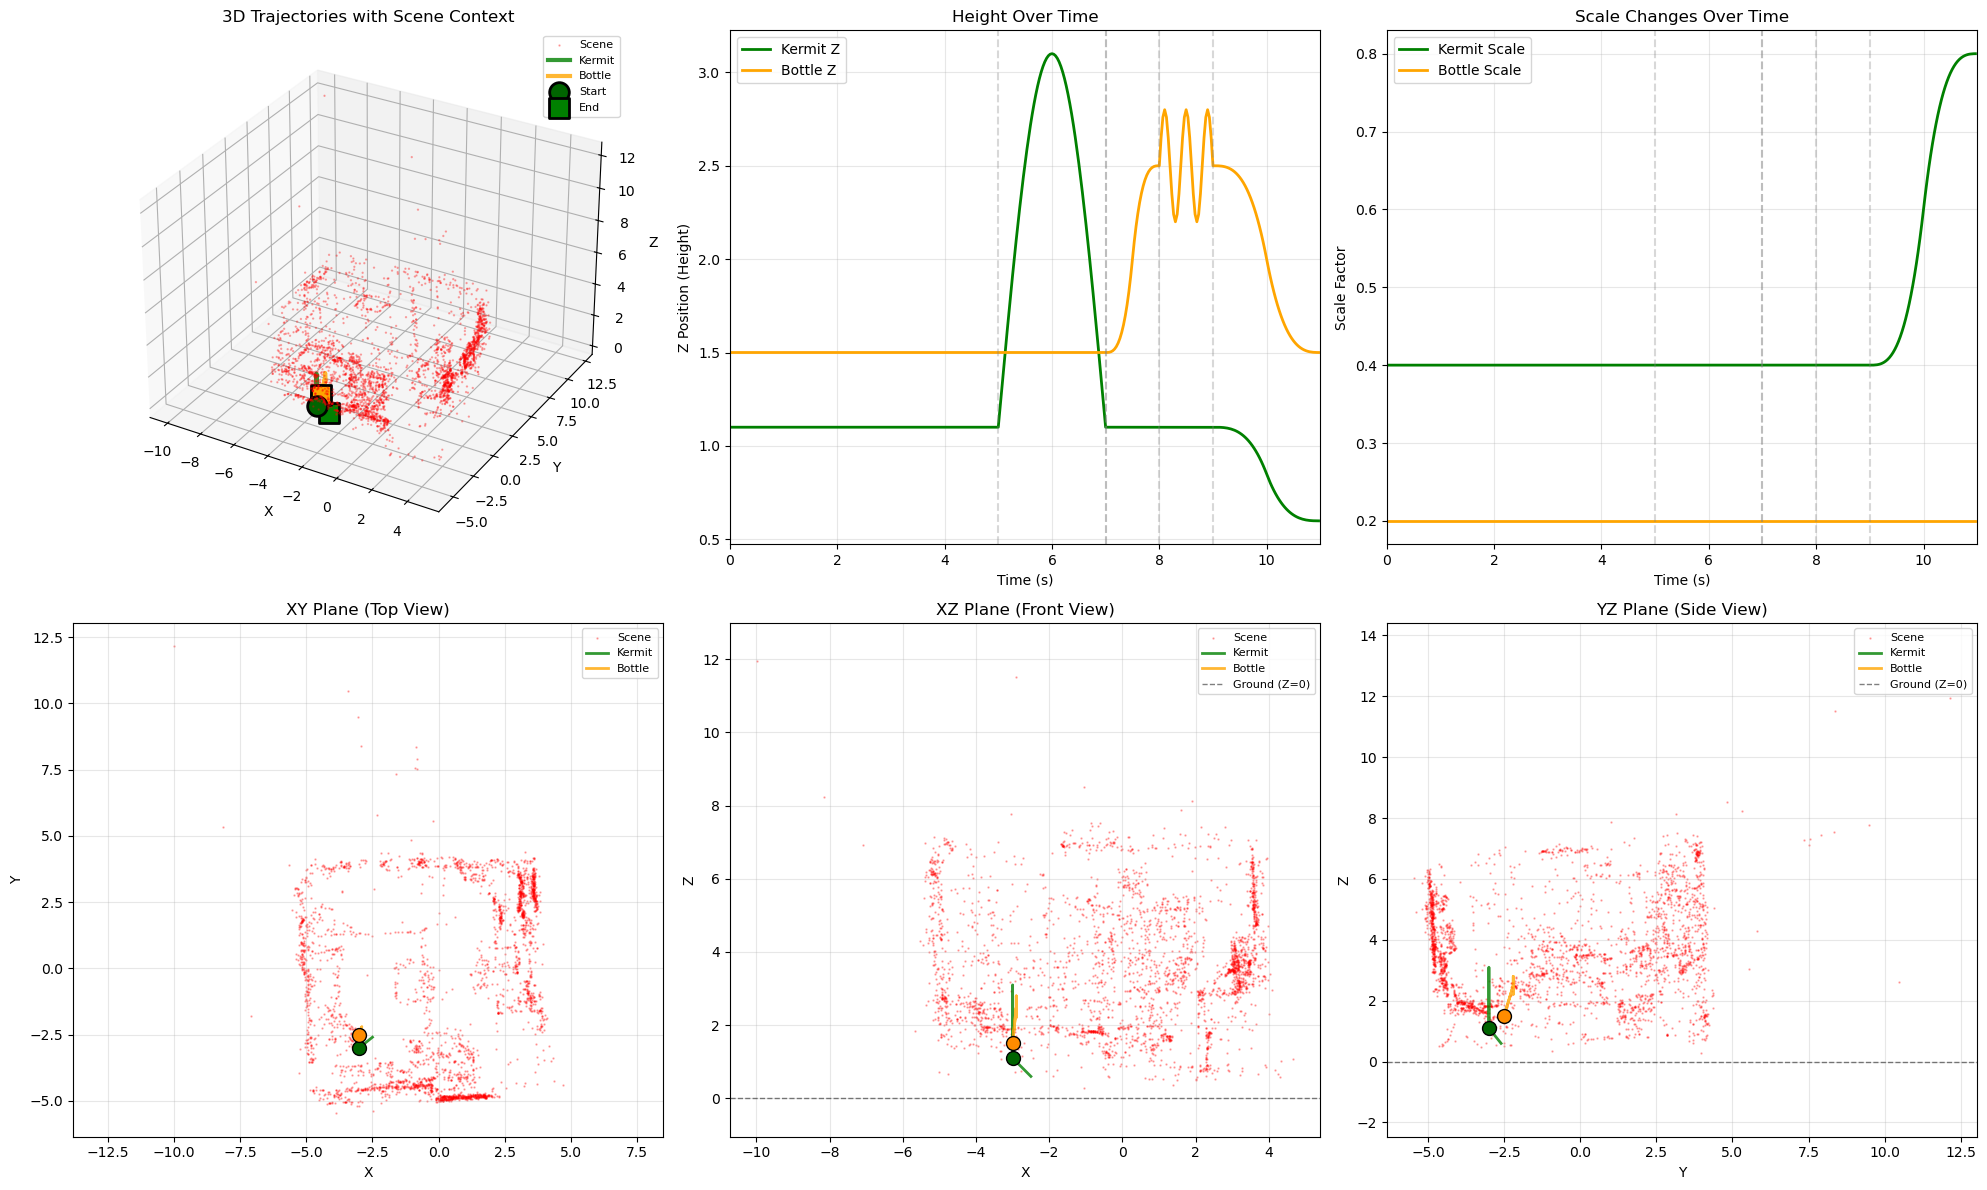


Saved: data/mv_demo/20251209_081245/keyframes/step6_animation_trajectories.png


In [32]:
# Cell 6.5: Visualize Animation Trajectories

print("\n" + "="*70)
print("ANIMATION VISUALIZATION")
print("="*70)

# =============================================================================
# Figure 1: Trajectory Overview (3D + Time Series)
# =============================================================================

fig = plt.figure(figsize=(20, 12))

# Sample scene points for context
scene_xyz = scene_gaussians_aligned['xyz']
scene_sample_idx = np.random.choice(len(scene_xyz), min(3000, len(scene_xyz)), replace=False)
scene_sample = scene_xyz[scene_sample_idx]

# --- Row 1: 3D Trajectories ---

# 3D trajectory with scene context
ax1 = fig.add_subplot(2, 3, 1, projection='3d')
ax1.scatter(scene_sample[:, 0], scene_sample[:, 1], scene_sample[:, 2],
           s=0.5, alpha=0.3, c='red', label='Scene')
ax1.plot(obj01_positions[:, 0], obj01_positions[:, 1], obj01_positions[:, 2],
        c='green', linewidth=3, label='Kermit', alpha=0.8)
ax1.plot(obj02_positions[:, 0], obj02_positions[:, 1], obj02_positions[:, 2],
        c='orange', linewidth=3, label='Bottle', alpha=0.8)

# Mark start/end
ax1.scatter(*obj01_positions[0], s=200, c='darkgreen', marker='o', edgecolors='black', linewidths=2, label='Start')
ax1.scatter(*obj02_positions[0], s=200, c='darkorange', marker='o', edgecolors='black', linewidths=2)
ax1.scatter(*obj01_positions[-1], s=200, c='green', marker='s', edgecolors='black', linewidths=2, label='End')
ax1.scatter(*obj02_positions[-1], s=200, c='orange', marker='s', edgecolors='black', linewidths=2)

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('3D Trajectories with Scene Context')
ax1.legend(loc='upper right', fontsize=8)

# Z position over time (showing jumps/movements)
ax2 = fig.add_subplot(2, 3, 2)
ax2.plot(times, obj01_positions[:, 2], c='green', linewidth=2, label='Kermit Z')
ax2.plot(times, obj02_positions[:, 2], c='orange', linewidth=2, label='Bottle Z')

# Timeline markers
for seg_name, seg_data in ANIM_TIMELINE.items():
    if seg_data['start_sec'] > 0:
        ax2.axvline(seg_data['start_sec'], color='gray', linestyle='--', alpha=0.3)

ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Z Position (Height)')
ax2.set_title('Height Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, ANIMATION_DURATION])

# Scale over time
ax3 = fig.add_subplot(2, 3, 3)
ax3.plot(times, obj01_scales, c='green', linewidth=2, label='Kermit Scale')
ax3.plot(times, obj02_scales, c='orange', linewidth=2, label='Bottle Scale')

for seg_name, seg_data in ANIM_TIMELINE.items():
    if seg_data['start_sec'] > 0:
        ax3.axvline(seg_data['start_sec'], color='gray', linestyle='--', alpha=0.3)

ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Scale Factor')
ax3.set_title('Scale Changes Over Time')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, ANIMATION_DURATION])

# --- Row 2: XY, XZ, YZ Plane Trajectories ---

# XY Plane (Top View)
ax4 = fig.add_subplot(2, 3, 4)
ax4.scatter(scene_sample[:, 0], scene_sample[:, 1], s=0.5, alpha=0.3, c='red', label='Scene')
ax4.plot(obj01_positions[:, 0], obj01_positions[:, 1], c='green', linewidth=2, label='Kermit', alpha=0.8)
ax4.plot(obj02_positions[:, 0], obj02_positions[:, 1], c='orange', linewidth=2, label='Bottle', alpha=0.8)
ax4.scatter(obj01_positions[0, 0], obj01_positions[0, 1], s=100, c='darkgreen', marker='o', edgecolors='black', linewidths=1, zorder=10)
ax4.scatter(obj02_positions[0, 0], obj02_positions[0, 1], s=100, c='darkorange', marker='o', edgecolors='black', linewidths=1, zorder=10)
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
ax4.set_title('XY Plane (Top View)')
ax4.legend(loc='upper right', fontsize=8)
ax4.grid(True, alpha=0.3)
ax4.axis('equal')

# XZ Plane (Front View)
ax5 = fig.add_subplot(2, 3, 5)
ax5.scatter(scene_sample[:, 0], scene_sample[:, 2], s=0.5, alpha=0.3, c='red', label='Scene')
ax5.plot(obj01_positions[:, 0], obj01_positions[:, 2], c='green', linewidth=2, label='Kermit', alpha=0.8)
ax5.plot(obj02_positions[:, 0], obj02_positions[:, 2], c='orange', linewidth=2, label='Bottle', alpha=0.8)
ax5.scatter(obj01_positions[0, 0], obj01_positions[0, 2], s=100, c='darkgreen', marker='o', edgecolors='black', linewidths=1, zorder=10)
ax5.scatter(obj02_positions[0, 0], obj02_positions[0, 2], s=100, c='darkorange', marker='o', edgecolors='black', linewidths=1, zorder=10)
ax5.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Ground (Z=0)')
ax5.set_xlabel('X')
ax5.set_ylabel('Z')
ax5.set_title('XZ Plane (Front View)')
ax5.legend(loc='upper right', fontsize=8)
ax5.grid(True, alpha=0.3)
ax5.axis('equal')

# YZ Plane (Side View)
ax6 = fig.add_subplot(2, 3, 6)
ax6.scatter(scene_sample[:, 1], scene_sample[:, 2], s=0.5, alpha=0.3, c='red', label='Scene')
ax6.plot(obj01_positions[:, 1], obj01_positions[:, 2], c='green', linewidth=2, label='Kermit', alpha=0.8)
ax6.plot(obj02_positions[:, 1], obj02_positions[:, 2], c='orange', linewidth=2, label='Bottle', alpha=0.8)
ax6.scatter(obj01_positions[0, 1], obj01_positions[0, 2], s=100, c='darkgreen', marker='o', edgecolors='black', linewidths=1, zorder=10)
ax6.scatter(obj02_positions[0, 1], obj02_positions[0, 2], s=100, c='darkorange', marker='o', edgecolors='black', linewidths=1, zorder=10)
ax6.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Ground (Z=0)')
ax6.set_xlabel('Y')
ax6.set_ylabel('Z')
ax6.set_title('YZ Plane (Side View)')
ax6.legend(loc='upper right', fontsize=8)
ax6.grid(True, alpha=0.3)
ax6.axis('equal')

plt.tight_layout()
plt.savefig(KEYFRAMES_DIR / "step6_animation_trajectories.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved: {KEYFRAMES_DIR / 'step6_animation_trajectories.png'}")


FRAME-BY-FRAME 3-PLANE VISUALIZATION

Generating key frame visualizations...

Start (0s): Frame 0
  Saved: data/mv_demo/20251209_081245/keyframes/frame_0000_3planes.png


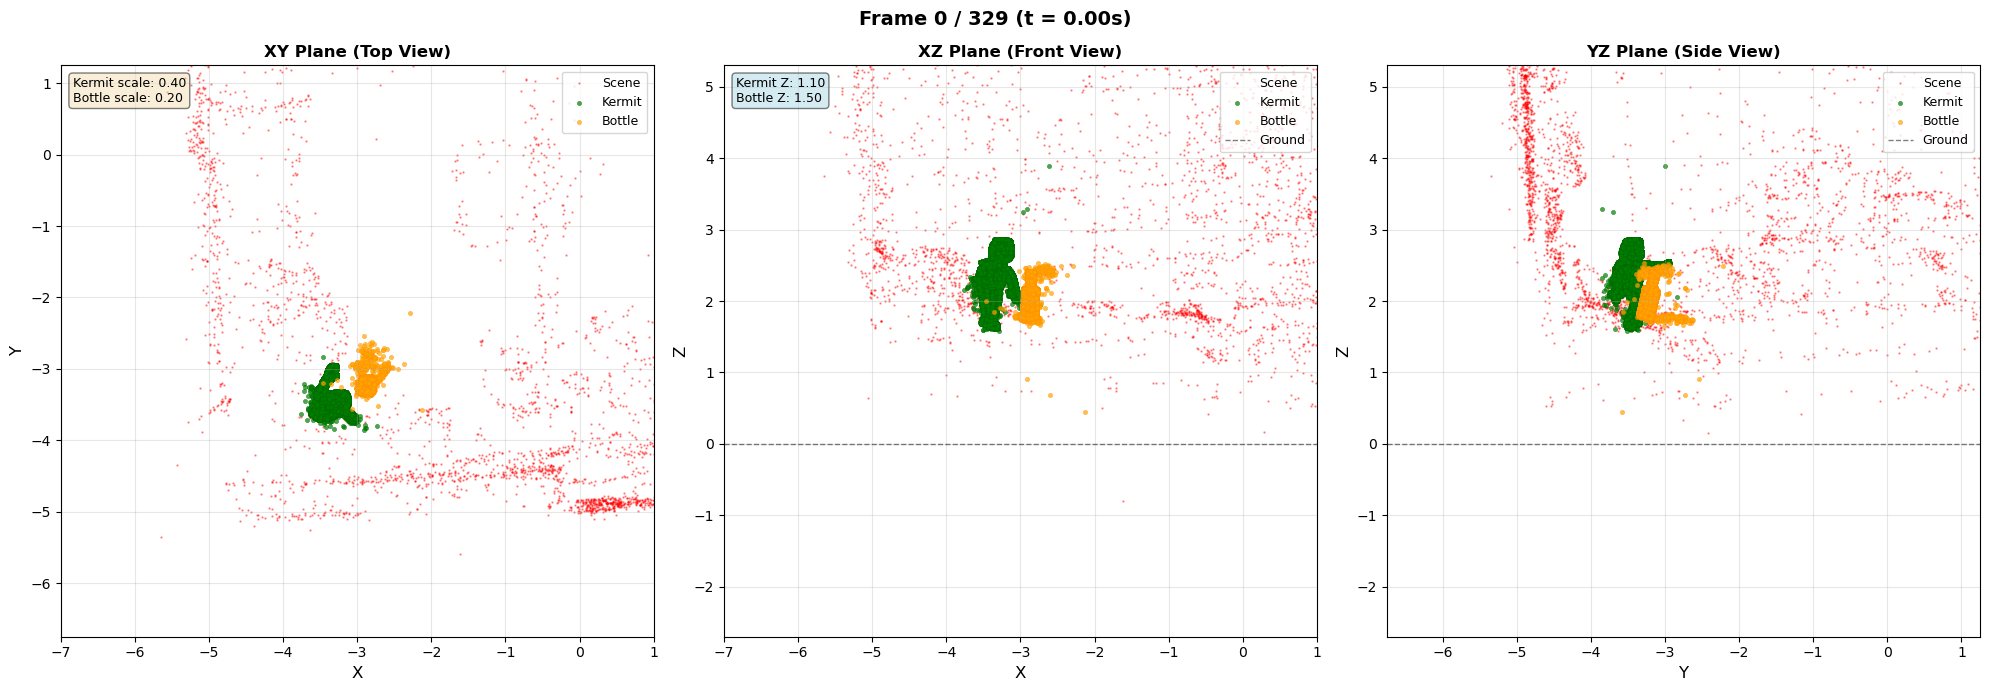


Bottle at Mouth (7.9s): Frame 237
  Saved: data/mv_demo/20251209_081245/keyframes/frame_0237_3planes.png


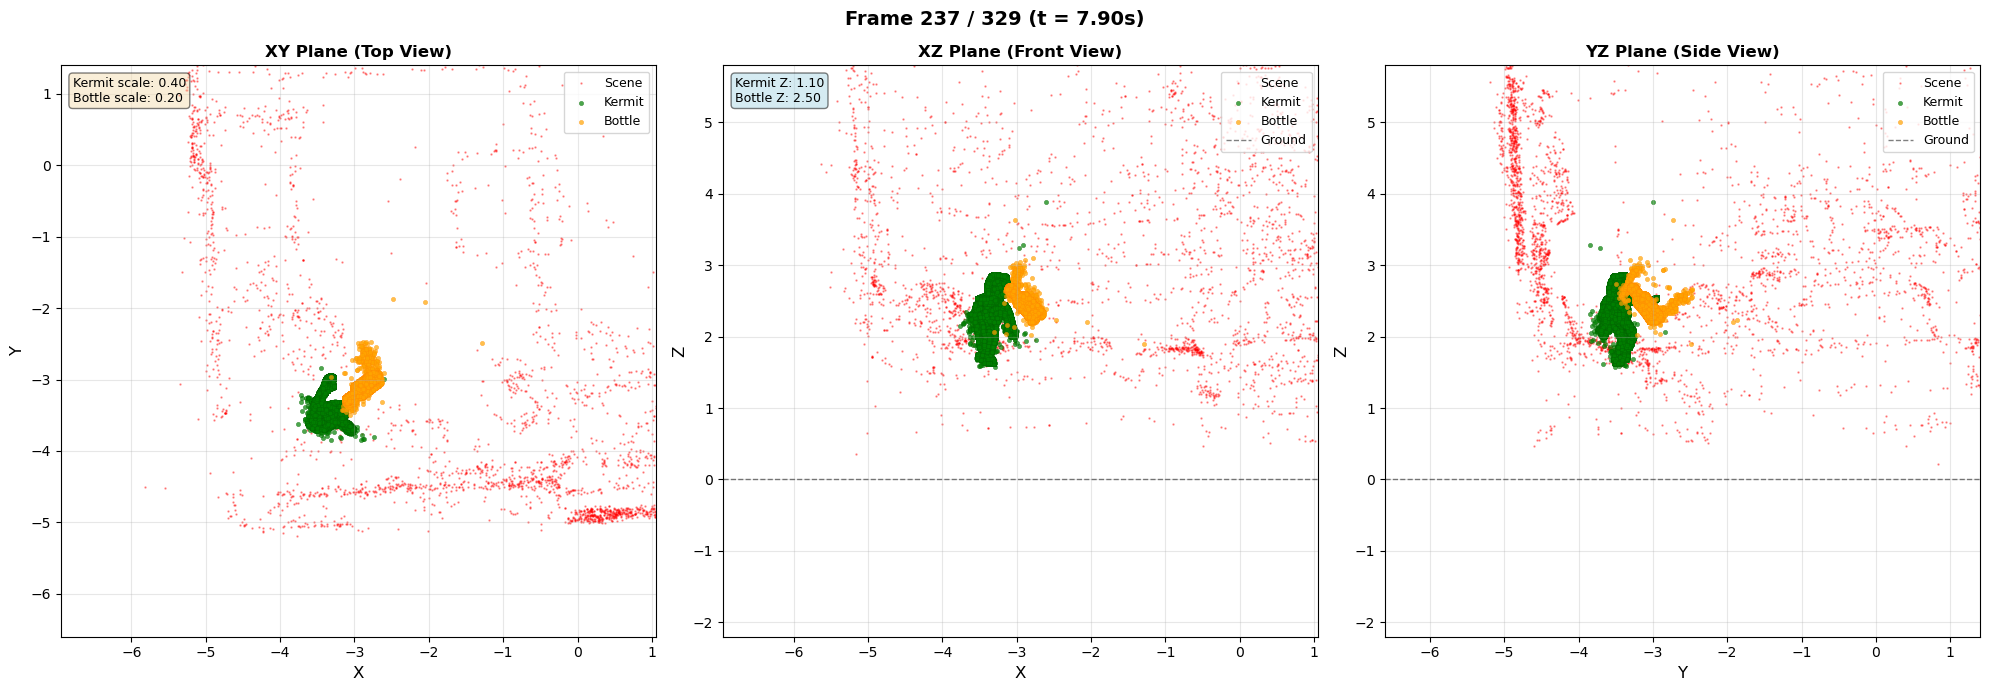


KEY FRAMES VISUALIZATION COMPLETE

Saved 2 key frame images to: data/mv_demo/20251209_081245/keyframes

💡 To visualize any specific frame, use:
   visualize_frame_3planes(frame_idx)
   Example: visualize_frame_3planes(180)  # Frame 180 (6.0s)


In [33]:
# Cell 6.6: Frame-by-Frame 3-Plane Visualization

print("\n" + "="*70)
print("FRAME-BY-FRAME 3-PLANE VISUALIZATION")
print("="*70)

# =============================================================================
# Interactive Frame Selector
# =============================================================================

def visualize_frame_3planes(frame_idx: int, save: bool = False):
    """
    Visualize a specific frame with objects and scene in 3 planes.
    
    Args:
        frame_idx: Frame index to visualize
        save: Whether to save the figure
    """
    if frame_idx < 0 or frame_idx >= ANIMATION_N_FRAMES:
        print(f"Error: Frame {frame_idx} out of range [0, {ANIMATION_N_FRAMES-1}]")
        return
    
    t = frame_idx / ANIMATION_FPS
    
    # Get object states at this frame
    obj01_frame = obj01_animation[frame_idx]
    obj02_frame = obj02_animation[frame_idx]
    
    # Transform objects to this frame's pose
    obj01_at_frame = transform_gaussians_legacy(
        obj01_gaussians_aligned,
        translation=np.array(obj01_frame["translation"], dtype=np.float32),
        rotation_quat=np.array(obj01_frame["rotation_quat"], dtype=np.float32),
        scale=obj01_frame["scale"]
    )
    
    obj02_at_frame = transform_gaussians_legacy(
        obj02_gaussians_aligned,
        translation=np.array(obj02_frame["translation"], dtype=np.float32),
        rotation_quat=np.array(obj02_frame["rotation_quat"], dtype=np.float32),
        scale=obj02_frame["scale"]
    )
    
    # Sample points
    scene_xyz = scene_gaussians_aligned['xyz']
    scene_sample_idx = np.random.choice(len(scene_xyz), min(5000, len(scene_xyz)), replace=False)
    
    obj01_xyz = obj01_at_frame['xyz']
    obj02_xyz = obj02_at_frame['xyz']
    
    # Calculate view range (center on objects)
    obj_center = (np.array(obj01_frame["translation"]) + np.array(obj02_frame["translation"])) / 2
    margin = 4.0
    
    # Create figure
    fig = plt.figure(figsize=(20, 7))
    fig.suptitle(f'Frame {frame_idx} / {ANIMATION_N_FRAMES-1} (t = {t:.2f}s)', fontsize=14, fontweight='bold')
    
    # =============================================================================
    # XY Plane (Top View)
    # =============================================================================
    ax1 = fig.add_subplot(131)
    
    # Scene (red dots)
    ax1.scatter(scene_xyz[scene_sample_idx, 0], scene_xyz[scene_sample_idx, 1], 
               s=0.5, alpha=0.4, c='red', label='Scene')
    
    # Kermit
    ax1.scatter(obj01_xyz[:, 0], obj01_xyz[:, 1], 
               s=10, alpha=0.7, c='green', edgecolors='darkgreen', linewidth=0.3, label='Kermit')
    # ax1.scatter(obj01_frame["translation"][0], obj01_frame["translation"][1],
    #            s=200, c='green', marker='*', edgecolors='black', linewidths=2, zorder=10)
    
    # Bottle
    ax1.scatter(obj02_xyz[:, 0], obj02_xyz[:, 1], 
               s=10, alpha=0.7, c='orange', edgecolors='darkorange', linewidth=0.3, label='Bottle')
    # ax1.scatter(obj02_frame["translation"][0], obj02_frame["translation"][1],
    #            s=200, c='orange', marker='*', edgecolors='black', linewidths=2, zorder=10)
    
    ax1.set_xlabel('X', fontsize=12)
    ax1.set_ylabel('Y', fontsize=12)
    ax1.set_title('XY Plane (Top View)', fontsize=12, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([obj_center[0] - margin, obj_center[0] + margin])
    ax1.set_ylim([obj_center[1] - margin, obj_center[1] + margin])
    
    # Add info text
    info_text = f"Kermit scale: {obj01_frame['scale']:.2f}\nBottle scale: {obj02_frame['scale']:.2f}"
    ax1.text(0.02, 0.98, info_text, transform=ax1.transAxes, 
            fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # =============================================================================
    # XZ Plane (Front View)
    # =============================================================================
    ax2 = fig.add_subplot(132)
    
    # Scene
    ax2.scatter(scene_xyz[scene_sample_idx, 0], scene_xyz[scene_sample_idx, 2], 
               s=0.5, alpha=0.4, c='red', label='Scene')
    
    # Kermit
    ax2.scatter(obj01_xyz[:, 0], obj01_xyz[:, 2], 
               s=10, alpha=0.7, c='green', edgecolors='darkgreen', linewidth=0.3, label='Kermit')
    # ax2.scatter(obj01_frame["translation"][0], obj01_frame["translation"][2],
    #            s=200, c='green', marker='*', edgecolors='black', linewidths=2, zorder=10)
    
    # Bottle
    ax2.scatter(obj02_xyz[:, 0], obj02_xyz[:, 2], 
               s=10, alpha=0.7, c='orange', edgecolors='darkorange', linewidth=0.3, label='Bottle')
    # ax2.scatter(obj02_frame["translation"][0], obj02_frame["translation"][2],
    #            s=200, c='orange', marker='*', edgecolors='black', linewidths=2, zorder=10)
    
    # Ground line
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Ground')
    
    ax2.set_xlabel('X', fontsize=12)
    ax2.set_ylabel('Z', fontsize=12)
    ax2.set_title('XZ Plane (Front View)', fontsize=12, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=9)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([obj_center[0] - margin, obj_center[0] + margin])
    ax2.set_ylim([obj_center[2] - margin, obj_center[2] + margin])
    
    # Add position info
    pos_text = f"Kermit Z: {obj01_frame['translation'][2]:.2f}\nBottle Z: {obj02_frame['translation'][2]:.2f}"
    ax2.text(0.02, 0.98, pos_text, transform=ax2.transAxes, 
            fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    # =============================================================================
    # YZ Plane (Side View)
    # =============================================================================
    ax3 = fig.add_subplot(133)
    
    # Scene
    ax3.scatter(scene_xyz[scene_sample_idx, 1], scene_xyz[scene_sample_idx, 2], 
               s=0.5, alpha=0.4, c='red', label='Scene')
    
    # Kermit
    ax3.scatter(obj01_xyz[:, 1], obj01_xyz[:, 2], 
               s=10, alpha=0.7, c='green', edgecolors='darkgreen', linewidth=0.3, label='Kermit')
    # ax3.scatter(obj01_frame["translation"][1], obj01_frame["translation"][2],
    #            s=200, c='green', marker='*', edgecolors='black', linewidths=2, zorder=10)
    
    # Bottle
    ax3.scatter(obj02_xyz[:, 1], obj02_xyz[:, 2], 
               s=10, alpha=0.7, c='orange', edgecolors='darkorange', linewidth=0.3, label='Bottle')
    # ax3.scatter(obj02_frame["translation"][1], obj02_frame["translation"][2],
    #            s=200, c='orange', marker='*', edgecolors='black', linewidths=2, zorder=10)
    
    # Ground line
    ax3.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Ground')
    
    ax3.set_xlabel('Y', fontsize=12)
    ax3.set_ylabel('Z', fontsize=12)
    ax3.set_title('YZ Plane (Side View)', fontsize=12, fontweight='bold')
    ax3.legend(loc='upper right', fontsize=9)
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim([obj_center[1] - margin, obj_center[1] + margin])
    ax3.set_ylim([obj_center[2] - margin, obj_center[2] + margin])
    
    plt.tight_layout()
    
    if save:
        save_path = KEYFRAMES_DIR / f"frame_{frame_idx:04d}_3planes.png"
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"  Saved: {save_path}")
    
    plt.show()

# =============================================================================
# Visualize Key Frames
# =============================================================================

print("\nGenerating key frame visualizations...")

# Define key frames to visualize
key_frames = {
    "Start (0s)": 0,
    # "Before Jump (4.9s)": int(4.9 * ANIMATION_FPS),
    # "Jump Peak (6s)": int(6.0 * ANIMATION_FPS),
    # "After Jump (7.1s)": int(7.1 * ANIMATION_FPS),
    "Bottle at Mouth (7.9s)": int(7.9 * ANIMATION_FPS),
    # "Wobble Mid (8.5s)": int(8.5 * ANIMATION_FPS),
    # "Return Start (9.1s)": int(9.1 * ANIMATION_FPS),
    # "Scale Up (10s)": int(10.0 * ANIMATION_FPS),
    # "End (11s)": ANIMATION_N_FRAMES - 1,
}

for desc, frame_idx in key_frames.items():
    print(f"\n{desc}: Frame {frame_idx}")
    visualize_frame_3planes(frame_idx, save=True)

print("\n" + "="*70)
print("KEY FRAMES VISUALIZATION COMPLETE")
print("="*70)
print(f"\nSaved {len(key_frames)} key frame images to: {KEYFRAMES_DIR}")
print("\n💡 To visualize any specific frame, use:")
print("   visualize_frame_3planes(frame_idx)")
print("   Example: visualize_frame_3planes(180)  # Frame 180 (6.0s)")

In [44]:
# Cell 6.7-Single: Export Single Frame as PLY

print("="*70)
print("EXPORT SINGLE FRAME AS PLY")
print("="*70)

# ★ 여기만 수정하세요
FRAME_TIME = 7.9  # 초 단위 (7.9 → 8.0으로 변경)
FRAME_NAME = "Bottle_at_Mouth"
# ★
# Create PLY output directory
PLY_FRAMES_DIR = KEYFRAMES_DIR / "ply_frames"
PLY_FRAMES_DIR.mkdir(exist_ok=True)

frame_idx = int(FRAME_TIME * ANIMATION_FPS)
ply_filename = f"frame_{frame_idx:04d}_{FRAME_NAME}.ply"
ply_path = PLY_FRAMES_DIR / ply_filename

print(f"\nExporting frame {frame_idx} ({FRAME_TIME}s)...")

# Get object states
obj01_frame = obj01_animation[frame_idx]
obj02_frame = obj02_animation[frame_idx]

# Transform objects
obj01_at_frame = transform_gaussians_legacy(
    obj01_gaussians_aligned,
    translation=np.array(obj01_frame["translation"], dtype=np.float32),
    rotation_quat=np.array(obj01_frame["rotation_quat"], dtype=np.float32),
    scale=obj01_frame["scale"]
)

obj02_at_frame = transform_gaussians_legacy(
    obj02_gaussians_aligned,
    translation=np.array(obj02_frame["translation"], dtype=np.float32),
    rotation_quat=np.array(obj02_frame["rotation_quat"], dtype=np.float32),
    scale=obj02_frame["scale"]
)

# Merge and save
composed = merge_gaussians([
    scene_gaussians_aligned,
    obj01_at_frame,
    obj02_at_frame
])

save_gaussian_ply(composed, ply_path)

print(f"\n✓ Saved: {ply_filename}")
print(f"  Total Gaussians: {composed['xyz'].shape[0]:,}")
print(f"  File size: {ply_path.stat().st_size / (1024**2):.2f} MB")
print(f"\n📂 File location: {ply_path}")

EXPORT SINGLE FRAME AS PLY

Exporting frame 237 (7.9s)...
  ✓ Saved: frame_0237_Bottle_at_Mouth.ply
    Points: 1,688,321 | Size: 379.99 MB

✓ Saved: frame_0237_Bottle_at_Mouth.ply
  Total Gaussians: 1,688,321
  File size: 379.99 MB

📂 File location: data/mv_demo/20251209_081245/keyframes/ply_frames/frame_0237_Bottle_at_Mouth.ply


In [40]:
# Cell 6.7: Export Key Frames as PLY for Rendering

print("\n" + "="*70)
print("EXPORT KEY FRAMES AS PLY FILES")
print("="*70)

# Create PLY output directory
PLY_FRAMES_DIR = KEYFRAMES_DIR / "ply_frames"
PLY_FRAMES_DIR.mkdir(exist_ok=True)

def save_frame_as_ply(frame_idx: int, output_path: Path):
    """
    Save a specific frame as PLY file (scene + objects composed).
    
    Args:
        frame_idx: Frame index to save
        output_path: Output PLY file path
    """
    # Get object states at this frame
    obj01_frame = obj01_animation[frame_idx]
    obj02_frame = obj02_animation[frame_idx]
    
    # Transform objects to this frame's pose
    obj01_at_frame = transform_gaussians(
        obj01_gaussians_aligned,
        translation=np.array(obj01_frame["translation"], dtype=np.float32),
        rotation_quat=np.array(obj01_frame["rotation_quat"], dtype=np.float32),
        scale=obj01_frame["scale"]
    )
    
    obj02_at_frame = transform_gaussians(
        obj02_gaussians_aligned,
        translation=np.array(obj02_frame["translation"], dtype=np.float32),
        rotation_quat=np.array(obj02_frame["rotation_quat"], dtype=np.float32),
        scale=obj02_frame["scale"]
    )
    
    # Merge scene + objects
    composed = merge_gaussians([
        scene_gaussians_aligned,
        obj01_at_frame,
        obj02_at_frame
    ])
    
    # Save as PLY
    save_gaussian_ply(composed, output_path)
    
    return composed

# Export key frames
print("\nExporting key frames as PLY files...")

exported_plys = []

for desc, frame_idx in key_frames.items():
    safe_name = desc.replace(" ", "_").replace("(", "").replace(")", "").replace(".", "")
    ply_filename = f"frame_{frame_idx:04d}_{safe_name}.ply"
    ply_path = PLY_FRAMES_DIR / ply_filename
    
    print(f"\n  Frame {frame_idx} ({desc}):")
    print(f"    Saving to: {ply_filename}")
    
    composed = save_frame_as_ply(frame_idx, ply_path)
    
    print(f"    ✓ Saved {composed['xyz'].shape[0]:,} Gaussians")
    
    exported_plys.append({
        "frame": frame_idx,
        "description": desc,
        "path": ply_path,
        "filename": ply_filename
    })

print("\n" + "="*70)
print("PLY EXPORT COMPLETE")
print("="*70)
print(f"\nExported {len(exported_plys)} PLY files to: {PLY_FRAMES_DIR}")

# Generate viewing instructions
print("\n" + "="*70)
print("HOW TO VIEW PLY FILES")
print("="*70)

print("\n📋 Option 1: Web Viewer (antimatter15.com/splat)")
print("   1. Go to: https://antimatter15.com/splat/")
print("   2. Drag & drop PLY file")
print("   3. Adjust camera view")

print("\n📋 Option 2: Copy file paths below and upload manually:")
for ply_info in exported_plys:
    print(f"\n  {ply_info['description']}:")
    print(f"    {ply_info['path']}")

print("\n💡 TIP: Open multiple tabs to compare different frames side-by-side")


EXPORT KEY FRAMES AS PLY FILES

Exporting key frames as PLY files...

  Frame 0 (Start (0s)):
    Saving to: frame_0000_Start_0s.ply
  ✓ Saved: frame_0000_Start_0s.ply
    Points: 1,688,321 | Size: 379.99 MB
    ✓ Saved 1,688,321 Gaussians

  Frame 147 (Before Jump (4.9s)):
    Saving to: frame_0147_Before_Jump_49s.ply
  ✓ Saved: frame_0147_Before_Jump_49s.ply
    Points: 1,688,321 | Size: 379.99 MB
    ✓ Saved 1,688,321 Gaussians

  Frame 180 (Jump Peak (6s)):
    Saving to: frame_0180_Jump_Peak_6s.ply
  ✓ Saved: frame_0180_Jump_Peak_6s.ply
    Points: 1,688,321 | Size: 379.99 MB
    ✓ Saved 1,688,321 Gaussians

  Frame 213 (After Jump (7.1s)):
    Saving to: frame_0213_After_Jump_71s.ply
  ✓ Saved: frame_0213_After_Jump_71s.ply
    Points: 1,688,321 | Size: 379.99 MB
    ✓ Saved 1,688,321 Gaussians

  Frame 237 (Bottle at Mouth (7.9s)):
    Saving to: frame_0237_Bottle_at_Mouth_79s.ply
  ✓ Saved: frame_0237_Bottle_at_Mouth_79s.ply
    Points: 1,688,321 | Size: 379.99 MB
    ✓ Saved 

---
# Part 7: Step 7 - 카메라 동선 생성

In [77]:
# Cell 7.0: Timeline Configuration for Camera

print("="*70)
print("CAMERA TIMELINE CONFIGURATION")
print("="*70)

# =============================================================================
# Camera Timeline (11초, Part 6와 동일)
# =============================================================================

# 카메라 타임라인 (11초)
CAMERA_TIMELINE = {
    "intro_move": {
        "start_sec": 0.0,
        "end_sec": 2.0,
        "description": "Camera moves from start to main position"
    },
    "room_scan": {
        "start_sec": 2.0,
        "end_sec": 5.0,
        "description": "360° rotation at fixed position (room scan)"
    },
    "static_view": {
        "start_sec": 5.0,
        "end_sec": 9.0,
        "description": "Fixed position and direction (main view)"
    },
    "zoom_out": {
        "start_sec": 9.0,
        "end_sec": 11.0,
        "description": "Move backward slightly (zoom out)"
    },
}

# Frame 인덱스 계산
for seg_name, seg_data in CAMERA_TIMELINE.items():
    seg_data["start_frame"] = int(seg_data["start_sec"] * ANIMATION_FPS)
    seg_data["end_frame"] = int(seg_data["end_sec"] * ANIMATION_FPS)
    seg_data["duration_sec"] = seg_data["end_sec"] - seg_data["start_sec"]
    seg_data["n_frames"] = seg_data["end_frame"] - seg_data["start_frame"]

print(f"\nTotal Duration: {ANIMATION_DURATION}s ({ANIMATION_N_FRAMES} frames @ {ANIMATION_FPS}fps)")
print("\nCamera Segments:")
for seg_name, seg_data in CAMERA_TIMELINE.items():
    print(f"  {seg_name:20s}: {seg_data['start_sec']:5.1f}-{seg_data['end_sec']:5.1f}s "
          f"(frames {seg_data['start_frame']:3d}-{seg_data['end_frame']:3d}) - {seg_data['description']}")

print("\n[OK] Camera timeline configured")

CAMERA TIMELINE CONFIGURATION

Total Duration: 11.0s (330 frames @ 30fps)

Camera Segments:
  intro_move          :   0.0-  2.0s (frames   0- 60) - Camera moves from start to main position
  room_scan           :   2.0-  5.0s (frames  60-150) - 360° rotation at fixed position (room scan)
  static_view         :   5.0-  9.0s (frames 150-270) - Fixed position and direction (main view)
  zoom_out            :   9.0- 11.0s (frames 270-330) - Move backward slightly (zoom out)

[OK] Camera timeline configured


In [78]:
# Cell 7.1: Define Camera Main Position and View Direction

print("\n" + "="*70)
print("DEFINE CAMERA MAIN POSITION & VIEW DIRECTION")
print("="*70)

# =============================================================================
# Calculate Scene Center (camera will stay here 2-9s)
# =============================================================================

xyz = scene_gaussians_aligned['xyz']
scene_center_for_camera = xyz.mean(axis=0)

print(f"\nScene Center (all points):")
print(f"  [{scene_center_for_camera[0]:.3f}, {scene_center_for_camera[1]:.3f}, {scene_center_for_camera[2]:.3f}]")

# Camera Main Position = Scene Center
CAMERA_MAIN_POSITION = scene_center_for_camera.copy()

print(f"\n✓ Camera Main Position (fixed 2-9s):")
print(f"  [{CAMERA_MAIN_POSITION[0]:.3f}, {CAMERA_MAIN_POSITION[1]:.3f}, {CAMERA_MAIN_POSITION[2]:.3f}]")
print(f"  = Scene Center (camera stays at scene center, rotates in place)")

# =============================================================================
# Main View Direction (what camera looks at when in main position)
# =============================================================================

# Reference: Objects center
objects_center = (np.array(INITIAL_POSES["obj01"]["translation"]) + 
                  np.array(INITIAL_POSES["obj02"]["translation"])) / 2

print(f"\nObjects Center (for reference):")
print(f"  [{objects_center[0]:.3f}, {objects_center[1]:.3f}, {objects_center[2]:.3f}]")

# ★ Define main view direction

# Option A: Look at objects center
MAIN_VIEW_DIRECTION = objects_center - CAMERA_MAIN_POSITION
MAIN_VIEW_DIRECTION = MAIN_VIEW_DIRECTION / np.linalg.norm(MAIN_VIEW_DIRECTION)
MAIN_VIEW_DIRECTION = MAIN_VIEW_DIRECTION

# Option B: Define direction vector directly (uncomment to use)
# MAIN_VIEW_DIRECTION = np.array([1.0, 1.0, -0.5], dtype=np.float32)
# MAIN_VIEW_DIRECTION = MAIN_VIEW_DIRECTION / np.linalg.norm(MAIN_VIEW_DIRECTION)

# Option C: Look at a specific point (uncomment to use)
# MAIN_VIEW_TARGET_POINT = np.array([-3.0, -3.0, 2.0], dtype=np.float32)
# MAIN_VIEW_DIRECTION = MAIN_VIEW_TARGET_POINT - CAMERA_MAIN_POSITION
# MAIN_VIEW_DIRECTION = MAIN_VIEW_DIRECTION / np.linalg.norm(MAIN_VIEW_DIRECTION)

print(f"\n✓ Main View Direction (normalized):")
print(f"  [{MAIN_VIEW_DIRECTION[0]:.3f}, {MAIN_VIEW_DIRECTION[1]:.3f}, {MAIN_VIEW_DIRECTION[2]:.3f}]")
print(f"  (Looking at objects center)")

# Calculate what point the camera is looking at (for visualization)
MAIN_VIEW_LOOK_AT_DISTANCE = 5.0  # Arbitrary distance for visualization
main_view_look_at_point = CAMERA_MAIN_POSITION + MAIN_VIEW_DIRECTION * MAIN_VIEW_LOOK_AT_DISTANCE

print(f"\nMain View Look-at Point (for visualization):")
print(f"  [{main_view_look_at_point[0]:.3f}, {main_view_look_at_point[1]:.3f}, {main_view_look_at_point[2]:.3f}]")

# Calculate main view rotation quaternion
main_view_rotation = look_at_quaternion(CAMERA_MAIN_POSITION, main_view_look_at_point)

print(f"\nMain View Rotation (quaternion):")
print(f"  [{main_view_rotation[0]:.3f}, {main_view_rotation[1]:.3f}, {main_view_rotation[2]:.3f}, {main_view_rotation[3]:.3f}]")

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"\n📍 Camera stays at: Scene Center [{CAMERA_MAIN_POSITION[0]:.3f}, {CAMERA_MAIN_POSITION[1]:.3f}, {CAMERA_MAIN_POSITION[2]:.3f}]")
print(f"👁️  Camera looks toward: Objects [{objects_center[0]:.3f}, {objects_center[1]:.3f}, {objects_center[2]:.3f}]")
print(f"↔️  Distance to objects: {np.linalg.norm(objects_center - CAMERA_MAIN_POSITION):.3f}")

print("\n💡 TIP: To adjust main view direction:")
print("   - Currently using Option A (look at objects center)")
print("   - Uncomment Option B for manual direction vector")
print("   - Uncomment Option C to look at specific point")

print("\n[OK] Camera main position and view direction defined")


DEFINE CAMERA MAIN POSITION & VIEW DIRECTION

Scene Center (all points):
  [-0.048, -0.730, 3.645]

✓ Camera Main Position (fixed 2-9s):
  [-0.048, -0.730, 3.645]
  = Scene Center (camera stays at scene center, rotates in place)

Objects Center (for reference):
  [-3.000, -2.750, 1.300]

✓ Main View Direction (normalized):
  [-0.690, -0.472, -0.548]
  (Looking at objects center)

Main View Look-at Point (for visualization):
  [-3.499, -3.092, 0.904]

Main View Rotation (quaternion):
  [-0.422, -0.106, 0.873, -0.219]

SUMMARY

📍 Camera stays at: Scene Center [-0.048, -0.730, 3.645]
👁️  Camera looks toward: Objects [-3.000, -2.750, 1.300]
↔️  Distance to objects: 4.277

💡 TIP: To adjust main view direction:
   - Currently using Option A (look at objects center)
   - Uncomment Option B for manual direction vector
   - Uncomment Option C to look at specific point

[OK] Camera main position and view direction defined


In [79]:
# Cell 7.1.5: Adjust Main View Direction (Fine-tune camera angle)

print("\n" + "="*70)
print("ADJUST MAIN VIEW DIRECTION")
print("="*70)

# =============================================================================
# ★ MANUAL ADJUSTMENT: Rotate main view direction
# =============================================================================

# Desired rotation angles
YAW_DEG = 45.0      # Y-axis rotation (counterclockwise when viewed from above)
PITCH_DEG = 30.0    # X-axis rotation (tilt up)

print(f"\nApplying rotation to MAIN_VIEW_DIRECTION:")
print(f"  Yaw (Y-axis):   {YAW_DEG:+.1f}° (counterclockwise)")
print(f"  Pitch (X-axis): {PITCH_DEG:+.1f}° (tilt up)")

# Original direction
original_direction = MAIN_VIEW_DIRECTION.copy()
print(f"\nOriginal MAIN_VIEW_DIRECTION:")
print(f"  [{original_direction[0]:.3f}, {original_direction[1]:.3f}, {original_direction[2]:.3f}]")

# Convert to radians
yaw = np.deg2rad(YAW_DEG)
pitch = np.deg2rad(PITCH_DEG)

# Rotation matrices
# Ry: Rotation around Y-axis (yaw)
Ry = np.array([
    [ np.cos(yaw), 0, np.sin(yaw)],
    [ 0,           1,          0],
    [-np.sin(yaw), 0, np.cos(yaw)]
], dtype=np.float32)

# Rx: Rotation around X-axis (pitch)
Rx = np.array([
    [1,          0,           0],
    [0, np.cos(pitch), -np.sin(pitch)],
    [0, np.sin(pitch),  np.cos(pitch)]
], dtype=np.float32)

# Apply rotations: First yaw, then pitch
R = Rx @ Ry

# Normalize before rotation
MAIN_VIEW_DIRECTION = MAIN_VIEW_DIRECTION / np.linalg.norm(MAIN_VIEW_DIRECTION)

# Apply rotation
MAIN_VIEW_DIRECTION = (R @ MAIN_VIEW_DIRECTION).astype(np.float32)

# Normalize after rotation
MAIN_VIEW_DIRECTION = MAIN_VIEW_DIRECTION / np.linalg.norm(MAIN_VIEW_DIRECTION)

print(f"\nAdjusted MAIN_VIEW_DIRECTION:")
print(f"  [{MAIN_VIEW_DIRECTION[0]:.3f}, {MAIN_VIEW_DIRECTION[1]:.3f}, {MAIN_VIEW_DIRECTION[2]:.3f}]")

# Recalculate main view look-at point
MAIN_VIEW_LOOK_AT_DISTANCE = 5.0
main_view_look_at_point = CAMERA_MAIN_POSITION + MAIN_VIEW_DIRECTION * MAIN_VIEW_LOOK_AT_DISTANCE

print(f"\nRecalculated Main View Look-at Point:")
print(f"  [{main_view_look_at_point[0]:.3f}, {main_view_look_at_point[1]:.3f}, {main_view_look_at_point[2]:.3f}]")

# Recalculate main view rotation quaternion
main_view_rotation = look_at_quaternion(CAMERA_MAIN_POSITION, main_view_look_at_point)

print(f"\nRecalculated Main View Rotation (quaternion):")
print(f"  [{main_view_rotation[0]:.3f}, {main_view_rotation[1]:.3f}, {main_view_rotation[2]:.3f}, {main_view_rotation[3]:.3f}]")

print("\n" + "="*70)
print("ADJUSTMENT SUMMARY")
print("="*70)
print(f"\n✓ Camera view direction adjusted")
print(f"  Yaw:   {YAW_DEG:+.1f}° (Y-axis rotation)")
print(f"  Pitch: {PITCH_DEG:+.1f}° (X-axis tilt)")
print(f"\n💡 TIP: To fine-tune:")
print(f"   - Change YAW_DEG (positive = counterclockwise, negative = clockwise)")
print(f"   - Change PITCH_DEG (positive = look up, negative = look down)")
print(f"   - Try smaller values (10-20°) first to test direction")

print("\n[OK] Main view direction adjusted, ready for trajectory generation")


ADJUST MAIN VIEW DIRECTION

Applying rotation to MAIN_VIEW_DIRECTION:
  Yaw (Y-axis):   +45.0° (counterclockwise)
  Pitch (X-axis): +30.0° (tilt up)

Original MAIN_VIEW_DIRECTION:
  [-0.690, -0.472, -0.548]

Adjusted MAIN_VIEW_DIRECTION:
  [-0.876, -0.459, -0.149]

Recalculated Main View Look-at Point:
  [-4.427, -3.026, 2.898]

Recalculated Main View Rotation (quaternion):
  [-0.627, -0.152, 0.743, -0.181]

ADJUSTMENT SUMMARY

✓ Camera view direction adjusted
  Yaw:   +45.0° (Y-axis rotation)
  Pitch: +30.0° (X-axis tilt)

💡 TIP: To fine-tune:
   - Change YAW_DEG (positive = counterclockwise, negative = clockwise)
   - Change PITCH_DEG (positive = look up, negative = look down)
   - Try smaller values (10-20°) first to test direction

[OK] Main view direction adjusted, ready for trajectory generation



VISUALIZE CAMERA SETUP


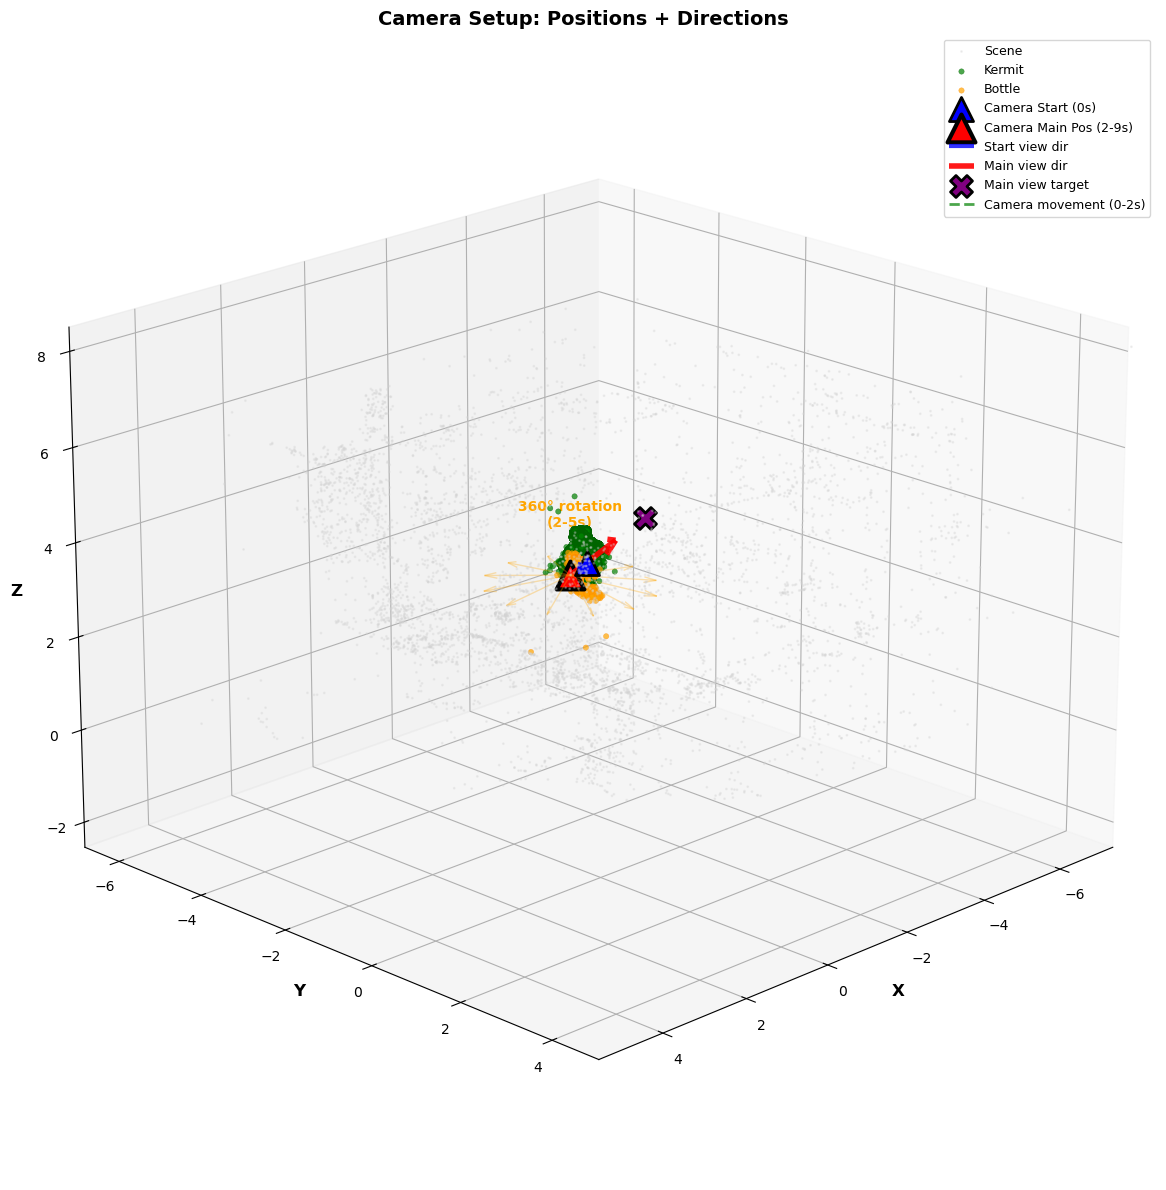


Saved: data/mv_demo/20251209_081245/keyframes/step7_camera_setup.png

📍 Camera Timeline Visualization:
  🔵 Blue arrow (0s): Start position → looking at scene
  🟢 Green dashed line (0-2s): Camera movement path
  🔴 Red arrow (2-9s): Main position (FIXED) → main view direction
  🟠 Orange arrows (2-5s): 360° rotation (camera spins in place)
  🟣 Purple X: Where main view direction points to


In [80]:
# Cell 7.2: Visualize Camera Setup (3D)

print("\n" + "="*70)
print("VISUALIZE CAMERA SETUP")
print("="*70)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# =============================================================================
# Scene + Objects
# =============================================================================

# Scene (sampled)
scene_xyz = scene_gaussians_aligned['xyz']
scene_sample_idx = np.random.choice(len(scene_xyz), min(5000, len(scene_xyz)), replace=False)
ax.scatter(scene_xyz[scene_sample_idx, 0], 
          scene_xyz[scene_sample_idx, 1], 
          scene_xyz[scene_sample_idx, 2],
          s=1, alpha=0.3, c='lightgray', label='Scene')

# Objects (initial positions)
obj01_xyz = obj01_placed['xyz']
obj02_xyz = obj02_placed['xyz']

ax.scatter(obj01_xyz[:, 0], obj01_xyz[:, 1], obj01_xyz[:, 2],
          s=15, alpha=0.7, c='green', edgecolors='darkgreen', linewidth=0.3, label='Kermit')
ax.scatter(obj02_xyz[:, 0], obj02_xyz[:, 1], obj02_xyz[:, 2],
          s=15, alpha=0.7, c='orange', edgecolors='darkorange', linewidth=0.3, label='Bottle')

# =============================================================================
# Camera Positions
# =============================================================================

# Camera start position (from Part 4)
ax.scatter(*camera_start_position, s=300, c='blue', marker='^', 
          edgecolors='black', linewidths=2, label='Camera Start (0s)', zorder=10)

# Camera main position (fixed 2-9s)
ax.scatter(*CAMERA_MAIN_POSITION, s=400, c='red', marker='^', 
          edgecolors='black', linewidths=3, label='Camera Main Pos (2-9s)', zorder=10)

# =============================================================================
# View Directions (Arrows)
# =============================================================================

# Camera start view direction
start_look_at = scene_center  # From Part 4
start_dir = (start_look_at - camera_start_position)
start_dir = start_dir / np.linalg.norm(start_dir) * 2.0  # Scale for visibility
ax.quiver(*camera_start_position, *start_dir, 
         color='blue', linewidth=3, arrow_length_ratio=0.2, alpha=0.8, label='Start view dir')

# Main view direction
main_dir = MAIN_VIEW_DIRECTION * 3.0  # Scale for visibility
ax.quiver(*CAMERA_MAIN_POSITION, *main_dir, 
         color='red', linewidth=4, arrow_length_ratio=0.2, alpha=0.9, label='Main view dir')

# Main view look-at point
ax.scatter(*main_view_look_at_point, s=250, c='purple', marker='X', 
          edgecolors='black', linewidths=2, label='Main view target', zorder=10)

# =============================================================================
# Camera Movement Path (0-2s)
# =============================================================================

# Line from start to main position
ax.plot([camera_start_position[0], CAMERA_MAIN_POSITION[0]],
       [camera_start_position[1], CAMERA_MAIN_POSITION[1]],
       [camera_start_position[2], CAMERA_MAIN_POSITION[2]],
       'g--', linewidth=2, alpha=0.7, label='Camera movement (0-2s)')

# =============================================================================
# 360° Rotation Visualization (2-5s)
# =============================================================================

# Draw multiple view directions around camera main position
n_rotation_samples = 12
for i in range(n_rotation_samples):
    angle = 2 * np.pi * i / n_rotation_samples
    # Rotate MAIN_VIEW_DIRECTION around Z-axis
    cos_a, sin_a = np.cos(angle), np.sin(angle)
    rotated_dir = np.array([
        MAIN_VIEW_DIRECTION[0] * cos_a - MAIN_VIEW_DIRECTION[1] * sin_a,
        MAIN_VIEW_DIRECTION[0] * sin_a + MAIN_VIEW_DIRECTION[1] * cos_a,
        MAIN_VIEW_DIRECTION[2]
    ]) * 1.5
    
    ax.quiver(*CAMERA_MAIN_POSITION, *rotated_dir, 
             color='orange', linewidth=1, arrow_length_ratio=0.15, alpha=0.3)

# Add text label
ax.text(CAMERA_MAIN_POSITION[0], CAMERA_MAIN_POSITION[1], CAMERA_MAIN_POSITION[2] + 1.0,
       '360° rotation\n(2-5s)', fontsize=10, ha='center', color='orange', fontweight='bold')

ax.set_xlabel('X', fontsize=12, fontweight='bold')
ax.set_ylabel('Y', fontsize=12, fontweight='bold')
ax.set_zlabel('Z', fontsize=12, fontweight='bold')
ax.set_title('Camera Setup: Positions + Directions', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)

# =============================================================================
# Zoomed View (focus on relevant area)
# =============================================================================

key_points = np.vstack([
    obj01_xyz,
    obj02_xyz,
    [camera_start_position],
    [CAMERA_MAIN_POSITION],
    [main_view_look_at_point]
])

margin = 3.0
x_range = [key_points[:, 0].min() - margin, key_points[:, 0].max() + margin]
y_range = [key_points[:, 1].min() - margin, key_points[:, 1].max() + margin]
z_range = [key_points[:, 2].min() - margin, key_points[:, 2].max() + margin]

ax.set_xlim(x_range)
ax.set_ylim(y_range)
ax.set_zlim(z_range)

ax.grid(True, alpha=0.3)
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.savefig(KEYFRAMES_DIR / "step7_camera_setup.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved: {KEYFRAMES_DIR / 'step7_camera_setup.png'}")

print("\n📍 Camera Timeline Visualization:")
print("  🔵 Blue arrow (0s): Start position → looking at scene")
print("  🟢 Green dashed line (0-2s): Camera movement path")
print("  🔴 Red arrow (2-9s): Main position (FIXED) → main view direction")
print("  🟠 Orange arrows (2-5s): 360° rotation (camera spins in place)")
print("  🟣 Purple X: Where main view direction points to")

In [82]:
# Cell 7.2.1: Export Camera Setup as PLY for Viewing

print("\n" + "="*70)
print("EXPORT CAMERA SETUP AS PLY")
print("="*70)

# =============================================================================
# Helper: Create Arrow/Line Marker
# =============================================================================

def create_arrow_marker(
    start_pos: np.ndarray,
    direction: np.ndarray,
    length: float,
    color: np.ndarray,
    n_points: int = 100,
    thickness: float = 0.05
) -> Dict:
    """
    Create an arrow as Gaussian points.
    
    Args:
        start_pos: Arrow start position [x, y, z]
        direction: Direction vector (will be normalized)
        length: Arrow length
        color: RGB color [r, g, b] in range [0, 1]
        n_points: Number of points along arrow
        thickness: Arrow thickness
    """
    direction_norm = direction / np.linalg.norm(direction)
    
    # Points along arrow
    t = np.linspace(0, length, n_points)
    positions = start_pos + np.outer(t, direction_norm)
    
    # Create Gaussian dict
    n = len(positions)
    
    # Convert RGB to SH (DC term)
    SH_C0 = 0.28209479177387814
    sh_dc = (color - 0.5) / SH_C0
    
    gaussians = {
        'xyz': positions.astype(np.float32),
        'features_dc': np.tile(sh_dc, (n, 1)).astype(np.float32),
        'features_rest': np.zeros((n, 45), dtype=np.float32),
        'opacities': np.full((n, 1), 5.0, dtype=np.float32),  # ★ Shape (n, 1)
        'scales': np.tile([np.log(thickness), np.log(thickness), np.log(thickness)], (n, 1)).astype(np.float32),
        'rotations': np.tile([1, 0, 0, 0], (n, 1)).astype(np.float32)
    }
    
    return gaussians

def create_sphere_marker_large(
    center: np.ndarray,
    radius: float,
    color: np.ndarray,
    n_points: int = 500
) -> Dict:
    """
    Create a dense sphere marker.
    """
    # Random points in sphere
    phi = np.random.uniform(0, 2*np.pi, n_points)
    theta = np.random.uniform(0, np.pi, n_points)
    r = np.random.uniform(0, radius, n_points) ** (1/3)  # Uniform volume distribution
    
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    
    positions = np.stack([x, y, z], axis=1) + center
    
    # Convert RGB to SH
    SH_C0 = 0.28209479177387814
    sh_dc = (color - 0.5) / SH_C0
    
    gaussians = {
        'xyz': positions.astype(np.float32),
        'features_dc': np.tile(sh_dc, (n_points, 1)).astype(np.float32),
        'features_rest': np.zeros((n_points, 45), dtype=np.float32),
        'opacities': np.full((n_points, 1), 5.0, dtype=np.float32),  # ★ Shape (n, 1)
        'scales': np.tile([np.log(0.03), np.log(0.03), np.log(0.03)], (n_points, 1)).astype(np.float32),
        'rotations': np.tile([1, 0, 0, 0], (n_points, 1)).astype(np.float32)
    }
    
    return gaussians

# =============================================================================
# Create Markers
# =============================================================================

print("\nCreating camera setup markers...")

# 1. Camera Start Position (Blue sphere)
camera_start_marker = create_sphere_marker_large(
    center=camera_start_position,
    radius=0.2,
    color=np.array([0.0, 0.0, 1.0], dtype=np.float32)  # Blue
)
print(f"  ✓ Camera Start (blue sphere): {len(camera_start_marker['xyz'])} points")

# 2. Camera Main Position (Red sphere)
camera_main_marker = create_sphere_marker_large(
    center=CAMERA_MAIN_POSITION,
    radius=0.25,
    color=np.array([1.0, 0.0, 0.0], dtype=np.float32)  # Red
)
print(f"  ✓ Camera Main Position (red sphere): {len(camera_main_marker['xyz'])} points")

# 3. Main View Look-at Point (Purple sphere)
main_view_target_marker = create_sphere_marker_large(
    center=main_view_look_at_point,
    radius=0.15,
    color=np.array([0.8, 0.0, 0.8], dtype=np.float32)  # Purple
)
print(f"  ✓ Main View Target (purple sphere): {len(main_view_target_marker['xyz'])} points")

# 4. Camera Start View Direction (Blue arrow)
start_look_at = scene_center  # From Part 4
start_view_arrow = create_arrow_marker(
    start_pos=camera_start_position,
    direction=start_look_at - camera_start_position,
    length=np.linalg.norm(start_look_at - camera_start_position) * 0.5,
    color=np.array([0.0, 0.5, 1.0], dtype=np.float32),  # Light blue
    thickness=0.08
)
print(f"  ✓ Start View Arrow (light blue): {len(start_view_arrow['xyz'])} points")

# 5. Main View Direction (Red arrow)
main_view_arrow = create_arrow_marker(
    start_pos=CAMERA_MAIN_POSITION,
    direction=MAIN_VIEW_DIRECTION,
    length=3.0,
    color=np.array([1.0, 0.0, 0.0], dtype=np.float32),  # Red
    thickness=0.1
)
print(f"  ✓ Main View Arrow (red): {len(main_view_arrow['xyz'])} points")

# 6. Camera Movement Path (0-2s) (Green line)
movement_path_marker = create_arrow_marker(
    start_pos=camera_start_position,
    direction=CAMERA_MAIN_POSITION - camera_start_position,
    length=np.linalg.norm(CAMERA_MAIN_POSITION - camera_start_position),
    color=np.array([0.0, 1.0, 0.0], dtype=np.float32),  # Green
    n_points=50,
    thickness=0.06
)
print(f"  ✓ Movement Path (green line): {len(movement_path_marker['xyz'])} points")

# =============================================================================
# Merge and Save PLY
# =============================================================================

print("\nMerging with scene and objects...")

camera_setup_ply_path = KEYFRAMES_DIR / "step7_camera_setup_with_markers.ply"

merge_and_save_gaussians(
    gaussians_dict={
        "scene": scene_gaussians_aligned,
        "obj01_kermit": obj01_placed,
        "obj02_bottle": obj02_placed,
        "camera_start": camera_start_marker,
        "camera_main": camera_main_marker,
        "main_view_target": main_view_target_marker,
        "start_view_arrow": start_view_arrow,
        "main_view_arrow": main_view_arrow,
        "movement_path": movement_path_marker
    },
    output_path=camera_setup_ply_path,
    verbose=True
)

print("\n" + "="*70)
print("CAMERA SETUP PLY EXPORTED")
print("="*70)

print(f"\n✓ Saved: {camera_setup_ply_path.name}")
print(f"  File size: {camera_setup_ply_path.stat().st_size / (1024**2):.2f} MB")

print("\n📍 Marker Legend:")
print("  🔵 Blue sphere: Camera Start Position (0s)")
print("  🔴 Red sphere: Camera Main Position (2-9s)")
print("  🟣 Purple sphere: Main View Target (where red arrow points)")
print("  🔵 Light blue arrow: Camera start view direction")
print("  🔴 Red arrow: Main view direction (primary view)")
print("  🟢 Green line: Camera movement path (0-2s)")

print("\n💡 How to view:")
print("  1. Go to: https://antimatter15.com/splat/")
print(f"  2. Drag & drop: {camera_setup_ply_path.name}")
print("  3. Navigate around to see camera positions and directions")
print("  4. Red arrow shows where camera looks during 5-9s (main view)")
print("  5. During 2-5s, camera rotates 360° at red sphere position")

print(f"\n📁 File location: {camera_setup_ply_path}")

print("\n[OK] Camera setup visualization ready for web viewer")


EXPORT CAMERA SETUP AS PLY

Creating camera setup markers...
  ✓ Camera Start (blue sphere): 500 points
  ✓ Camera Main Position (red sphere): 500 points
  ✓ Main View Target (purple sphere): 500 points
  ✓ Start View Arrow (light blue): 100 points
  ✓ Main View Arrow (red): 100 points
  ✓ Movement Path (green line): 50 points

Merging with scene and objects...

MERGING GAUSSIANS
  scene: 1,508,976 points
  obj01_kermit: 108,077 points
  obj02_bottle: 71,268 points
  camera_start: 500 points
  camera_main: 500 points
  main_view_target: 500 points
  start_view_arrow: 100 points
  main_view_arrow: 100 points
  movement_path: 50 points

Total merged points: 1,690,071

Saving to: data/mv_demo/20251209_081245/keyframes/step7_camera_setup_with_markers.ply
  ✓ Saved: step7_camera_setup_with_markers.ply
    Points: 1,690,071 | Size: 380.38 MB

[OK] Merged PLY saved
    View online: https://antimatter15.com/splat/

CAMERA SETUP PLY EXPORTED

✓ Saved: step7_camera_setup_with_markers.ply
  File

In [83]:
# Cell 7.3: Camera Trajectory Generation Function

print("\n" + "="*70)
print("CAMERA TRAJECTORY GENERATION FUNCTION")
print("="*70)

def generate_camera_trajectory_v2(
    start_pos: np.ndarray,
    start_rot: np.ndarray,
    main_pos: np.ndarray,
    main_view_direction: np.ndarray,
    main_view_rotation: np.ndarray,
    n_frames: int,
    fps: int
) -> List[Dict]:
    """
    Generate camera trajectory - camera moves to main position then rotates in place.
    
    Timeline (11s):
    - 0-2s: Move from start_pos to main_pos, rotate to main_view_direction
    - 2-5s: Fixed at main_pos, 360° rotation (spin in place)
    - 5-9s: Fixed at main_pos, fixed at main_view_direction
    - 9-11s: Move backward from main_pos (zoom out), keep main_view_direction
    """
    frames = []
    
    # Timeline shortcuts
    T_intro = CAMERA_TIMELINE["intro_move"]
    T_scan = CAMERA_TIMELINE["room_scan"]
    T_static = CAMERA_TIMELINE["static_view"]
    T_zoom = CAMERA_TIMELINE["zoom_out"]
    
    # Calculate a point along main view direction (for look_at)
    main_view_target = main_pos + main_view_direction * 5.0
    
    for f in range(n_frames):
        t = f / fps
        
        if t < T_intro["end_sec"]:
            # 0-2s: Move from start to main position
            u = (t - T_intro["start_sec"]) / T_intro["duration_sec"]
            u_smooth = ease_in_out_cubic(u)
            
            # Position: lerp
            pos = start_pos * (1 - u_smooth) + main_pos * u_smooth
            
            # Rotation: lerp (approximate slerp)
            rot = start_rot * (1 - u_smooth) + main_view_rotation * u_smooth
            rot = rot / np.linalg.norm(rot)
        
        elif t < T_scan["end_sec"]:
            # 2-5s: Fixed position, 360° rotation
            u = (t - T_scan["start_sec"]) / T_scan["duration_sec"]
            
            pos = main_pos.copy()
            
            # Rotate around Z-axis (yaw)
            angle = 2 * np.pi * u  # 0 to 2π
            
            # Rotate main_view_direction around Z-axis
            cos_a, sin_a = np.cos(angle), np.sin(angle)
            rotated_direction = np.array([
                main_view_direction[0] * cos_a - main_view_direction[1] * sin_a,
                main_view_direction[0] * sin_a + main_view_direction[1] * cos_a,
                main_view_direction[2]
            ], dtype=np.float32)
            
            # Calculate rotation to look in rotated direction
            look_target = pos + rotated_direction * 5.0
            rot = look_at_quaternion(pos, look_target)
        
        elif t < T_static["end_sec"]:
            # 5-9s: Fixed position, fixed direction
            pos = main_pos.copy()
            rot = main_view_rotation.copy()
            
            # Optional: subtle handheld shake
            shake_amp = 0.01
            shake_freq = 2.0
            shake = shake_amp * np.array([
                np.sin(2 * np.pi * shake_freq * t),
                np.sin(2 * np.pi * shake_freq * t * 1.3),
                np.sin(2 * np.pi * shake_freq * t * 0.7)
            ], dtype=np.float32)
            pos += shake
        
        else:
            # 9-11s: Move backward (zoom out)
            u = (t - T_zoom["start_sec"]) / T_zoom["duration_sec"]
            u_smooth = ease_in_out_cubic(u)
            
            # Move backward along inverse of main view direction
            zoom_out_distance = 1.5  # ★ Adjust this
            pos = main_pos - main_view_direction * zoom_out_distance * u_smooth
            
            # Keep looking in main view direction
            rot = main_view_rotation.copy()
        
        frames.append({
            "frame": f,
            "position": pos.tolist(),
            "rotation_quat": rot.tolist()
        })
    
    return frames

print("\n✓ Camera trajectory generation function defined")
print("  → 0-2s: Start → Main position")
print("  → 2-5s: 360° rotation (fixed position)")
print("  → 5-9s: Fixed (main view)")
print("  → 9-11s: Zoom out (move backward)")
print("\n[OK] Function ready")


CAMERA TRAJECTORY GENERATION FUNCTION

✓ Camera trajectory generation function defined
  → 0-2s: Start → Main position
  → 2-5s: 360° rotation (fixed position)
  → 5-9s: Fixed (main view)
  → 9-11s: Zoom out (move backward)

[OK] Function ready


In [84]:
# Cell 7.4: Generate Camera Trajectory

print("\n" + "="*70)
print("GENERATE CAMERA TRAJECTORY")
print("="*70)

print("\nGenerating camera trajectory...")

camera_trajectory = generate_camera_trajectory_v2(
    start_pos=camera_start_position,
    start_rot=camera_start_rotation,
    main_pos=CAMERA_MAIN_POSITION,
    main_view_direction=MAIN_VIEW_DIRECTION,
    main_view_rotation=main_view_rotation,
    n_frames=ANIMATION_N_FRAMES,
    fps=ANIMATION_FPS
)

print(f"\n✓ Camera trajectory: {len(camera_trajectory)} frames")

# Extract for analysis
camera_positions = np.array([frame["position"] for frame in camera_trajectory])
camera_rotations = np.array([frame["rotation_quat"] for frame in camera_trajectory])

print("\nCamera Position Statistics:")
print(f"  Position range X: [{camera_positions[:, 0].min():.3f}, {camera_positions[:, 0].max():.3f}]")
print(f"  Position range Y: [{camera_positions[:, 1].min():.3f}, {camera_positions[:, 1].max():.3f}]")
print(f"  Position range Z: [{camera_positions[:, 2].min():.3f}, {camera_positions[:, 2].max():.3f}]")

# Calculate distances for each segment
intro_positions = camera_positions[CAMERA_TIMELINE["intro_move"]["start_frame"]:CAMERA_TIMELINE["intro_move"]["end_frame"]]
scan_positions = camera_positions[CAMERA_TIMELINE["room_scan"]["start_frame"]:CAMERA_TIMELINE["room_scan"]["end_frame"]]
static_positions = camera_positions[CAMERA_TIMELINE["static_view"]["start_frame"]:CAMERA_TIMELINE["static_view"]["end_frame"]]
zoom_positions = camera_positions[CAMERA_TIMELINE["zoom_out"]["start_frame"]:CAMERA_TIMELINE["zoom_out"]["end_frame"]]

print("\nCamera Movement by Segment:")
print(f"  0-2s (intro): traveled {np.linalg.norm(intro_positions[-1] - intro_positions[0]):.3f} units")
print(f"  2-5s (scan): position variance {np.std(scan_positions, axis=0).max():.6f} (should be ~0)")
print(f"  5-9s (static): position variance {np.std(static_positions, axis=0).max():.6f} (should be ~0)")
print(f"  9-11s (zoom): traveled {np.linalg.norm(zoom_positions[-1] - zoom_positions[0]):.3f} units")

print("\n[OK] Camera trajectory generated")


GENERATE CAMERA TRAJECTORY

Generating camera trajectory...

✓ Camera trajectory: 330 frames

Camera Position Statistics:
  Position range X: [-0.058, 2.500]
  Position range Y: [-0.740, 2.000]
  Position range Z: [3.635, 5.500]

Camera Movement by Segment:
  0-2s (intro): traveled 4.170 units
  2-5s (scan): position variance 0.000000 (should be ~0)
  5-9s (static): position variance 0.007080 (should be ~0)
  9-11s (zoom): traveled 1.500 units

[OK] Camera trajectory generated



VISUALIZE CAMERA TRAJECTORY


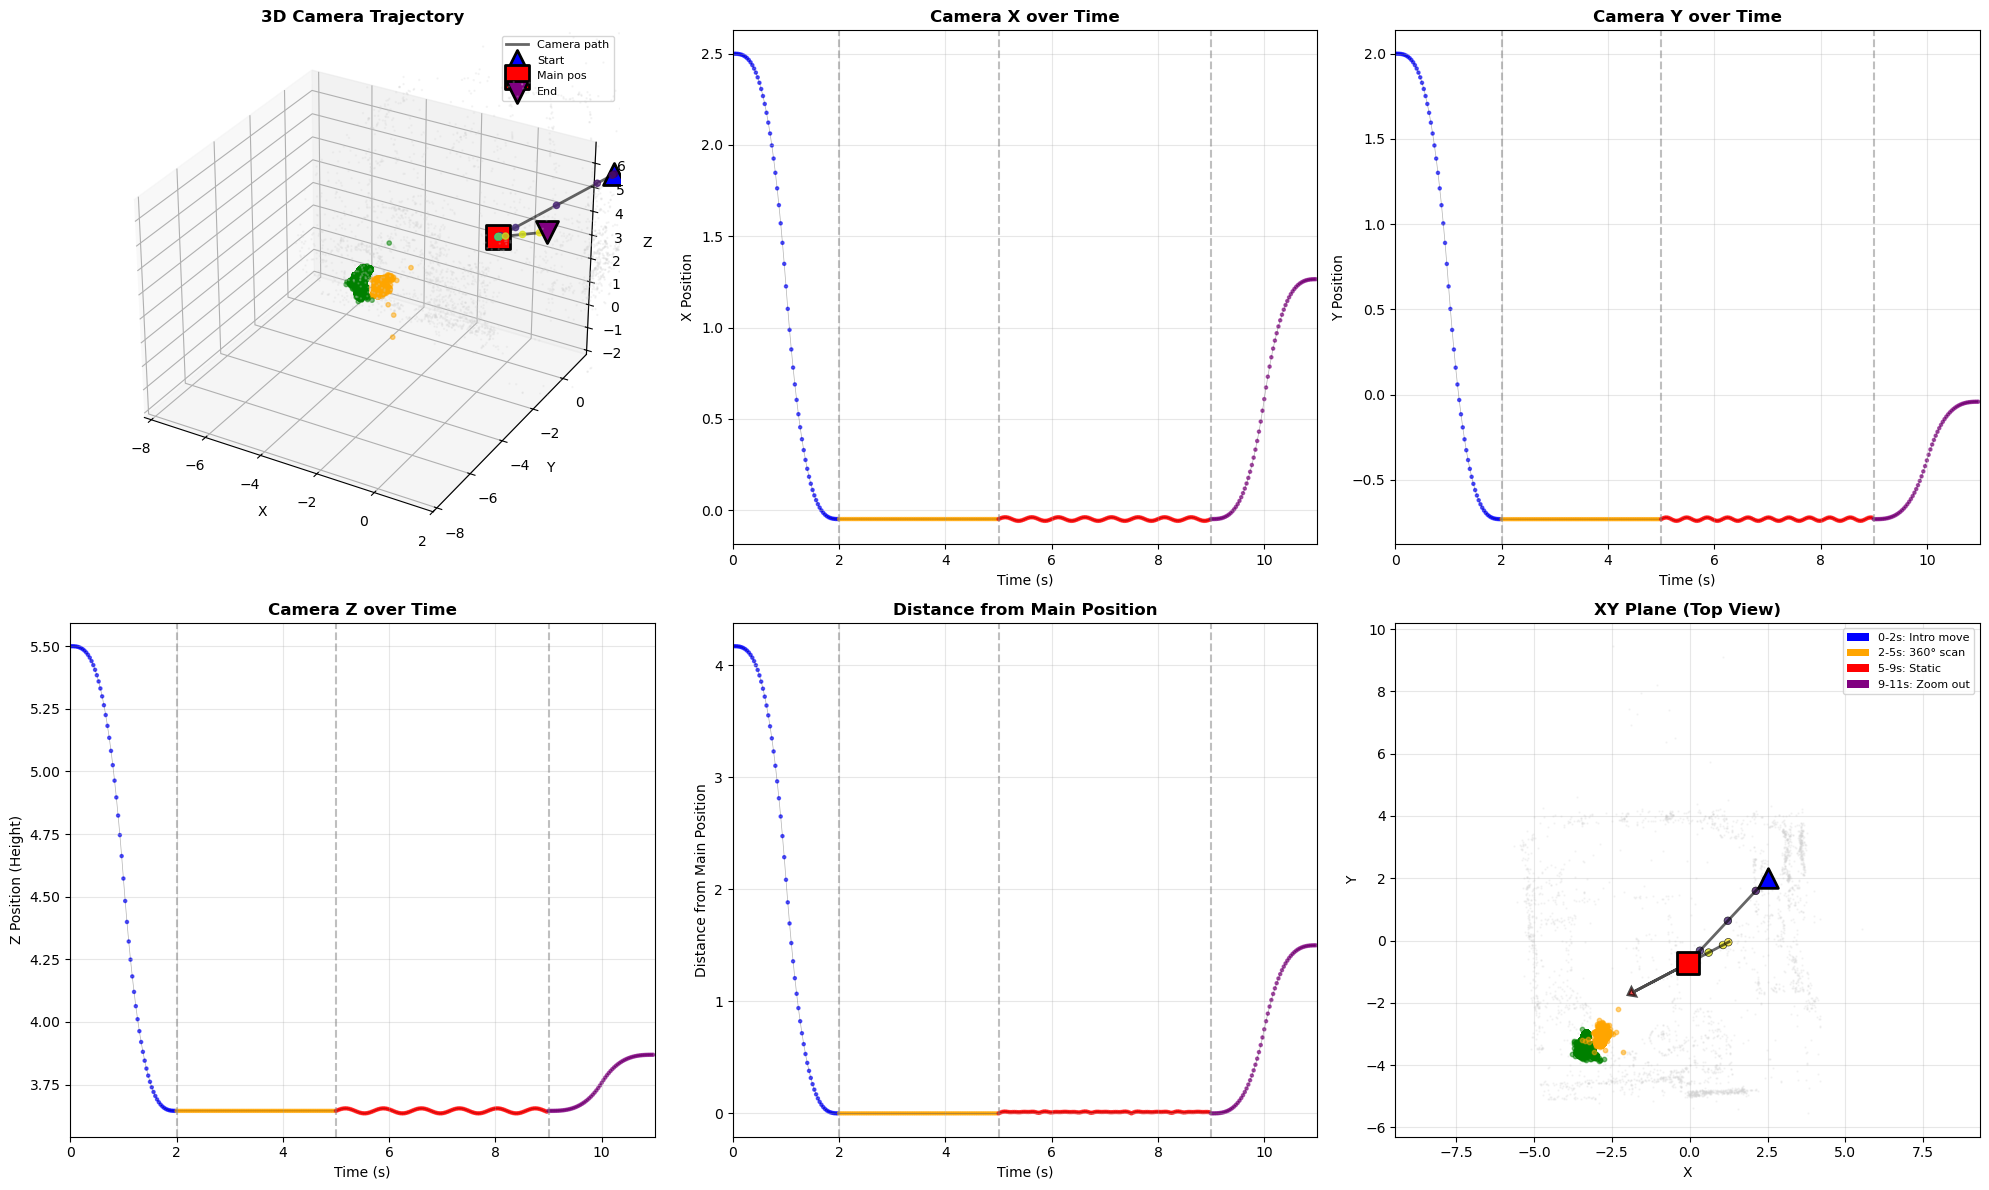


Saved: data/mv_demo/20251209_081245/keyframes/step7_camera_trajectory.png

TRAJECTORY ANALYSIS

📊 Segment Analysis:

  intro_move (0.0-2.0s):
    Position variance: [1.0214, 1.0941, 0.7435]

  room_scan (2.0-5.0s):
    Position variance: [0.0000, 0.0000, 0.0000]
    → Should be near 0 (position fixed)

  static_view (5.0-9.0s):
    Position variance: [0.0071, 0.0071, 0.0070]
    → Should be near 0 (position fixed)

  zoom_out (9.0-11.0s):
    Position variance: [0.5265, 0.2761, 0.0898]

[OK] Camera trajectory visualization complete


In [85]:
# Cell 7.5: Visualize Camera Trajectory

print("\n" + "="*70)
print("VISUALIZE CAMERA TRAJECTORY")
print("="*70)

fig = plt.figure(figsize=(20, 12))

# Extract time array
times = np.arange(ANIMATION_N_FRAMES) / ANIMATION_FPS

# Segment colors
def get_segment_color(t):
    if t < CAMERA_TIMELINE["intro_move"]["end_sec"]:
        return 'blue'
    elif t < CAMERA_TIMELINE["room_scan"]["end_sec"]:
        return 'orange'
    elif t < CAMERA_TIMELINE["static_view"]["end_sec"]:
        return 'red'
    else:
        return 'purple'

colors = [get_segment_color(t) for t in times]

# =============================================================================
# Row 1: 3D Trajectory + Scene Context
# =============================================================================

ax1 = fig.add_subplot(2, 3, 1, projection='3d')

# Scene context (lighter)
scene_xyz = scene_gaussians_aligned['xyz']
scene_sample_idx = np.random.choice(len(scene_xyz), min(3000, len(scene_xyz)), replace=False)
ax1.scatter(scene_xyz[scene_sample_idx, 0], 
           scene_xyz[scene_sample_idx, 1], 
           scene_xyz[scene_sample_idx, 2],
           s=0.5, alpha=0.2, c='lightgray')

# Objects
obj01_xyz = obj01_placed['xyz']
obj02_xyz = obj02_placed['xyz']
ax1.scatter(obj01_xyz[:, 0], obj01_xyz[:, 1], obj01_xyz[:, 2],
           s=10, alpha=0.5, c='green')
ax1.scatter(obj02_xyz[:, 0], obj02_xyz[:, 1], obj02_xyz[:, 2],
           s=10, alpha=0.5, c='orange')

# Camera path
ax1.plot(camera_positions[:, 0], camera_positions[:, 1], camera_positions[:, 2],
        c='black', linewidth=2, alpha=0.6, label='Camera path')
ax1.scatter(camera_positions[::10, 0], camera_positions[::10, 1], camera_positions[::10, 2],
           c=times[::10], cmap='viridis', s=20, alpha=0.8)

# Key positions
ax1.scatter(*camera_start_position, s=250, c='blue', marker='^', 
           edgecolors='black', linewidths=2, label='Start', zorder=10)
ax1.scatter(*CAMERA_MAIN_POSITION, s=300, c='red', marker='s', 
           edgecolors='black', linewidths=2, label='Main pos', zorder=10)
ax1.scatter(*camera_positions[-1], s=250, c='purple', marker='v', 
           edgecolors='black', linewidths=2, label='End', zorder=10)

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('3D Camera Trajectory', fontweight='bold')
ax1.legend(loc='upper right', fontsize=8)

# Zoom to relevant area
key_points = np.vstack([camera_positions, obj01_xyz, obj02_xyz])
margin = 2.0
for axis, idx in [('x', 0), ('y', 1), ('z', 2)]:
    center = key_points[:, idx].mean()
    range_val = key_points[:, idx].max() - key_points[:, idx].min()
    getattr(ax1, f'set_{axis}lim')([center - range_val/2 - margin, center + range_val/2 + margin])

# =============================================================================
# Row 1: Position Components over Time
# =============================================================================

# X Position
ax2 = fig.add_subplot(2, 3, 2)
ax2.scatter(times, camera_positions[:, 0], c=colors, s=5, alpha=0.6)
ax2.plot(times, camera_positions[:, 0], 'k-', linewidth=0.5, alpha=0.3)
for seg_name, seg_data in CAMERA_TIMELINE.items():
    if seg_data['start_sec'] > 0:
        ax2.axvline(seg_data['start_sec'], color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('X Position')
ax2.set_title('Camera X over Time', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, ANIMATION_DURATION])

# Y Position
ax3 = fig.add_subplot(2, 3, 3)
ax3.scatter(times, camera_positions[:, 1], c=colors, s=5, alpha=0.6)
ax3.plot(times, camera_positions[:, 1], 'k-', linewidth=0.5, alpha=0.3)
for seg_name, seg_data in CAMERA_TIMELINE.items():
    if seg_data['start_sec'] > 0:
        ax3.axvline(seg_data['start_sec'], color='gray', linestyle='--', alpha=0.5)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Y Position')
ax3.set_title('Camera Y over Time', fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, ANIMATION_DURATION])

# =============================================================================
# Row 2: Z Position + Distance from Main Position
# =============================================================================

# Z Position
ax4 = fig.add_subplot(2, 3, 4)
ax4.scatter(times, camera_positions[:, 2], c=colors, s=5, alpha=0.6)
ax4.plot(times, camera_positions[:, 2], 'k-', linewidth=0.5, alpha=0.3)
for seg_name, seg_data in CAMERA_TIMELINE.items():
    if seg_data['start_sec'] > 0:
        ax4.axvline(seg_data['start_sec'], color='gray', linestyle='--', alpha=0.5)
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Z Position (Height)')
ax4.set_title('Camera Z over Time', fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.set_xlim([0, ANIMATION_DURATION])

# Distance from main position
ax5 = fig.add_subplot(2, 3, 5)
distances = np.linalg.norm(camera_positions - CAMERA_MAIN_POSITION, axis=1)
ax5.scatter(times, distances, c=colors, s=5, alpha=0.6)
ax5.plot(times, distances, 'k-', linewidth=0.5, alpha=0.3)
for seg_name, seg_data in CAMERA_TIMELINE.items():
    if seg_data['start_sec'] > 0:
        ax5.axvline(seg_data['start_sec'], color='gray', linestyle='--', alpha=0.5)
ax5.set_xlabel('Time (s)')
ax5.set_ylabel('Distance from Main Position')
ax5.set_title('Distance from Main Position', fontweight='bold')
ax5.grid(True, alpha=0.3)
ax5.set_xlim([0, ANIMATION_DURATION])

# =============================================================================
# Row 2: XY Plane (Top View)
# =============================================================================

ax6 = fig.add_subplot(2, 3, 6)

# Scene + Objects (lighter)
ax6.scatter(scene_xyz[scene_sample_idx, 0], scene_xyz[scene_sample_idx, 1],
           s=0.5, alpha=0.2, c='lightgray')
ax6.scatter(obj01_xyz[:, 0], obj01_xyz[:, 1], s=10, alpha=0.5, c='green')
ax6.scatter(obj02_xyz[:, 0], obj02_xyz[:, 1], s=10, alpha=0.5, c='orange')

# Camera path
ax6.plot(camera_positions[:, 0], camera_positions[:, 1], 'k-', linewidth=2, alpha=0.6)
ax6.scatter(camera_positions[::10, 0], camera_positions[::10, 1],
           c=times[::10], cmap='viridis', s=30, alpha=0.8, edgecolors='black', linewidth=0.5)

# Key positions
ax6.scatter(*camera_start_position[:2], s=200, c='blue', marker='^', 
           edgecolors='black', linewidths=2, zorder=10)
ax6.scatter(*CAMERA_MAIN_POSITION[:2], s=250, c='red', marker='s', 
           edgecolors='black', linewidths=2, zorder=10)

# Main view direction arrow
main_dir_2d = MAIN_VIEW_DIRECTION[:2] * 2.0
ax6.arrow(CAMERA_MAIN_POSITION[0], CAMERA_MAIN_POSITION[1],
         main_dir_2d[0], main_dir_2d[1],
         head_width=0.3, head_length=0.2, fc='red', ec='black', linewidth=2, alpha=0.7)

ax6.set_xlabel('X')
ax6.set_ylabel('Y')
ax6.set_title('XY Plane (Top View)', fontweight='bold')
ax6.grid(True, alpha=0.3)
ax6.axis('equal')

# Legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', label='0-2s: Intro move'),
    Patch(facecolor='orange', label='2-5s: 360° scan'),
    Patch(facecolor='red', label='5-9s: Static'),
    Patch(facecolor='purple', label='9-11s: Zoom out')
]
ax6.legend(handles=legend_elements, loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig(KEYFRAMES_DIR / "step7_camera_trajectory.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved: {KEYFRAMES_DIR / 'step7_camera_trajectory.png'}")

print("\n" + "="*70)
print("TRAJECTORY ANALYSIS")
print("="*70)

print("\n📊 Segment Analysis:")
for seg_name, seg_data in CAMERA_TIMELINE.items():
    seg_positions = camera_positions[seg_data["start_frame"]:seg_data["end_frame"]]
    seg_variance = np.std(seg_positions, axis=0)
    print(f"\n  {seg_name} ({seg_data['start_sec']:.1f}-{seg_data['end_sec']:.1f}s):")
    print(f"    Position variance: [{seg_variance[0]:.4f}, {seg_variance[1]:.4f}, {seg_variance[2]:.4f}]")
    if seg_name in ["room_scan", "static_view"]:
        print(f"    → Should be near 0 (position fixed)")

print("\n[OK] Camera trajectory visualization complete")

---
# Part 8: Save Trajectory JSON

In [87]:
# Cell 8.1: Create Trajectory JSON

print("\n" + "="*70)
print("CREATE TRAJECTORY JSON")
print("="*70)

# Helper function to convert numpy arrays to lists recursively
def convert_to_serializable(obj):
    """Convert numpy arrays and other non-serializable objects to JSON-compatible types."""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    else:
        return obj

trajectory = {
    "metadata": {
        "run_id": RUN_ID,
        "fps": int(ANIMATION_FPS),
        "duration_sec": float(ANIMATION_DURATION),
        "n_frames": int(ANIMATION_N_FRAMES),
        "resolution": VIDEO_CONFIG["resolution"],
        "fov_degrees": VIDEO_CONFIG["fov_degrees"],
        "story_segments": {
            "intro": "0-2s: Camera moves to scene center",
            "scan": "2-5s: 360° rotation at scene center",
            "kermit_jump": "5-7s: Kermit jumps",
            "bottle_action": "7-9s: Bottle moves to mouth + wobble",
            "finale": "9-11s: Kermit scale up + Bottle returns"
        },
        "camera_config": {
            "main_position": CAMERA_MAIN_POSITION.tolist(),
            "main_view_direction": MAIN_VIEW_DIRECTION.tolist(),
            "start_position": camera_start_position.tolist()
        },
        "object_config": {
            "obj01_initial": convert_to_serializable(INITIAL_POSES["obj01"]),
            "obj02_initial": convert_to_serializable(INITIAL_POSES["obj02"])
        }
    },
    "camera": {
        "frames": convert_to_serializable(camera_trajectory)
    },
    "objects": {
        "obj01": {
            "name": "Kermit",
            "initial_pose": convert_to_serializable(INITIAL_POSES["obj01"]),
            "frames": convert_to_serializable(obj01_animation)
        },
        "obj02": {
            "name": "Bottle",
            "initial_pose": convert_to_serializable(INITIAL_POSES["obj02"]),
            "frames": convert_to_serializable(obj02_animation)
        }
    }
}

# Save JSON
trajectory_path = JSON_DIR / "trajectory_story.json"
with open(trajectory_path, 'w') as f:
    json.dump(trajectory, f, indent=2)

print(f"\n✓ Trajectory saved: {trajectory_path}")
print(f"  File size: {trajectory_path.stat().st_size / 1024:.1f} KB")

# Validation
print("\n" + "="*70)
print("TRAJECTORY VALIDATION")
print("="*70)

print(f"\nFrames:")
print(f"  Camera: {len(trajectory['camera']['frames'])} frames")
print(f"  Obj01 (Kermit): {len(trajectory['objects']['obj01']['frames'])} frames")
print(f"  Obj02 (Bottle): {len(trajectory['objects']['obj02']['frames'])} frames")

if len(trajectory['camera']['frames']) == len(trajectory['objects']['obj01']['frames']) == len(trajectory['objects']['obj02']['frames']) == ANIMATION_N_FRAMES:
    print(f"\n✓ All trajectories have {ANIMATION_N_FRAMES} frames (consistent)")
else:
    print(f"\n❌ Frame count mismatch!")

print(f"\nMetadata:")
print(f"  Duration: {trajectory['metadata']['duration_sec']}s")
print(f"  FPS: {trajectory['metadata']['fps']}")
print(f"  Resolution: {trajectory['metadata']['resolution']}")
print(f"  FOV: {trajectory['metadata']['fov_degrees']}°")

print("\n[OK] Trajectory JSON saved and validated")


CREATE TRAJECTORY JSON

✓ Trajectory saved: data/mv_demo/20251209_081245/json/trajectory_story.json
  File size: 316.8 KB

TRAJECTORY VALIDATION

Frames:
  Camera: 330 frames
  Obj01 (Kermit): 330 frames
  Obj02 (Bottle): 330 frames

✓ All trajectories have 330 frames (consistent)

Metadata:
  Duration: 11.0s
  FPS: 30
  Resolution: [960, 540]
  FOV: 50.0°

[OK] Trajectory JSON saved and validated
